In [1]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.optimizers import Adam

In [3]:
env = gym.make('CartPole-v1')
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>

In [4]:
env.reset()

(array([-0.03783391, -0.00519486,  0.01505629, -0.01648051], dtype=float32),
 {})

In [5]:
env.step(0)

(array([-0.03793781, -0.20052947,  0.01472668,  0.28091457], dtype=float32),
 1.0,
 False,
 False,
 {})

In [6]:
env.action_space.n

2

In [7]:
env.reward_range

(-inf, inf)

In [8]:
env._max_episode_steps

500

In [9]:
for i in range(0,1000):
    env.render()
    a = np.random.randint(0,2)
    print(env.step(a))

(array([-0.0419484 , -0.00562064,  0.02034497, -0.00708748], dtype=float32), 1.0, False, False, {})
(array([-0.04206081,  0.18920371,  0.02020322, -0.29328254], dtype=float32), 1.0, False, False, {})
(array([-0.03827674,  0.38403186,  0.01433757, -0.57952577], dtype=float32), 1.0, False, False, {})
(array([-0.0305961 ,  0.18871197,  0.00274705, -0.28236094], dtype=float32), 1.0, False, False, {})
(array([-0.02682186, -0.00644906, -0.00290017,  0.01118713], dtype=float32), 1.0, False, False, {})
(array([-0.02695084, -0.2015293 , -0.00267643,  0.3029536 ], dtype=float32), 1.0, False, False, {})
(array([-0.03098143, -0.396613  ,  0.00338265,  0.59479123], dtype=float32), 1.0, False, False, {})
(array([-0.03891369, -0.59178215,  0.01527847,  0.88853776], dtype=float32), 1.0, False, False, {})
(array([-0.05074933, -0.78710806,  0.03304923,  1.1859841 ], dtype=float32), 1.0, False, False, {})
(array([-0.06649149, -0.59242994,  0.05676891,  0.90384114], dtype=float32), 1.0, False, False, {})


/Users/indra25/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/gym/envs/classic_control/cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(
/Users/indra25/opt/anaconda3/envs/tensorflow_env/lib/python3.10/site-packages/gym/envs/classic_control/cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


In [30]:
class Actor:
    def __init__(self,state_shape,total_actions):
        self.input_shape = state_shape
        self.output_shape = total_actions
        self.model = self.theta_NN()
        self.step_size = 0.001
        
    def step(self,state):
        action_probs,_ = self.predict_policy_actions(state) #generate probabilities from Actor N/W
        action = np.random.choice(self.output_shape, 1, p=action_probs.flatten())[0] #generate actions using 
                                                                        #the above probability distribution
        return action
    
    def theta_NN(self):
        
        inputs = keras.Input(shape=(self.input_shape,))
        x = layers.Dense(64, activation="relu")(inputs)
        x = layers.Dense(64, activation="relu")(x)
        outputs = layers.Dense(self.output_shape, activation="softmax")(x)
        model = keras.Model(inputs, outputs)
        model.compile(loss="mse", optimizer = Adam())

        return model
    
    def learn(self,samples):
        
        X = []
        y = []
        
        for state,action,delta in samples:
            
            state_f = self.preprocess(state)
            action_probs = self.model.predict(state_f).flatten()
            encoded_action = np.zeros(self.output_shape)
            encoded_action[action] = 1

            gradient = encoded_action - action_probs
            gradient_with_advantage = self.step_size * gradient * delta + action_probs
            gradient_with_advantage = gradient_with_advantage.reshape((1,self.output_shape))

            X.append([state_f])
            y.append(gradient_with_advantage)
            
        X = np.array(X)
        y = np.array(y)
        X = np.reshape(X,(X.shape[0],self.input_shape))
        y = np.reshape(y,(y.shape[0],self.output_shape))
        
        self.model.train_on_batch(X, y)

    def predict_policy_actions(self,state):
        state_f = self.preprocess(state)
        action_probabilities = self.model.predict([state_f],verbose=0)
        optimal_action = np.argmax(action_probabilities)
        
        return action_probabilities, optimal_action
    
    def preprocess(self,state):
        return np.reshape(state,(1,self.input_shape))
    
    def test_step(self,state):
        _,action = self.predict_policy_actions(state)
        return action

In [31]:
actor = Actor(4,2)
state = env.reset()[0]
actor.step(state)

0

In [32]:
class Critic:
    def __init__(self,state_shape,total_actions):
        self.input_shape = state_shape
        self.model = self.w_NN()
    
    def w_NN(self):
        
        inputs = keras.Input(shape=(self.input_shape,))
        x = layers.Dense(64, activation="relu")(inputs)
        x = layers.Dense(64, activation="relu")(x)
        outputs = layers.Dense(1, activation="linear")(x)
        model = keras.Model(inputs, outputs)
        model.compile(loss="mse", optimizer = Adam())
        
        return model
    
    def learn(self,samples):
        X = []
        y = []
        
        for state,action,delta in samples:
            state_f = self.preprocess(state)
            state_value = delta#np.array(delta)
            state_value_f = state_value.reshape((1,1))
            X.append([state_f])
            y.append(state_value_f)
            
        X = np.array(X)
        y = np.array(y)
        X = np.reshape(X,(X.shape[0],self.input_shape))
        y = np.reshape(y,(y.shape[0],1))
        
        self.model.train_on_batch(X, y)

    def preprocess(self,state):
        return np.reshape(state,(1,self.input_shape))
    
    def predict_VF_values(self,state):
        state_f = self.preprocess(state)
        state_value = self.model.predict([state_f],verbose=0).flatten()[0]
        return state_value
    

In [33]:
critic = Critic(4,2)
state = env.reset()[0]
critic.predict_VF_values(state)

-0.0012944078

In [41]:
def main(no_of_episodes = 100,freq_time_steps=5):
    env = gym.make('CartPole-v1')
    env.reset()
    state_shape = env.observation_space.low.shape[0]
    action_shape = env.action_space.n
    
    actor = Actor(state_shape,action_shape)
    critic = Critic(state_shape,action_shape)
    
    episodes = no_of_episodes
    discount_factor = 0.99
    
    overall_episode_rewards = np.array([])
    samples  = []
    window = 10
    
    #train
    print("Training for {} episodes".format(episodes))
    for ep in range(1,episodes+1):
        obs = env.reset()
        state = obs[0]
        env.render()
        
        episode_reward = 0
        time_step = 1
        train_freq_ts = freq_time_steps
        
        while True:
            
            action = actor.step(state)
            next_state, reward, done,_, info = env.step(action)
            
            #calculate delta
            state_value = critic.predict_VF_values(state)
            next_state_value = critic.predict_VF_values(next_state)
    
            if done:
                next_state_value = 0
            delta = reward + discount_factor * next_state_value - state_value
            samples.append((state,action,delta))
            
            #train every train_freq_ts timesteps
            if(time_step % train_freq_ts == 0):
                critic.learn(samples) #update weights/actor-model-params
                actor.learn(samples)  #update theta/actor-model-params
                samples = []

            state = next_state
            episode_reward += reward
            time_step += 1
            
            if done or time_step > env._max_episode_steps:
                break
                    
        print("Episode:{}/{},return: {}".format(ep,episodes,episode_reward))
        overall_episode_rewards = np.append(overall_episode_rewards,episode_reward)
        
        if(ep > window+2):
            if np.mean(overall_episode_rewards[-window:]) > 470:
                print("==============>>>>> Converged at {} Episode <<<<<==============".format(ep))
                break
    
    plt.plot(overall_episode_rewards)
    plt.show()
    #plt.plot(overall_time_steps)

    #test
    print("Testing for 10 episodes")
    test_episode_rewards = np.array([])
    for ep in range(1,11):
        obs = env.reset()
        state = obs[0]        
        test_rewards = 0
        time_step = 1
        
        while True:
            
            action = actor.test_step(state)
            next_state, reward, done,_, info = env.step(action)
            
            state = next_state
            test_rewards += reward
            time_step += 1
            
            
            if done or time_step > env._max_episode_steps:
                break
        print("Episode:{},return: {}".format(ep,test_rewards))
        test_episode_rewards = np.append(test_episode_rewards,test_rewards)
    plt.plot(test_episode_rewards)
    plt.show()

Training for 10 episodes
1/1 [==============================] - 0s 16ms/step
Episode:1/10,return: 17.0
1/1 [==============================] - 0s 14ms/step
Episode:2/10,return: 30.0
1/1 [==============================] - 0s 17ms/step
Episode:3/10,return: 12.0
1/1 [==============================] - 0s 15ms/step
Episode:4/10,return: 23.0
1/1 [==============================] - 0s 24ms/step
Episode:5/10,return: 28.0
1/1 [==============================] - 0s 16ms/step
Episode:6/10,return: 21.0
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 14ms/step
Episode:7/10,return: 38.0
1/1 [==============================] - 0s 14ms/step
Episode:8/10,return: 11.0
1/1 [==============================] - 0s 14ms/step
Episode:9/10,return: 45.0
1/1 [==============================] - 0s 16ms/step
Episode:10/10,return: 11.0


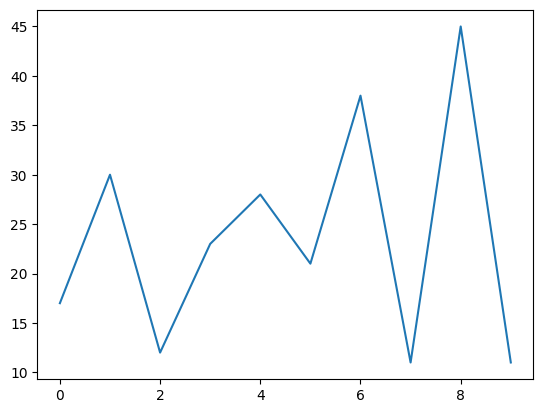

Testing for 10 episodes
Episode:1,return: 8.0
Episode:2,return: 10.0
Episode:3,return: 8.0
Episode:4,return: 9.0
Episode:5,return: 9.0
Episode:6,return: 10.0
Episode:7,return: 8.0
Episode:8,return: 10.0
Episode:9,return: 9.0
Episode:10,return: 10.0


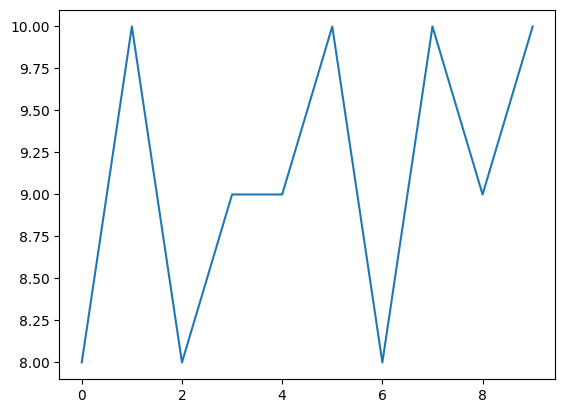

In [35]:
main(10,1)

Training for 100 episodes
1/1 [==============================] - 0s 15ms/step
Episode:1/100,return: 15.0
1/1 [==============================] - 0s 17ms/step
Episode:2/100,return: 43.0
1/1 [==============================] - 0s 16ms/step
Episode:3/100,return: 16.0
1/1 [==============================] - 0s 14ms/step
Episode:4/100,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:5/100,return: 23.0
1/1 [==============================] - 0s 13ms/step
Episode:6/100,return: 22.0
1/1 [==============================] - 0s 16ms/step
Episode:7/100,return: 13.0
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step
Episode:8/100,return: 12.0
1/1 [==============================] - 0s 17ms/step
Episode:9/100,return: 11.0
1/1 [==============================] - 0s 15ms/step
Episode:10/100,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:11/100,return: 12.0
1/1 [==============================] - 0s 23ms/step
Episode:12/100,return: 13.0
1/1 [==============================] - 0s 16ms/step
Episode:13/100,return: 13.0
1/1 [==============================] - 0s 41ms/step
Episode:14/100,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:15/100,return: 11.0
1/1 [==============================] - 0s 19ms/step
Episode:16/100,return: 11.0
1/1 [==============================] - 0s 19ms/step
Episode:17/100,return: 12.0
1/1 [==============================] - 0s 17ms/step
Episode:18/100,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:19/100,return: 18.0
1/1 [==============================] - 0s 1

1/1 [==============================] - 0s 15ms/step
Episode:21/100,return: 20.0
1/1 [==============================] - 0s 16ms/step
Episode:22/100,return: 12.0
1/1 [==============================] - 0s 14ms/step
Episode:23/100,return: 18.0
1/1 [==============================] - 0s 15ms/step
Episode:24/100,return: 12.0
1/1 [==============================] - 0s 15ms/step
Episode:25/100,return: 12.0
1/1 [==============================] - 0s 26ms/step
Episode:26/100,return: 8.0
1/1 [==============================] - 0s 16ms/step
Episode:27/100,return: 12.0
1/1 [==============================] - 0s 21ms/step
Episode:28/100,return: 22.0
1/1 [==============================] - 0s 23ms/step
Episode:29/100,return: 23.0
1/1 [==============================] - 0s 22ms/step
Episode:30/100,return: 9.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 20ms/step
Episode:31/100,return: 37.0
1/1 [==============================] - 0s 21ms/step
Episode:32/100,return: 19.0
1/1 [==============================] - 0s 17ms/step
Episode:33/100,return: 56.0
1/1 [==============================] - 0s 24ms/step
Episode:34/100,return: 23.0
1/1 [==============================] - 0s 20ms/step
Episode:35/100,return: 14.0
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step
Episode:36/100,return: 22.0
1/1 [==============================] - 0s 23ms/step
Episode:37/100,return: 11.0
1/1 [==============================] - 0s 17ms/step
Episode:38/100,return: 15.0
1/1 [==============================] - 0s 17ms/step
Episode:39/100,return: 9.0
1/1 [==============================] - 0s 79ms/step
Episode:40/100,return: 33.0
1/1 [==============================] - 0s 16ms/step
Episode:41/100,return: 20.0
1/1 [==============================] - 0s 16ms/step
Episode:42/100,return: 12.0
1/1 [==============================] - 0s 31ms/step
Episode:43/100,return: 13.0
1/1 [==============================] - 0s 20ms/step
Episode:44/100,return: 20.0
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step
Episode:45/100,return: 15.0
1/1 [==============================] - 0s 16ms/step
Episode:46/100,return: 14.0
1/1 [==============================] - 0s 15ms/step
Episode:47/100,return: 13.0
1/1 [==============================] - 0s 19ms/step
Episode:48/100,return: 18.0
1/1 [==============================] - 0s 19ms/step
Episode:49/100,return: 12.0
1/1 [==============================] - 0s 16ms/step
Episode:50/100,return: 15.0
1/1 [==============================] - 0s 16ms/step
Episode:51/100,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:52/100,return: 15.0
1/1 [==============================] - 0s 17ms/step
Episode:53/100,return: 15.0
1/1 [==============================] - 0s 16ms/step
Episode:54/100,return: 11.0
1/1 [==============================] - 0s 13ms/step
Episode:55/100,return: 9.0
1/1 [==============================] - 0s 13ms/step
Episode:56/100,return: 10.0
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 16ms/step
Episode:57/100,return: 20.0
1/1 [==============================] - 0s 14ms/step
Episode:58/100,return: 16.0
1/1 [==============================] - 0s 16ms/step
Episode:59/100,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:60/100,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:61/100,return: 12.0
1/1 [==============================] - 0s 17ms/step
Episode:62/100,return: 17.0
1/1 [==============================] - 0s 19ms/step
Episode:63/100,return: 11.0
1/1 [==============================] - 0s 21ms/step
Episode:64/100,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:65/100,return: 11.0
1/1 [==============================] - 0s 21ms/step
Episode:66/100,return: 20.0
1/1 [==============================] - 0s 20ms/step
Episode:67/100,return: 9.0
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 14ms/step
Episode:68/100,return: 14.0
1/1 [==============================] - 0s 19ms/step
Episode:69/100,return: 16.0
1/1 [==============================] - 0s 17ms/step
Episode:70/100,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:71/100,return: 12.0
1/1 [==============================] - 0s 23ms/step
Episode:72/100,return: 12.0
1/1 [==============================] - 0s 15ms/step
Episode:73/100,return: 10.0
1/1 [==============================] - 0s 32ms/step
Episode:74/100,return: 11.0
1/1 [==============================] - 0s 15ms/step
Episode:75/100,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:76/100,return: 12.0
1/1 [==============================] - 0s 15ms/step
Episode:77/100,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:78/100,return: 17.0
1/1 [==============================] - 0s 14ms/step
Episode:79/100,return: 15.0
1/1 [==============================] - 0

1/1 [==============================] - 0s 17ms/step
Episode:80/100,return: 16.0
1/1 [==============================] - 0s 18ms/step
Episode:81/100,return: 12.0
1/1 [==============================] - 0s 21ms/step
Episode:82/100,return: 16.0
1/1 [==============================] - 0s 21ms/step
Episode:83/100,return: 11.0
1/1 [==============================] - 0s 19ms/step
Episode:84/100,return: 15.0
1/1 [==============================] - 0s 16ms/step
Episode:85/100,return: 12.0
1/1 [==============================] - 0s 17ms/step
Episode:86/100,return: 21.0
1/1 [==============================] - 0s 17ms/step
Episode:87/100,return: 12.0
1/1 [==============================] - 0s 16ms/step
Episode:88/100,return: 20.0
1/1 [==============================] - 0s 17ms/step
Episode:89/100,return: 17.0
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
Episode:90/100,return: 13.0
1/1 [==============================] - 0s 15ms/step
Episode:91/100,return: 11.0
1/1 [==============================] - 0s 17ms/step
Episode:92/100,return: 9.0
1/1 [==============================] - 0s 14ms/step
Episode:93/100,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:94/100,return: 12.0
1/1 [==============================] - 0s 21ms/step
Episode:95/100,return: 13.0
1/1 [==============================] - 0s 16ms/step
Episode:96/100,return: 9.0
1/1 [==============================] - 0s 101ms/step
Episode:97/100,return: 8.0
1/1 [==============================] - 0s 18ms/step
Episode:98/100,return: 11.0
1/1 [==============================] - 0s 15ms/step
Episode:99/100,return: 10.0
1/1 [==============================] - 0s 26ms/step
Episode:100/100,return: 11.0


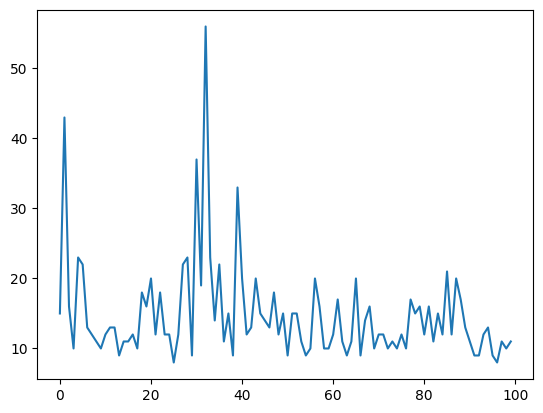

Testing for 10 episodes
Episode:1,return: 9.0
Episode:2,return: 10.0
Episode:3,return: 9.0
Episode:4,return: 10.0
Episode:5,return: 10.0
Episode:6,return: 10.0
Episode:7,return: 9.0
Episode:8,return: 9.0
Episode:9,return: 10.0
Episode:10,return: 8.0


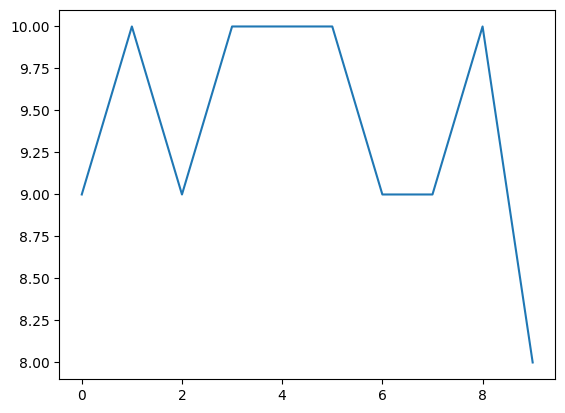

In [36]:
main(100,1)

Training for 100 episodes
1/1 [==============================] - 0s 18ms/step
Episode:1/100,return: 35.0
1/1 [==============================] - 0s 13ms/step
Episode:2/100,return: 21.0
1/1 [==============================] - 0s 17ms/step
Episode:3/100,return: 24.0
1/1 [==============================] - 0s 19ms/step
Episode:4/100,return: 12.0
1/1 [==============================] - 0s 18ms/step
Episode:5/100,return: 15.0
1/1 [==============================] - 0s 16ms/step
Episode:6/100,return: 24.0
1/1 [==============================] - 0s 16ms/step
Episode:7/100,return: 22.0


1/1 [==============================] - 0s 17ms/step
Episode:8/100,return: 22.0
1/1 [==============================] - 0s 15ms/step
Episode:9/100,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:10/100,return: 14.0
1/1 [==============================] - 0s 16ms/step
Episode:11/100,return: 31.0
1/1 [==============================] - 0s 17ms/step
Episode:12/100,return: 12.0
1/1 [==============================] - 0s 18ms/step
Episode:13/100,return: 14.0
1/1 [==============================] - 0s 18ms/step
Episode:14/100,return: 24.0
1/1 [==============================] - 0s 17ms/step
Episode:15/100,return: 27.0


1/1 [==============================] - 0s 16ms/step
Episode:16/100,return: 35.0
1/1 [==============================] - 0s 22ms/step
Episode:17/100,return: 18.0
1/1 [==============================] - 0s 18ms/step
Episode:18/100,return: 16.0
1/1 [==============================] - 0s 18ms/step
Episode:19/100,return: 18.0
1/1 [==============================] - 0s 17ms/step
Episode:20/100,return: 11.0
1/1 [==============================] - 0s 17ms/step
Episode:21/100,return: 12.0
1/1 [==============================] - 0s 17ms/step
Episode:22/100,return: 18.0
1/1 [==============================] - 0s 18ms/step
Episode:23/100,return: 20.0
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step
Episode:24/100,return: 19.0
1/1 [==============================] - 0s 17ms/step
Episode:25/100,return: 12.0
1/1 [==============================] - 0s 18ms/step
Episode:26/100,return: 23.0
1/1 [==============================] - 0s 19ms/step
Episode:27/100,return: 15.0
1/1 [==============================] - 0s 16ms/step
Episode:28/100,return: 25.0
1/1 [==============================] - 0s 14ms/step
Episode:29/100,return: 19.0
1/1 [==============================] - 0s 11ms/step
Episode:30/100,return: 26.0
1/1 [==============================] - 0s 12ms/step
Episode:31/100,return: 16.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 17ms/step
Episode:32/100,return: 60.0
1/1 [==============================] - 0s 16ms/step
Episode:33/100,return: 14.0
1/1 [==============================] - 0s 17ms/step
Episode:34/100,return: 30.0
1/1 [==============================] - 0s 12ms/step
Episode:35/100,return: 48.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step
Episode:36/100,return: 13.0
1/1 [==============================] - 0s 12ms/step
Episode:37/100,return: 11.0
1/1 [==============================] - 0s 12ms/step
Episode:38/100,return: 10.0
1/1 [==============================] - 0s 12ms/step
Episode:39/100,return: 30.0
1/1 [==============================] - 0s 13ms/step
Episode:40/100,return: 24.0
1/1 [==============================] - 0s 13ms/step
Episode:41/100,return: 16.0
1/1 [==============================] - 0s 14ms/step
Episode:42/100,return: 18.0
1/1 [==============================] - 0s 12ms/step
Episode:43/100,return: 15.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step
Episode:44/100,return: 26.0
1/1 [==============================] - 0s 15ms/step
Episode:45/100,return: 17.0
1/1 [==============================] - 0s 12ms/step
Episode:46/100,return: 19.0
1/1 [==============================] - 0s 12ms/step
Episode:47/100,return: 12.0
1/1 [==============================] - 0s 12ms/step
Episode:48/100,return: 19.0
1/1 [==============================] - 0s 13ms/step
Episode:49/100,return: 40.0
1/1 [==============================] - 0s 13ms/step
Episode:50/100,return: 14.0
1/1 [==============================] - 0s 12ms/step
Episode:51/100,return: 16.0
1/1 [==============================] - 0s 12ms/step
Episode:52/100,return: 11.0


1/1 [==============================] - 0s 14ms/step
Episode:53/100,return: 14.0
1/1 [==============================] - 0s 14ms/step
Episode:54/100,return: 18.0
1/1 [==============================] - 0s 13ms/step
Episode:55/100,return: 37.0
1/1 [==============================] - 0s 12ms/step
Episode:56/100,return: 9.0
1/1 [==============================] - 0s 12ms/step
Episode:57/100,return: 20.0
1/1 [==============================] - 0s 12ms/step
Episode:58/100,return: 18.0
1/1 [==============================] - 0s 12ms/step
Episode:59/100,return: 14.0
1/1 [==============================] - 0s 12ms/step
Episode:60/100,return: 15.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:61/100,return: 13.0
1/1 [==============================] - 0s 13ms/step
Episode:62/100,return: 14.0
1/1 [==============================] - 0s 14ms/step
Episode:63/100,return: 25.0
1/1 [==============================] - 0s 14ms/step
Episode:64/100,return: 39.0
1/1 [==============================] - 0s 12ms/step
Episode:65/100,return: 38.0
1/1 [==============================] - 0s 12ms/step
Episode:66/100,return: 18.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
Episode:67/100,return: 25.0
1/1 [==============================] - 0s 13ms/step
Episode:68/100,return: 15.0
1/1 [==============================] - 0s 12ms/step
Episode:69/100,return: 16.0
1/1 [==============================] - 0s 13ms/step
Episode:70/100,return: 43.0
1/1 [==============================] - 0s 13ms/step
Episode:71/100,return: 16.0
1/1 [==============================] - 0s 13ms/step
Episode:72/100,return: 17.0
1/1 [==============================] - 0s 12ms/step
Episode:73/100,return: 19.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:74/100,return: 44.0
1/1 [==============================] - 0s 13ms/step
Episode:75/100,return: 36.0
1/1 [==============================] - 0s 13ms/step
Episode:76/100,return: 11.0
1/1 [==============================] - 0s 12ms/step
Episode:77/100,return: 12.0
1/1 [==============================] - 0s 13ms/step
Episode:78/100,return: 30.0
1/1 [==============================] - 0s 13ms/step
Episode:79/100,return: 19.0
1/1 [==============================] - 0s 15ms/step
Episode:80/100,return: 18.0


1/1 [==============================] - 0s 15ms/step
Episode:81/100,return: 12.0
1/1 [==============================] - 0s 14ms/step
Episode:82/100,return: 18.0
1/1 [==============================] - 0s 16ms/step
Episode:83/100,return: 30.0
1/1 [==============================] - 0s 17ms/step
Episode:84/100,return: 11.0
1/1 [==============================] - 0s 17ms/step
Episode:85/100,return: 14.0
1/1 [==============================] - 0s 17ms/step
Episode:86/100,return: 17.0
1/1 [==============================] - 0s 15ms/step
Episode:87/100,return: 28.0
1/1 [==============================] - 0s 17ms/step
Episode:88/100,return: 21.0
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step
Episode:89/100,return: 18.0
1/1 [==============================] - 0s 23ms/step
Episode:90/100,return: 26.0
1/1 [==============================] - 0s 18ms/step
Episode:91/100,return: 14.0
1/1 [==============================] - 0s 16ms/step
Episode:92/100,return: 36.0
1/1 [==============================] - 0s 17ms/step
Episode:93/100,return: 42.0
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
Episode:94/100,return: 24.0
1/1 [==============================] - 0s 17ms/step
Episode:95/100,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:96/100,return: 11.0
1/1 [==============================] - 0s 17ms/step
Episode:97/100,return: 17.0
1/1 [==============================] - 0s 15ms/step
Episode:98/100,return: 12.0
1/1 [==============================] - 0s 23ms/step
Episode:99/100,return: 42.0
1/1 [==============================] - 0s 16ms/step
Episode:100/100,return: 40.0


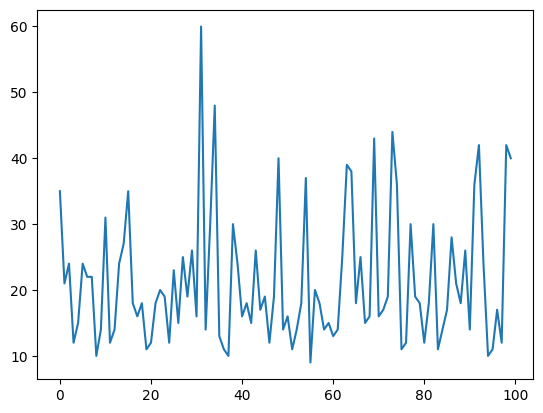

Testing for 10 episodes
Episode:1,return: 8.0
Episode:2,return: 10.0
Episode:3,return: 9.0
Episode:4,return: 9.0
Episode:5,return: 9.0
Episode:6,return: 10.0
Episode:7,return: 9.0
Episode:8,return: 10.0
Episode:9,return: 9.0
Episode:10,return: 10.0


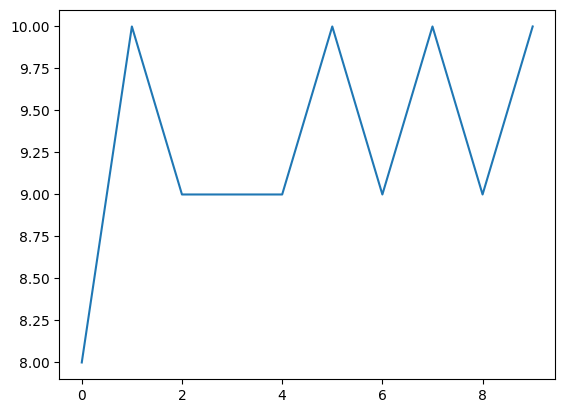

In [29]:
main(100,2)

In [ ]:
main(300,1)

In [ ]:
main(300,2)

In [ ]:
main(500,3)

Training for 1000 episodes
1/1 [==============================] - 0s 16ms/step
Episode:1/1000,return: 25.0
1/1 [==============================] - 0s 17ms/step
Episode:2/1000,return: 13.0
1/1 [==============================] - 0s 26ms/step
Episode:3/1000,return: 69.0
1/1 [==============================] - 0s 20ms/step
Episode:4/1000,return: 23.0
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
Episode:5/1000,return: 39.0
1/1 [==============================] - 0s 18ms/step
Episode:6/1000,return: 14.0
1/1 [==============================] - 0s 19ms/step
Episode:7/1000,return: 76.0
1/1 [==============================] - 0s 20ms/step
Episode:8/1000,return: 35.0
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step
Episode:9/1000,return: 22.0
1/1 [==============================] - 0s 17ms/step
Episode:10/1000,return: 16.0
1/1 [==============================] - 0s 18ms/step
Episode:11/1000,return: 18.0
1/1 [==============================] - 0s 26ms/step
Episode:12/1000,return: 13.0
1/1 [==============================] - 0s 21ms/step
Episode:13/1000,return: 12.0
1/1 [==============================] - 0s 14ms/step
Episode:14/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:15/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:16/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:17/1000,return: 16.0
1/1 [==============================] - 0s 14ms/step
Episode:18/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:19/1000,return: 18.0
1/1 [==============================] - 0s 17ms/step
Episode:20/1000,return: 13.0


1/1 [==============================] - 0s 16ms/step
Episode:21/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:22/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:23/1000,return: 20.0
1/1 [==============================] - 0s 16ms/step
Episode:24/1000,return: 14.0
1/1 [==============================] - 0s 16ms/step
Episode:25/1000,return: 14.0
1/1 [==============================] - 0s 16ms/step
Episode:26/1000,return: 19.0
1/1 [==============================] - 0s 15ms/step
Episode:27/1000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:28/1000,return: 11.0
1/1 [==============================] - 0s 17ms/step
Episode:29/1000,return: 35.0
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
Episode:30/1000,return: 21.0
1/1 [==============================] - 0s 19ms/step
Episode:31/1000,return: 36.0
1/1 [==============================] - 0s 14ms/step
Episode:32/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:33/1000,return: 24.0
1/1 [==============================] - 0s 18ms/step
Episode:34/1000,return: 14.0
1/1 [==============================] - 0s 18ms/step
Episode:35/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:36/1000,return: 16.0
1/1 [==============================] - 0s 35ms/step
Episode:37/1000,return: 18.0
1/1 [==============================] - 0s 13ms/step
Episode:38/1000,return: 15.0


1/1 [==============================] - 0s 26ms/step
Episode:39/1000,return: 16.0
1/1 [==============================] - 0s 18ms/step
Episode:40/1000,return: 21.0
1/1 [==============================] - 0s 14ms/step
Episode:41/1000,return: 13.0
1/1 [==============================] - 0s 16ms/step
Episode:42/1000,return: 16.0
1/1 [==============================] - 0s 15ms/step
Episode:43/1000,return: 24.0
1/1 [==============================] - 0s 14ms/step
Episode:44/1000,return: 22.0
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
Episode:45/1000,return: 43.0
1/1 [==============================] - 0s 17ms/step
Episode:46/1000,return: 13.0
1/1 [==============================] - 0s 14ms/step
Episode:47/1000,return: 49.0
1/1 [==============================] - 0s 16ms/step
Episode:48/1000,return: 33.0
1/1 [==============================] - 0s 14ms/step
Episode:49/1000,return: 31.0
1/1 [==============================] - 0s 15ms/step
Episode:50/1000,return: 15.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 17ms/step
Episode:51/1000,return: 18.0
1/1 [==============================] - 0s 19ms/step
Episode:52/1000,return: 14.0
1/1 [==============================] - 0s 14ms/step
Episode:53/1000,return: 18.0
1/1 [==============================] - 0s 15ms/step
Episode:54/1000,return: 18.0
1/1 [==============================] - 0s 15ms/step
Episode:55/1000,return: 38.0
1/1 [==============================] - 0s 18ms/step
Episode:56/1000,return: 14.0
1/1 [==============================] - 0s 17ms/step
Episode:57/1000,return: 26.0
1/1 [==============================] - 0s 16ms/step
Episode:58/1000,return: 9.0
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 14ms/step
Episode:59/1000,return: 19.0
1/1 [==============================] - 0s 16ms/step
Episode:60/1000,return: 17.0
1/1 [==============================] - 0s 16ms/step
Episode:61/1000,return: 34.0
1/1 [==============================] - 0s 15ms/step
Episode:62/1000,return: 23.0
1/1 [==============================] - 0s 21ms/step
Episode:63/1000,return: 16.0
1/1 [==============================] - 0s 22ms/step
Episode:64/1000,return: 37.0
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 23ms/step
Episode:65/1000,return: 74.0
1/1 [==============================] - 0s 18ms/step
Episode:66/1000,return: 11.0
1/1 [==============================] - 0s 18ms/step
Episode:67/1000,return: 19.0
1/1 [==============================] - 0s 15ms/step
Episode:68/1000,return: 12.0
1/1 [==============================] - 0s 23ms/step
Episode:69/1000,return: 44.0
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 15ms/step
Episode:70/1000,return: 30.0
1/1 [==============================] - 0s 14ms/step
Episode:71/1000,return: 30.0
1/1 [==============================] - 0s 18ms/step
Episode:72/1000,return: 23.0
1/1 [==============================] - 0s 15ms/step
Episode:73/1000,return: 17.0
1/1 [==============================] - 0s 17ms/step
Episode:74/1000,return: 23.0
1/1 [==============================] - 0s 16ms/step
Episode:75/1000,return: 16.0
1/1 [==============================] - 0s 17ms/step
Episode:76/1000,return: 19.0
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 22ms/step
Episode:77/1000,return: 26.0
1/1 [==============================] - 0s 16ms/step
Episode:78/1000,return: 17.0
1/1 [==============================] - 0s 16ms/step
Episode:79/1000,return: 12.0
1/1 [==============================] - 0s 19ms/step
Episode:80/1000,return: 28.0
1/1 [==============================] - 0s 27ms/step
Episode:81/1000,return: 27.0
1/1 [==============================] - 0s 15ms/step
Episode:82/1000,return: 30.0
1/1 [==============================] - 0s 17ms/step
Episode:83/1000,return: 20.0


1/1 [==============================] - 0s 17ms/step
Episode:84/1000,return: 36.0
1/1 [==============================] - 0s 17ms/step
Episode:85/1000,return: 13.0
1/1 [==============================] - 0s 15ms/step
Episode:86/1000,return: 26.0
1/1 [==============================] - 0s 17ms/step
Episode:87/1000,return: 23.0
1/1 [==============================] - 0s 25ms/step
Episode:88/1000,return: 11.0
1/1 [==============================] - 0s 17ms/step
Episode:89/1000,return: 15.0
1/1 [==============================] - 0s 15ms/step
Episode:90/1000,return: 19.0
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 14ms/step
Episode:91/1000,return: 26.0
1/1 [==============================] - 0s 15ms/step
Episode:92/1000,return: 23.0
1/1 [==============================] - 0s 14ms/step
Episode:93/1000,return: 30.0
1/1 [==============================] - 0s 14ms/step
Episode:94/1000,return: 19.0
1/1 [==============================] - 0s 20ms/step
Episode:95/1000,return: 19.0
1/1 [==============================] - 0s 17ms/step
Episode:96/1000,return: 18.0
1/1 [==============================] - 0s 19ms/step
Episode:97/1000,return: 15.0
1/1 [==============================] - 0s 17ms/step
Episode:98/1000,return: 11.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step
Episode:99/1000,return: 11.0
1/1 [==============================] - 0s 17ms/step
Episode:100/1000,return: 12.0
1/1 [==============================] - 0s 17ms/step
Episode:101/1000,return: 22.0
1/1 [==============================] - 0s 17ms/step
Episode:102/1000,return: 12.0
1/1 [==============================] - 0s 20ms/step
Episode:103/1000,return: 13.0
1/1 [==============================] - 0s 16ms/step
Episode:104/1000,return: 11.0
1/1 [==============================] - 0s 19ms/step
Episode:105/1000,return: 12.0
1/1 [==============================] - 0s 15ms/step
Episode:106/1000,return: 16.0
1/1 [==============================] - 0s 17ms/step
Episode:107/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:108/1000,return: 17.0
1/1 [==============================] - 0s 16ms/step
Episode:109/1000,return: 11.0
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 15ms/step
Episode:110/1000,return: 11.0
1/1 [==============================] - 0s 22ms/step
Episode:111/1000,return: 15.0
1/1 [==============================] - 0s 18ms/step
Episode:112/1000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:113/1000,return: 13.0
1/1 [==============================] - 0s 22ms/step
Episode:114/1000,return: 13.0
1/1 [==============================] - 0s 18ms/step
Episode:115/1000,return: 23.0
1/1 [==============================] - 0s 20ms/step
Episode:116/1000,return: 15.0
1/1 [==============================] - 0s 19ms/step
Episode:117/1000,return: 12.0
1/1 [==============================] - 0s 24ms/step
Episode:118/1000,return: 11.0
1/1 [==============================] - 0s 16ms/step
Episode:119/1000,return: 13.0
1/1 [==============================] - 0s 18ms/step
Episode:120/1000,return: 11.0
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 17ms/step
Episode:121/1000,return: 11.0
1/1 [==============================] - 0s 24ms/step
Episode:122/1000,return: 12.0
1/1 [==============================] - 0s 24ms/step
Episode:123/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:124/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:125/1000,return: 11.0
1/1 [==============================] - 0s 15ms/step
Episode:126/1000,return: 13.0
1/1 [==============================] - 0s 15ms/step
Episode:127/1000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:128/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:129/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:130/1000,return: 10.0
1/1 [==============================] - 0s 22ms/step
Episode:131/1000,return: 11.0
1/1 [==============================] - 0s 17ms/step
Episode:132/1000,return: 9.0
1/1 [=============

1/1 [==============================] - 0s 16ms/step
Episode:136/1000,return: 9.0
1/1 [==============================] - 0s 20ms/step
Episode:137/1000,return: 8.0
1/1 [==============================] - 0s 17ms/step
Episode:138/1000,return: 8.0
1/1 [==============================] - 0s 16ms/step
Episode:139/1000,return: 15.0
1/1 [==============================] - 0s 16ms/step
Episode:140/1000,return: 11.0
1/1 [==============================] - 0s 18ms/step
Episode:141/1000,return: 9.0
1/1 [==============================] - 0s 14ms/step
Episode:142/1000,return: 11.0
1/1 [==============================] - 0s 14ms/step
Episode:143/1000,return: 14.0
1/1 [==============================] - 0s 16ms/step
Episode:144/1000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:145/1000,return: 9.0
1/1 [==============================] - 0s 18ms/step
Episode:146/1000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:147/1000,return: 10.0
1/1 [================

1/1 [==============================] - 0s 17ms/step
Episode:150/1000,return: 11.0
1/1 [==============================] - 0s 19ms/step
Episode:151/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:152/1000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:153/1000,return: 8.0
1/1 [==============================] - 0s 16ms/step
Episode:154/1000,return: 9.0
1/1 [==============================] - 0s 14ms/step
Episode:155/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:156/1000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:157/1000,return: 9.0
1/1 [==============================] - 0s 14ms/step
Episode:158/1000,return: 12.0
1/1 [==============================] - 0s 14ms/step
Episode:159/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:160/1000,return: 8.0
1/1 [==============================] - 0s 16ms/step
Episode:161/1000,return: 10.0
1/1 [================

Episode:165/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:166/1000,return: 9.0
1/1 [==============================] - 0s 143ms/step
Episode:167/1000,return: 13.0
1/1 [==============================] - 0s 16ms/step
Episode:168/1000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:169/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:170/1000,return: 10.0
1/1 [==============================] - 0s 19ms/step
Episode:171/1000,return: 9.0
1/1 [==============================] - 0s 19ms/step
Episode:172/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:173/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:174/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:175/1000,return: 10.0
1/1 [==============================] - 0s 19ms/step
Episode:176/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:177/1000,ret

1/1 [==============================] - 0s 20ms/step
Episode:180/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:181/1000,return: 9.0
1/1 [==============================] - 0s 18ms/step
Episode:182/1000,return: 11.0
1/1 [==============================] - 0s 17ms/step
Episode:183/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:184/1000,return: 8.0
1/1 [==============================] - 0s 18ms/step
Episode:185/1000,return: 10.0
1/1 [==============================] - 0s 19ms/step
Episode:186/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:187/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:188/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:189/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:190/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:191/1000,return: 9.0
1/1 [===============

1/1 [==============================] - 0s 17ms/step
Episode:196/1000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:197/1000,return: 8.0
1/1 [==============================] - 0s 18ms/step
Episode:198/1000,return: 12.0
1/1 [==============================] - 0s 18ms/step
Episode:199/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:200/1000,return: 9.0
1/1 [==============================] - 0s 21ms/step
Episode:201/1000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:202/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:203/1000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:204/1000,return: 12.0
1/1 [==============================] - 0s 16ms/step
Episode:205/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:206/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:207/1000,return: 10.0
1/1 [================

1/1 [==============================] - 0s 15ms/step
Episode:211/1000,return: 11.0
1/1 [==============================] - 0s 23ms/step
Episode:212/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:213/1000,return: 9.0
1/1 [==============================] - 0s 18ms/step
Episode:214/1000,return: 9.0
1/1 [==============================] - 0s 18ms/step
Episode:215/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:216/1000,return: 9.0
1/1 [==============================] - 0s 14ms/step
Episode:217/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:218/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:219/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:220/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:221/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:222/1000,return: 9.0
1/1 [===================

1/1 [==============================] - 0s 14ms/step
Episode:227/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:228/1000,return: 8.0
1/1 [==============================] - 0s 16ms/step
Episode:229/1000,return: 9.0
1/1 [==============================] - 0s 14ms/step
Episode:230/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:231/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:232/1000,return: 12.0
1/1 [==============================] - 0s 22ms/step
Episode:233/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:234/1000,return: 8.0
1/1 [==============================] - 0s 15ms/step
Episode:235/1000,return: 8.0
1/1 [==============================] - 0s 15ms/step
Episode:236/1000,return: 8.0
1/1 [==============================] - 0s 14ms/step
Episode:237/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:238/1000,return: 10.0
1/1 [===================

1/1 [==============================] - 0s 16ms/step
Episode:242/1000,return: 11.0
1/1 [==============================] - 0s 17ms/step
Episode:243/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:244/1000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:245/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:246/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:247/1000,return: 11.0
1/1 [==============================] - 0s 16ms/step
Episode:248/1000,return: 9.0
1/1 [==============================] - 0s 14ms/step
Episode:249/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:250/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:251/1000,return: 9.0
1/1 [==============================] - 0s 19ms/step
Episode:252/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:253/1000,return: 9.0
1/1 [==================

1/1 [==============================] - 0s 16ms/step
Episode:258/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:259/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:260/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:261/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:262/1000,return: 8.0
1/1 [==============================] - 0s 16ms/step
Episode:263/1000,return: 8.0
1/1 [==============================] - 0s 16ms/step
Episode:264/1000,return: 8.0
1/1 [==============================] - 0s 27ms/step
Episode:265/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:266/1000,return: 11.0
1/1 [==============================] - 0s 14ms/step
Episode:267/1000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:268/1000,return: 9.0
1/1 [==============================] - 0s 20ms/step
Episode:269/1000,return: 8.0
1/1 [=================

1/1 [==============================] - 0s 19ms/step
Episode:274/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:275/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:276/1000,return: 11.0
1/1 [==============================] - 0s 16ms/step
Episode:277/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:278/1000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:279/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:280/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:281/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:282/1000,return: 9.0
1/1 [==============================] - 0s 14ms/step
Episode:283/1000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:284/1000,return: 9.0
1/1 [==============================] - 0s 23ms/step
Episode:285/1000,return: 9.0
1/1 [==================

1/1 [==============================] - 0s 14ms/step
Episode:289/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:290/1000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:291/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:292/1000,return: 11.0
1/1 [==============================] - 0s 18ms/step
Episode:293/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:294/1000,return: 8.0
1/1 [==============================] - 0s 22ms/step
Episode:295/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:296/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:297/1000,return: 11.0
1/1 [==============================] - 0s 16ms/step
Episode:298/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:299/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:300/1000,return: 9.0
1/1 [==================

1/1 [==============================] - 0s 16ms/step
Episode:305/1000,return: 9.0
1/1 [==============================] - 0s 18ms/step
Episode:306/1000,return: 8.0
1/1 [==============================] - 0s 17ms/step
Episode:307/1000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:308/1000,return: 8.0
1/1 [==============================] - 0s 16ms/step
Episode:309/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:310/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:311/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:312/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:313/1000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:314/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:315/1000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:316/1000,return: 10.0
1/1 [==================

1/1 [==============================] - 0s 20ms/step
Episode:321/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:322/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:323/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:324/1000,return: 8.0
1/1 [==============================] - 0s 17ms/step
Episode:325/1000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:326/1000,return: 8.0
1/1 [==============================] - 0s 17ms/step
Episode:327/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:328/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:329/1000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:330/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:331/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:332/1000,return: 9.0
1/1 [=================

1/1 [==============================] - 0s 17ms/step
Episode:337/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:338/1000,return: 11.0
1/1 [==============================] - 0s 18ms/step
Episode:339/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:340/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:341/1000,return: 9.0
1/1 [==============================] - 0s 20ms/step
Episode:342/1000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:343/1000,return: 9.0
1/1 [==============================] - 0s 14ms/step
Episode:344/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:345/1000,return: 9.0
1/1 [==============================] - 0s 18ms/step
Episode:346/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:347/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:348/1000,return: 10.0
1/1 [================

1/1 [==============================] - 0s 16ms/step
Episode:352/1000,return: 8.0
1/1 [==============================] - 0s 17ms/step
Episode:353/1000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:354/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:355/1000,return: 14.0
1/1 [==============================] - 0s 14ms/step
Episode:356/1000,return: 8.0
1/1 [==============================] - 0s 20ms/step
Episode:357/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:358/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:359/1000,return: 9.0
1/1 [==============================] - 0s 18ms/step
Episode:360/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:361/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:362/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:363/1000,return: 9.0
1/1 [===================

1/1 [==============================] - 0s 17ms/step
Episode:368/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:369/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:370/1000,return: 9.0
1/1 [==============================] - 0s 20ms/step
Episode:371/1000,return: 8.0
1/1 [==============================] - 0s 17ms/step
Episode:372/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:373/1000,return: 9.0
1/1 [==============================] - 0s 19ms/step
Episode:374/1000,return: 9.0
1/1 [==============================] - 0s 18ms/step
Episode:375/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:376/1000,return: 9.0
1/1 [==============================] - 0s 18ms/step
Episode:377/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:378/1000,return: 8.0
1/1 [==============================] - 0s 15ms/step
Episode:379/1000,return: 9.0
1/1 [======================

1/1 [==============================] - 0s 17ms/step
Episode:384/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:385/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:386/1000,return: 9.0
1/1 [==============================] - 0s 14ms/step
Episode:387/1000,return: 8.0
1/1 [==============================] - 0s 14ms/step
Episode:388/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:389/1000,return: 11.0
1/1 [==============================] - 0s 15ms/step
Episode:390/1000,return: 8.0
1/1 [==============================] - 0s 16ms/step
Episode:391/1000,return: 8.0
1/1 [==============================] - 0s 14ms/step
Episode:392/1000,return: 9.0
1/1 [==============================] - 0s 14ms/step
Episode:393/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:394/1000,return: 8.0
1/1 [==============================] - 0s 18ms/step
Episode:395/1000,return: 8.0
1/1 [===================

1/1 [==============================] - 0s 17ms/step
Episode:400/1000,return: 16.0
1/1 [==============================] - 0s 14ms/step
Episode:401/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:402/1000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:403/1000,return: 9.0
1/1 [==============================] - 0s 23ms/step
Episode:404/1000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:405/1000,return: 8.0
1/1 [==============================] - 0s 18ms/step
Episode:406/1000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:407/1000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:408/1000,return: 9.0
1/1 [==============================] - 0s 14ms/step
Episode:409/1000,return: 9.0
1/1 [==============================] - 0s 14ms/step
Episode:410/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:411/1000,return: 9.0
1/1 [=================

1/1 [==============================] - 0s 14ms/step
Episode:415/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:416/1000,return: 12.0
1/1 [==============================] - 0s 15ms/step
Episode:417/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:418/1000,return: 11.0
1/1 [==============================] - 0s 15ms/step
Episode:419/1000,return: 9.0
1/1 [==============================] - 0s 18ms/step
Episode:420/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:421/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:422/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:423/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:424/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:425/1000,return: 11.0
1/1 [==============================] - 0s 14ms/step
Episode:426/1000,return: 9.0
1/1 [==============

1/1 [==============================] - 0s 16ms/step
Episode:430/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:431/1000,return: 11.0
1/1 [==============================] - 0s 15ms/step
Episode:432/1000,return: 8.0
1/1 [==============================] - 0s 18ms/step
Episode:433/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:434/1000,return: 9.0
1/1 [==============================] - 0s 21ms/step
Episode:435/1000,return: 8.0
1/1 [==============================] - 0s 15ms/step
Episode:436/1000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:437/1000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:438/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:439/1000,return: 10.0
1/1 [==============================] - 0s 20ms/step
Episode:440/1000,return: 8.0
1/1 [==============================] - 0s 19ms/step
Episode:441/1000,return: 9.0
1/1 [================

1/1 [==============================] - 0s 19ms/step
Episode:446/1000,return: 12.0
1/1 [==============================] - 0s 15ms/step
Episode:447/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:448/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:449/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:450/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:451/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:452/1000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:453/1000,return: 11.0
1/1 [==============================] - 0s 14ms/step
Episode:454/1000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:455/1000,return: 9.0
1/1 [==============================] - 0s 21ms/step
Episode:456/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:457/1000,return: 8.0
1/1 [=================

1/1 [==============================] - 0s 18ms/step
Episode:461/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:462/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:463/1000,return: 8.0
1/1 [==============================] - 0s 15ms/step
Episode:464/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:465/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:466/1000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:467/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:468/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:469/1000,return: 11.0
1/1 [==============================] - 0s 17ms/step
Episode:470/1000,return: 8.0
1/1 [==============================] - 0s 14ms/step
Episode:471/1000,return: 12.0
1/1 [==============================] - 0s 15ms/step
Episode:472/1000,return: 8.0
1/1 [================

1/1 [==============================] - 0s 14ms/step
Episode:477/1000,return: 9.0
1/1 [==============================] - 0s 19ms/step
Episode:478/1000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:479/1000,return: 13.0
1/1 [==============================] - 0s 18ms/step
Episode:480/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:481/1000,return: 8.0
1/1 [==============================] - 0s 17ms/step
Episode:482/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:483/1000,return: 8.0
1/1 [==============================] - 0s 17ms/step
Episode:484/1000,return: 10.0
1/1 [==============================] - 0s 19ms/step
Episode:485/1000,return: 10.0
1/1 [==============================] - 0s 20ms/step
Episode:486/1000,return: 9.0
1/1 [==============================] - 0s 19ms/step
Episode:487/1000,return: 10.0
1/1 [==============================] - 0s 21ms/step
Episode:488/1000,return: 9.0
1/1 [================

1/1 [==============================] - 0s 15ms/step
Episode:492/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:493/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:494/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:495/1000,return: 9.0
1/1 [==============================] - 0s 18ms/step
Episode:496/1000,return: 8.0
1/1 [==============================] - 0s 15ms/step
Episode:497/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:498/1000,return: 9.0
1/1 [==============================] - 0s 20ms/step
Episode:499/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:500/1000,return: 9.0
1/1 [==============================] - 0s 31ms/step
Episode:501/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:502/1000,return: 11.0
1/1 [==============================] - 0s 16ms/step
Episode:503/1000,return: 15.0
1/1 [==================

1/1 [==============================] - 0s 17ms/step
Episode:508/1000,return: 13.0
1/1 [==============================] - 0s 24ms/step
Episode:509/1000,return: 8.0
1/1 [==============================] - 0s 20ms/step
Episode:510/1000,return: 11.0
1/1 [==============================] - 0s 18ms/step
Episode:511/1000,return: 9.0
1/1 [==============================] - 0s 14ms/step
Episode:512/1000,return: 8.0
1/1 [==============================] - 0s 14ms/step
Episode:513/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:514/1000,return: 11.0
1/1 [==============================] - 0s 18ms/step
Episode:515/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:516/1000,return: 11.0
1/1 [==============================] - 0s 16ms/step
Episode:517/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:518/1000,return: 11.0
1/1 [==============================] - 0s 21ms/step
Episode:519/1000,return: 10.0
1/1 [===============

1/1 [==============================] - 0s 17ms/step
Episode:523/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:524/1000,return: 9.0
1/1 [==============================] - 0s 19ms/step
Episode:525/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:526/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:527/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:528/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:529/1000,return: 9.0
1/1 [==============================] - 0s 18ms/step
Episode:530/1000,return: 11.0
1/1 [==============================] - 0s 17ms/step
Episode:531/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:532/1000,return: 9.0
1/1 [==============================] - 0s 24ms/step
Episode:533/1000,return: 8.0
1/1 [==============================] - 0s 17ms/step
Episode:534/1000,return: 9.0
1/1 [====================

1/1 [==============================] - 0s 17ms/step
Episode:538/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:539/1000,return: 9.0
1/1 [==============================] - 0s 21ms/step
Episode:540/1000,return: 9.0
1/1 [==============================] - 0s 14ms/step
Episode:541/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:542/1000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:543/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:544/1000,return: 11.0
1/1 [==============================] - 0s 18ms/step
Episode:545/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:546/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:547/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:548/1000,return: 8.0
1/1 [==============================] - 0s 16ms/step
Episode:549/1000,return: 8.0
1/1 [==================

1/1 [==============================] - 0s 17ms/step
Episode:554/1000,return: 13.0
1/1 [==============================] - 0s 17ms/step
Episode:555/1000,return: 11.0
1/1 [==============================] - 0s 16ms/step
Episode:556/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:557/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:558/1000,return: 9.0
1/1 [==============================] - 0s 14ms/step
Episode:559/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:560/1000,return: 8.0
1/1 [==============================] - 0s 22ms/step
Episode:561/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:562/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:563/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:564/1000,return: 8.0
1/1 [==============================] - 0s 15ms/step
Episode:565/1000,return: 10.0
1/1 [===============

1/1 [==============================] - 0s 15ms/step
Episode:569/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:570/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:571/1000,return: 10.0
1/1 [==============================] - 0s 20ms/step
Episode:572/1000,return: 8.0
1/1 [==============================] - 0s 19ms/step
Episode:573/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:574/1000,return: 9.0
1/1 [==============================] - 0s 13ms/step
Episode:575/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:576/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:577/1000,return: 8.0
1/1 [==============================] - 0s 14ms/step
Episode:578/1000,return: 8.0
1/1 [==============================] - 0s 16ms/step
Episode:579/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:580/1000,return: 10.0
1/1 [=================

1/1 [==============================] - 0s 20ms/step
Episode:585/1000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:586/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:587/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:588/1000,return: 11.0
1/1 [==============================] - 0s 20ms/step
Episode:589/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:590/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:591/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:592/1000,return: 10.0
1/1 [==============================] - 0s 22ms/step
Episode:593/1000,return: 9.0
1/1 [==============================] - 0s 18ms/step
Episode:594/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:595/1000,return: 9.0
1/1 [==============================] - 0s 14ms/step
Episode:596/1000,return: 9.0
1/1 [=================

1/1 [==============================] - 0s 17ms/step
Episode:601/1000,return: 9.0
1/1 [==============================] - 0s 14ms/step
Episode:602/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:603/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:604/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:605/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:606/1000,return: 10.0
1/1 [==============================] - 0s 22ms/step
Episode:607/1000,return: 10.0
1/1 [==============================] - 0s 20ms/step
Episode:608/1000,return: 8.0
1/1 [==============================] - 0s 21ms/step
Episode:609/1000,return: 9.0
1/1 [==============================] - 0s 14ms/step
Episode:610/1000,return: 10.0
1/1 [==============================] - 0s 28ms/step
Episode:611/1000,return: 12.0
1/1 [==============================] - 0s 24ms/step
Episode:612/1000,return: 8.0
1/1 [==================

1/1 [==============================] - 0s 18ms/step
Episode:616/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:617/1000,return: 8.0
1/1 [==============================] - 0s 15ms/step
Episode:618/1000,return: 8.0
1/1 [==============================] - 0s 14ms/step
Episode:619/1000,return: 9.0
1/1 [==============================] - 0s 14ms/step
Episode:620/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:621/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:622/1000,return: 8.0
1/1 [==============================] - 0s 19ms/step
Episode:623/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:624/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:625/1000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:626/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:627/1000,return: 9.0
1/1 [==================

1/1 [==============================] - 0s 15ms/step
Episode:633/1000,return: 9.0
1/1 [==============================] - 0s 18ms/step
Episode:634/1000,return: 11.0
1/1 [==============================] - 0s 20ms/step
Episode:635/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:636/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:637/1000,return: 11.0
1/1 [==============================] - 0s 15ms/step
Episode:638/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:639/1000,return: 8.0
1/1 [==============================] - 0s 16ms/step
Episode:640/1000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:641/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:642/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:643/1000,return: 8.0
1/1 [==============================] - 0s 14ms/step
Episode:644/1000,return: 9.0
1/1 [================

1/1 [==============================] - 0s 15ms/step
Episode:648/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:649/1000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:650/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:651/1000,return: 12.0
1/1 [==============================] - 0s 16ms/step
Episode:652/1000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:653/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:654/1000,return: 9.0
1/1 [==============================] - 0s 21ms/step
Episode:655/1000,return: 8.0
1/1 [==============================] - 0s 18ms/step
Episode:656/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:657/1000,return: 10.0
1/1 [==============================] - 0s 20ms/step
Episode:658/1000,return: 9.0
1/1 [==============================] - 0s 20ms/step
Episode:659/1000,return: 10.0
1/1 [===============

1/1 [==============================] - 0s 15ms/step
Episode:664/1000,return: 8.0
1/1 [==============================] - 0s 16ms/step
Episode:665/1000,return: 10.0
1/1 [==============================] - 0s 22ms/step
Episode:666/1000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:667/1000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:668/1000,return: 12.0
1/1 [==============================] - 0s 15ms/step
Episode:669/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:670/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:671/1000,return: 9.0
1/1 [==============================] - 0s 19ms/step
Episode:672/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:673/1000,return: 9.0
1/1 [==============================] - 0s 23ms/step
Episode:674/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:675/1000,return: 9.0
1/1 [================

1/1 [==============================] - 0s 15ms/step
Episode:679/1000,return: 11.0
1/1 [==============================] - 0s 18ms/step
Episode:680/1000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:681/1000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:682/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:683/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:684/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:685/1000,return: 8.0
1/1 [==============================] - 0s 17ms/step
Episode:686/1000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:687/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:688/1000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:689/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:690/1000,return: 10.0
1/1 [==================

1/1 [==============================] - 0s 24ms/step


2022-11-22 19:15:06.455995: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 21ms/step
Episode:695/1000,return: 9.0
1/1 [==============================] - 0s 39ms/step
Episode:696/1000,return: 12.0
1/1 [==============================] - 0s 43ms/step
Episode:697/1000,return: 10.0
1/1 [==============================] - 0s 34ms/step
Episode:698/1000,return: 10.0
1/1 [==============================] - 0s 23ms/step
Episode:699/1000,return: 10.0
1/1 [==============================] - 0s 23ms/step
Episode:700/1000,return: 9.0
1/1 [==============================] - 0s 28ms/step
Episode:701/1000,return: 9.0
1/1 [==============================] - 0s 24ms/step
Episode:702/1000,return: 11.0
1/1 [==============================] - 0s 22ms/step
Episode:703/1000,return: 10.0
1/1 [==============================] - 0s 29ms/step
Episode:704/1000,return: 9.0
1/1 [==============================] - 0s 25ms/step


2022-11-22 19:15:44.607427: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 24ms/step
Episode:705/1000,return: 10.0
1/1 [==============================] - 0s 20ms/step
Episode:706/1000,return: 9.0
1/1 [==============================] - 0s 34ms/step
Episode:707/1000,return: 9.0
1/1 [==============================] - 0s 34ms/step
Episode:708/1000,return: 10.0
1/1 [==============================] - 0s 23ms/step
Episode:709/1000,return: 10.0
1/1 [==============================] - 0s 26ms/step
Episode:710/1000,return: 10.0
1/1 [==============================] - 0s 22ms/step
Episode:711/1000,return: 11.0
1/1 [==============================] - 0s 31ms/step
Episode:712/1000,return: 11.0
1/1 [==============================] - 0s 54ms/step
Episode:713/1000,return: 10.0
1/1 [==============================] - 0s 37ms/step
Episode:714/1000,return: 9.0
1/1 [==============================] - 0s 39ms/step
Episode:715/1000,return: 9.0
1/1 [==============================] - 0s 27ms/step
Episode:716/1000,return: 9.0
1/1 [================

1/1 [==============================] - 0s 74ms/step
Episode:721/1000,return: 10.0
1/1 [==============================] - 0s 59ms/step
Episode:722/1000,return: 9.0
1/1 [==============================] - 0s 27ms/step
Episode:723/1000,return: 10.0
1/1 [==============================] - 0s 59ms/step
Episode:724/1000,return: 10.0
1/1 [==============================] - 0s 36ms/step
Episode:725/1000,return: 8.0
1/1 [==============================] - 0s 29ms/step
Episode:726/1000,return: 10.0
1/1 [==============================] - 0s 26ms/step
Episode:727/1000,return: 10.0
1/1 [==============================] - 0s 103ms/step
Episode:728/1000,return: 10.0
1/1 [==============================] - 0s 29ms/step
Episode:729/1000,return: 11.0
1/1 [==============================] - 0s 26ms/step
Episode:730/1000,return: 10.0
1/1 [==============================] - 0s 32ms/step
Episode:731/1000,return: 9.0
1/1 [==============================] - 0s 24ms/step
Episode:732/1000,return: 8.0
1/1 [==============

1/1 [==============================] - 0s 36ms/step
Episode:736/1000,return: 9.0
1/1 [==============================] - 0s 29ms/step
Episode:737/1000,return: 10.0
1/1 [==============================] - 0s 39ms/step
Episode:738/1000,return: 9.0
1/1 [==============================] - 0s 28ms/step
Episode:739/1000,return: 10.0
1/1 [==============================] - 0s 27ms/step
Episode:740/1000,return: 10.0
1/1 [==============================] - 0s 26ms/step
Episode:741/1000,return: 9.0
1/1 [==============================] - 0s 30ms/step
Episode:742/1000,return: 11.0
1/1 [==============================] - 0s 32ms/step
Episode:743/1000,return: 10.0
1/1 [==============================] - 0s 21ms/step
Episode:744/1000,return: 10.0
1/1 [==============================] - 0s 25ms/step
Episode:745/1000,return: 9.0
1/1 [==============================] - 0s 39ms/step
Episode:746/1000,return: 9.0
1/1 [==============================] - 0s 31ms/step
Episode:747/1000,return: 9.0
1/1 [=================

1/1 [==============================] - 0s 55ms/step
Episode:751/1000,return: 10.0
1/1 [==============================] - 0s 50ms/step
Episode:752/1000,return: 8.0
1/1 [==============================] - 0s 41ms/step
Episode:753/1000,return: 10.0
1/1 [==============================] - 0s 31ms/step
Episode:754/1000,return: 9.0
1/1 [==============================] - 0s 26ms/step
Episode:755/1000,return: 11.0
1/1 [==============================] - 0s 50ms/step
Episode:756/1000,return: 9.0
1/1 [==============================] - 0s 28ms/step
Episode:757/1000,return: 9.0
1/1 [==============================] - 0s 52ms/step
Episode:758/1000,return: 10.0
1/1 [==============================] - 0s 23ms/step
Episode:759/1000,return: 10.0
1/1 [==============================] - 0s 25ms/step
Episode:760/1000,return: 9.0
1/1 [==============================] - 0s 24ms/step
Episode:761/1000,return: 10.0
1/1 [==============================] - 0s 43ms/step
Episode:762/1000,return: 12.0
1/1 [================

1/1 [==============================] - 0s 21ms/step
Episode:767/1000,return: 9.0
1/1 [==============================] - 0s 34ms/step
Episode:768/1000,return: 11.0
1/1 [==============================] - 0s 21ms/step
Episode:769/1000,return: 9.0
1/1 [==============================] - 0s 34ms/step
Episode:770/1000,return: 10.0
1/1 [==============================] - 0s 37ms/step
Episode:771/1000,return: 8.0
1/1 [==============================] - 0s 34ms/step
Episode:772/1000,return: 9.0
1/1 [==============================] - 0s 21ms/step
Episode:773/1000,return: 9.0
1/1 [==============================] - 0s 25ms/step
Episode:774/1000,return: 8.0
1/1 [==============================] - 0s 23ms/step
Episode:775/1000,return: 12.0
1/1 [==============================] - 0s 21ms/step
Episode:776/1000,return: 9.0
1/1 [==============================] - 0s 21ms/step
Episode:777/1000,return: 9.0
1/1 [==============================] - 0s 41ms/step
Episode:778/1000,return: 9.0
1/1 [====================

1/1 [==============================] - 0s 71ms/step
Episode:783/1000,return: 10.0
1/1 [==============================] - 0s 27ms/step
Episode:784/1000,return: 9.0
1/1 [==============================] - 0s 27ms/step
Episode:785/1000,return: 10.0
1/1 [==============================] - 0s 28ms/step
Episode:786/1000,return: 9.0
1/1 [==============================] - 0s 25ms/step
Episode:787/1000,return: 10.0
1/1 [==============================] - 0s 29ms/step
Episode:788/1000,return: 10.0
1/1 [==============================] - 0s 21ms/step
Episode:789/1000,return: 9.0
1/1 [==============================] - 0s 42ms/step
Episode:790/1000,return: 10.0
1/1 [==============================] - 0s 23ms/step
Episode:791/1000,return: 8.0
1/1 [==============================] - 0s 24ms/step
Episode:792/1000,return: 9.0
1/1 [==============================] - 0s 33ms/step
Episode:793/1000,return: 9.0
1/1 [==============================] - 0s 47ms/step
Episode:794/1000,return: 10.0
1/1 [=================

1/1 [==============================] - 0s 26ms/step
Episode:799/1000,return: 8.0
1/1 [==============================] - 0s 37ms/step
Episode:800/1000,return: 9.0
1/1 [==============================] - 0s 49ms/step
Episode:801/1000,return: 10.0
1/1 [==============================] - 0s 49ms/step
Episode:802/1000,return: 10.0
1/1 [==============================] - 0s 31ms/step
Episode:803/1000,return: 9.0
1/1 [==============================] - 0s 36ms/step
Episode:804/1000,return: 10.0
1/1 [==============================] - 0s 31ms/step
Episode:805/1000,return: 10.0
1/1 [==============================] - 0s 34ms/step
Episode:806/1000,return: 11.0
1/1 [==============================] - 0s 25ms/step
Episode:807/1000,return: 10.0
1/1 [==============================] - 0s 41ms/step
Episode:808/1000,return: 10.0
1/1 [==============================] - 0s 67ms/step
Episode:809/1000,return: 9.0
1/1 [==============================] - 0s 29ms/step
Episode:810/1000,return: 9.0
1/1 [================

1/1 [==============================] - 0s 24ms/step
Episode:814/1000,return: 10.0
1/1 [==============================] - 0s 35ms/step
Episode:815/1000,return: 8.0
1/1 [==============================] - 0s 33ms/step
Episode:816/1000,return: 10.0
1/1 [==============================] - 0s 55ms/step
Episode:817/1000,return: 9.0
1/1 [==============================] - 0s 67ms/step
Episode:818/1000,return: 8.0
1/1 [==============================] - 0s 37ms/step
Episode:819/1000,return: 8.0
1/1 [==============================] - 0s 24ms/step
Episode:820/1000,return: 9.0
1/1 [==============================] - 0s 25ms/step
Episode:821/1000,return: 10.0
1/1 [==============================] - 0s 23ms/step
Episode:822/1000,return: 10.0
1/1 [==============================] - 0s 21ms/step
Episode:823/1000,return: 9.0
1/1 [==============================] - 0s 22ms/step
Episode:824/1000,return: 10.0
1/1 [==============================] - 0s 26ms/step
Episode:825/1000,return: 9.0
1/1 [==================

1/1 [==============================] - 0s 25ms/step
Episode:830/1000,return: 10.0
1/1 [==============================] - 0s 58ms/step
Episode:831/1000,return: 9.0
1/1 [==============================] - 0s 26ms/step
Episode:832/1000,return: 11.0
1/1 [==============================] - 0s 49ms/step
Episode:833/1000,return: 10.0
1/1 [==============================] - 0s 20ms/step
Episode:834/1000,return: 9.0
1/1 [==============================] - 0s 52ms/step
Episode:835/1000,return: 9.0
1/1 [==============================] - 0s 27ms/step
Episode:836/1000,return: 8.0
1/1 [==============================] - 0s 22ms/step
Episode:837/1000,return: 9.0
1/1 [==============================] - 0s 24ms/step
Episode:838/1000,return: 10.0
1/1 [==============================] - 0s 66ms/step
Episode:839/1000,return: 10.0
1/1 [==============================] - 0s 22ms/step
Episode:840/1000,return: 9.0
1/1 [==============================] - 0s 33ms/step
Episode:841/1000,return: 10.0
1/1 [=================

1/1 [==============================] - 0s 39ms/step
Episode:846/1000,return: 9.0
1/1 [==============================] - 0s 37ms/step
Episode:847/1000,return: 9.0
1/1 [==============================] - 0s 54ms/step
Episode:848/1000,return: 11.0
1/1 [==============================] - 0s 33ms/step
Episode:849/1000,return: 8.0
1/1 [==============================] - 0s 27ms/step
Episode:850/1000,return: 9.0
1/1 [==============================] - 0s 34ms/step
Episode:851/1000,return: 10.0
1/1 [==============================] - 0s 26ms/step
Episode:852/1000,return: 9.0
1/1 [==============================] - 0s 20ms/step
Episode:853/1000,return: 8.0
1/1 [==============================] - 0s 47ms/step
Episode:854/1000,return: 10.0
1/1 [==============================] - 0s 21ms/step
Episode:855/1000,return: 9.0
1/1 [==============================] - 0s 22ms/step
Episode:856/1000,return: 9.0
1/1 [==============================] - 0s 52ms/step
Episode:857/1000,return: 10.0
1/1 [===================

1/1 [==============================] - 0s 20ms/step
Episode:862/1000,return: 9.0
1/1 [==============================] - 0s 38ms/step
Episode:863/1000,return: 9.0
1/1 [==============================] - 0s 26ms/step
Episode:864/1000,return: 8.0
1/1 [==============================] - 0s 19ms/step
Episode:865/1000,return: 10.0
1/1 [==============================] - 0s 22ms/step
Episode:866/1000,return: 10.0
1/1 [==============================] - 0s 24ms/step
Episode:867/1000,return: 9.0
1/1 [==============================] - 0s 27ms/step
Episode:868/1000,return: 8.0
1/1 [==============================] - 0s 51ms/step
Episode:869/1000,return: 10.0
1/1 [==============================] - 0s 22ms/step
Episode:870/1000,return: 9.0
1/1 [==============================] - 0s 23ms/step
Episode:871/1000,return: 9.0
1/1 [==============================] - 0s 29ms/step
Episode:872/1000,return: 9.0
1/1 [==============================] - 0s 33ms/step
Episode:873/1000,return: 9.0
1/1 [====================

1/1 [==============================] - 0s 30ms/step
Episode:878/1000,return: 9.0
1/1 [==============================] - 0s 26ms/step
Episode:879/1000,return: 10.0
1/1 [==============================] - 0s 29ms/step
Episode:880/1000,return: 11.0
1/1 [==============================] - 0s 22ms/step
Episode:881/1000,return: 9.0
1/1 [==============================] - 0s 26ms/step
Episode:882/1000,return: 11.0
1/1 [==============================] - 0s 20ms/step
Episode:883/1000,return: 9.0
1/1 [==============================] - 0s 22ms/step
Episode:884/1000,return: 10.0
1/1 [==============================] - 0s 27ms/step
Episode:885/1000,return: 8.0
1/1 [==============================] - 0s 33ms/step
Episode:886/1000,return: 9.0
1/1 [==============================] - 0s 38ms/step
Episode:887/1000,return: 9.0
1/1 [==============================] - 0s 25ms/step
Episode:888/1000,return: 8.0
1/1 [==============================] - 0s 25ms/step
Episode:889/1000,return: 10.0
1/1 [==================

1/1 [==============================] - 0s 25ms/step
Episode:894/1000,return: 10.0
1/1 [==============================] - 0s 32ms/step
Episode:895/1000,return: 10.0
1/1 [==============================] - 0s 25ms/step
Episode:896/1000,return: 9.0
1/1 [==============================] - 0s 23ms/step
Episode:897/1000,return: 10.0
1/1 [==============================] - 0s 67ms/step
Episode:898/1000,return: 10.0
1/1 [==============================] - 0s 39ms/step
Episode:899/1000,return: 10.0
1/1 [==============================] - 0s 21ms/step
Episode:900/1000,return: 9.0
1/1 [==============================] - 0s 28ms/step
Episode:901/1000,return: 8.0
1/1 [==============================] - 0s 21ms/step
Episode:902/1000,return: 10.0
1/1 [==============================] - 0s 20ms/step
Episode:903/1000,return: 9.0
1/1 [==============================] - 0s 68ms/step
Episode:904/1000,return: 9.0
1/1 [==============================] - 0s 33ms/step
Episode:905/1000,return: 9.0
1/1 [=================

1/1 [==============================] - 0s 22ms/step
Episode:910/1000,return: 9.0
1/1 [==============================] - 0s 27ms/step
Episode:911/1000,return: 9.0
1/1 [==============================] - 0s 24ms/step
Episode:912/1000,return: 9.0
1/1 [==============================] - 0s 36ms/step
Episode:913/1000,return: 10.0
1/1 [==============================] - 0s 27ms/step
Episode:914/1000,return: 10.0
1/1 [==============================] - 0s 33ms/step
Episode:915/1000,return: 9.0
1/1 [==============================] - 0s 29ms/step
Episode:916/1000,return: 9.0
1/1 [==============================] - 0s 20ms/step
Episode:917/1000,return: 9.0
1/1 [==============================] - 0s 39ms/step
Episode:918/1000,return: 9.0
1/1 [==============================] - 0s 22ms/step
Episode:919/1000,return: 9.0
1/1 [==============================] - 0s 75ms/step
Episode:920/1000,return: 10.0
1/1 [==============================] - 0s 65ms/step
Episode:921/1000,return: 9.0
1/1 [====================

1/1 [==============================] - 0s 21ms/step
Episode:926/1000,return: 10.0
1/1 [==============================] - 0s 23ms/step
Episode:927/1000,return: 9.0
1/1 [==============================] - 0s 67ms/step
Episode:928/1000,return: 9.0
1/1 [==============================] - 0s 29ms/step
Episode:929/1000,return: 9.0
1/1 [==============================] - 0s 46ms/step
Episode:930/1000,return: 11.0
1/1 [==============================] - 0s 42ms/step
Episode:931/1000,return: 10.0
1/1 [==============================] - 0s 27ms/step
Episode:932/1000,return: 10.0
1/1 [==============================] - 0s 27ms/step
Episode:933/1000,return: 8.0
1/1 [==============================] - 0s 27ms/step
Episode:934/1000,return: 10.0
1/1 [==============================] - 0s 33ms/step
Episode:935/1000,return: 10.0
1/1 [==============================] - 0s 32ms/step
Episode:936/1000,return: 10.0
1/1 [==============================] - 0s 30ms/step
Episode:937/1000,return: 9.0
1/1 [================

1/1 [==============================] - 0s 25ms/step
Episode:942/1000,return: 9.0
1/1 [==============================] - 0s 20ms/step
Episode:943/1000,return: 9.0
1/1 [==============================] - 0s 44ms/step
Episode:944/1000,return: 10.0
1/1 [==============================] - 0s 22ms/step
Episode:945/1000,return: 9.0
1/1 [==============================] - 0s 51ms/step
Episode:946/1000,return: 8.0
1/1 [==============================] - 0s 55ms/step
Episode:947/1000,return: 10.0
1/1 [==============================] - 0s 28ms/step
Episode:948/1000,return: 9.0
1/1 [==============================] - 0s 43ms/step
Episode:949/1000,return: 10.0
1/1 [==============================] - 0s 27ms/step
Episode:950/1000,return: 10.0
1/1 [==============================] - 0s 37ms/step
Episode:951/1000,return: 9.0
1/1 [==============================] - 0s 25ms/step
Episode:952/1000,return: 10.0
1/1 [==============================] - 0s 30ms/step
Episode:953/1000,return: 11.0
1/1 [=================

1/1 [==============================] - 0s 19ms/step
Episode:957/1000,return: 9.0
1/1 [==============================] - 0s 39ms/step
Episode:958/1000,return: 10.0
1/1 [==============================] - 0s 26ms/step
Episode:959/1000,return: 9.0
1/1 [==============================] - 0s 32ms/step
Episode:960/1000,return: 10.0
1/1 [==============================] - 0s 55ms/step
Episode:961/1000,return: 9.0
1/1 [==============================] - 0s 24ms/step
Episode:962/1000,return: 10.0
1/1 [==============================] - 0s 65ms/step
Episode:963/1000,return: 11.0
1/1 [==============================] - 0s 19ms/step
Episode:964/1000,return: 9.0
1/1 [==============================] - 0s 29ms/step
Episode:965/1000,return: 9.0
1/1 [==============================] - 0s 22ms/step
Episode:966/1000,return: 9.0
1/1 [==============================] - 0s 32ms/step
Episode:967/1000,return: 9.0
1/1 [==============================] - 0s 81ms/step
Episode:968/1000,return: 8.0
1/1 [===================

1/1 [==============================] - 0s 61ms/step
Episode:974/1000,return: 10.0
1/1 [==============================] - 0s 78ms/step
Episode:975/1000,return: 9.0
1/1 [==============================] - 0s 30ms/step
Episode:976/1000,return: 9.0
1/1 [==============================] - 0s 70ms/step
Episode:977/1000,return: 11.0
1/1 [==============================] - 0s 24ms/step
Episode:978/1000,return: 9.0
1/1 [==============================] - 0s 31ms/step
Episode:979/1000,return: 8.0
1/1 [==============================] - 0s 23ms/step
Episode:980/1000,return: 9.0
1/1 [==============================] - 0s 28ms/step
Episode:981/1000,return: 10.0
1/1 [==============================] - 0s 36ms/step
Episode:982/1000,return: 9.0
1/1 [==============================] - 0s 35ms/step
Episode:983/1000,return: 10.0
1/1 [==============================] - 0s 22ms/step
Episode:984/1000,return: 8.0
1/1 [==============================] - 0s 76ms/step
Episode:985/1000,return: 8.0
1/1 [===================

1/1 [==============================] - 0s 22ms/step
Episode:990/1000,return: 10.0
1/1 [==============================] - 0s 74ms/step
Episode:991/1000,return: 10.0
1/1 [==============================] - 0s 21ms/step
Episode:992/1000,return: 8.0
1/1 [==============================] - 0s 29ms/step
Episode:993/1000,return: 10.0
1/1 [==============================] - 0s 29ms/step
Episode:994/1000,return: 10.0
1/1 [==============================] - 0s 48ms/step
Episode:995/1000,return: 10.0
1/1 [==============================] - 0s 22ms/step
Episode:996/1000,return: 10.0
1/1 [==============================] - 0s 27ms/step
Episode:997/1000,return: 10.0
1/1 [==============================] - 0s 26ms/step
Episode:998/1000,return: 9.0
1/1 [==============================] - 0s 64ms/step
Episode:999/1000,return: 9.0
1/1 [==============================] - 0s 27ms/step
Episode:1000/1000,return: 10.0


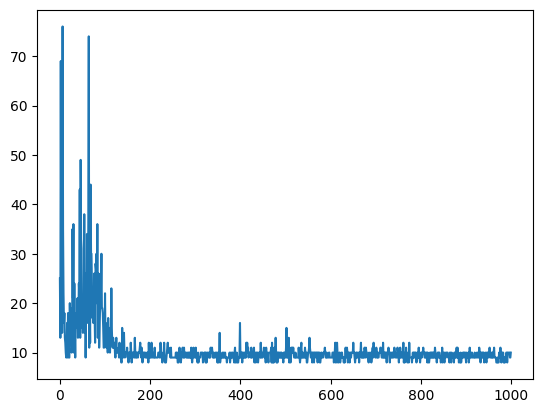

Testing for 10 episodes
Episode:1,return: 9.0
Episode:2,return: 9.0
Episode:3,return: 10.0
Episode:4,return: 9.0
Episode:5,return: 9.0
Episode:6,return: 10.0
Episode:7,return: 9.0
Episode:8,return: 8.0
Episode:9,return: 10.0
Episode:10,return: 10.0


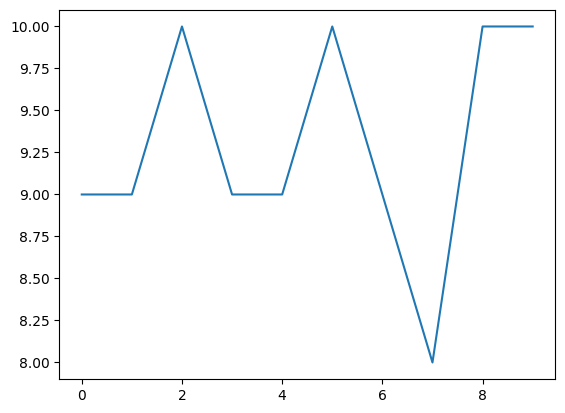

In [37]:
main(1000,1)

Training for 1000 episodes
1/1 [==============================] - 0s 38ms/step
Episode:1/1000,return: 12.0
1/1 [==============================] - 0s 21ms/step
Episode:2/1000,return: 15.0
1/1 [==============================] - 0s 29ms/step
Episode:3/1000,return: 30.0
1/1 [==============================] - 0s 66ms/step
Episode:4/1000,return: 25.0
1/1 [==============================] - 0s 27ms/step


2022-11-22 19:31:16.381238: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


Episode:5/1000,return: 17.0
1/1 [==============================] - 0s 27ms/step
Episode:6/1000,return: 57.0
1/1 [==============================] - 0s 12ms/step
Episode:7/1000,return: 15.0
1/1 [==============================] - 0s 20ms/step
Episode:8/1000,return: 13.0
1/1 [==============================] - 0s 12ms/step
Episode:9/1000,return: 13.0
1/1 [==============================] - 0s 12ms/step
Episode:10/1000,return: 11.0
1/1 [==============================] - 0s 16ms/step
Episode:11/1000,return: 17.0
1/1 [==============================] - 0s 11ms/step
Episode:12/1000,return: 11.0
1/1 [==============================] - 0s 10ms/step
Episode:13/1000,return: 13.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step
Episode:14/1000,return: 21.0
1/1 [==============================] - 0s 9ms/step
Episode:15/1000,return: 9.0
1/1 [==============================] - 0s 10ms/step
Episode:16/1000,return: 14.0
1/1 [==============================] - 0s 9ms/step
Episode:17/1000,return: 10.0
1/1 [==============================] - 0s 12ms/step
Episode:18/1000,return: 11.0
1/1 [==============================] - 0s 10ms/step
Episode:19/1000,return: 17.0
1/1 [==============================] - 0s 17ms/step
Episode:20/1000,return: 17.0
1/1 [==============================] - 0s 10ms/step
Episode:21/1000,return: 9.0
1/1 [==============================] - 0s 12ms/step
Episode:22/1000,return: 33.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
Episode:23/1000,return: 15.0
1/1 [==============================] - 0s 12ms/step
Episode:24/1000,return: 10.0
1/1 [==============================] - 0s 12ms/step
Episode:25/1000,return: 10.0
1/1 [==============================] - 0s 9ms/step
Episode:26/1000,return: 10.0
1/1 [==============================] - 0s 13ms/step
Episode:27/1000,return: 14.0
1/1 [==============================] - 0s 12ms/step
Episode:28/1000,return: 13.0
1/1 [==============================] - 0s 10ms/step
Episode:29/1000,return: 10.0
1/1 [==============================] - 0s 10ms/step
Episode:30/1000,return: 30.0
1/1 [==============================] - 0s 10ms/step
Episode:31/1000,return: 12.0
1/1 [==============================] - 0s 12ms/step
Episode:32/1000,return: 17.0
1/1 [==============================] - 0s 10ms/step
Episode:33/1000,return: 12.0
1/1 [==============================] - 0s 19ms/step
Episode:34/1000,return: 9.0
1/1 [==========================

1/1 [==============================] - 0s 15ms/step
Episode:35/1000,return: 13.0
1/1 [==============================] - 0s 34ms/step
Episode:36/1000,return: 11.0
1/1 [==============================] - 0s 16ms/step
Episode:37/1000,return: 32.0
1/1 [==============================] - 0s 15ms/step
Episode:38/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:39/1000,return: 12.0
1/1 [==============================] - 0s 12ms/step
Episode:40/1000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:41/1000,return: 15.0
1/1 [==============================] - 0s 12ms/step
Episode:42/1000,return: 13.0
1/1 [==============================] - 0s 18ms/step
Episode:43/1000,return: 11.0
1/1 [==============================] - 0s 11ms/step
Episode:44/1000,return: 13.0
1/1 [==============================] - 0s 10ms/step
Episode:45/1000,return: 9.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step
Episode:46/1000,return: 17.0
1/1 [==============================] - 0s 24ms/step
Episode:47/1000,return: 12.0
1/1 [==============================] - 0s 12ms/step
Episode:48/1000,return: 9.0
1/1 [==============================] - 0s 10ms/step
Episode:49/1000,return: 26.0
1/1 [==============================] - 0s 17ms/step
Episode:50/1000,return: 15.0
1/1 [==============================] - 0s 10ms/step
Episode:51/1000,return: 10.0
1/1 [==============================] - 0s 9ms/step
Episode:52/1000,return: 10.0
1/1 [==============================] - 0s 12ms/step
Episode:53/1000,return: 11.0
1/1 [==============================] - 0s 9ms/step
Episode:54/1000,return: 22.0
1/1 [==============================] - 0s 9ms/step
Episode:55/1000,return: 24.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
Episode:56/1000,return: 25.0
1/1 [==============================] - 0s 9ms/step
Episode:57/1000,return: 13.0
1/1 [==============================] - 0s 10ms/step
Episode:58/1000,return: 10.0
1/1 [==============================] - 0s 10ms/step
Episode:59/1000,return: 13.0
1/1 [==============================] - 0s 14ms/step
Episode:60/1000,return: 11.0
1/1 [==============================] - 0s 9ms/step
Episode:61/1000,return: 12.0
1/1 [==============================] - 0s 12ms/step
Episode:62/1000,return: 9.0
1/1 [==============================] - 0s 10ms/step
Episode:63/1000,return: 18.0
1/1 [==============================] - 0s 20ms/step
Episode:64/1000,return: 15.0
1/1 [==============================] - 0s 18ms/step
Episode:65/1000,return: 22.0
1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 31ms/step
Episode:66/1000,return: 13.0
1/1 [==============================] - 0s 9ms/step
Episode:67/1000,return: 15.0
1/1 [==============================] - 0s 9ms/step
Episode:68/1000,return: 17.0
1/1 [==============================] - 0s 16ms/step
Episode:69/1000,return: 11.0
1/1 [==============================] - 0s 9ms/step
Episode:70/1000,return: 21.0
1/1 [==============================] - 0s 10ms/step
Episode:71/1000,return: 30.0
1/1 [==============================] - 0s 29ms/step
Episode:72/1000,return: 9.0
1/1 [==============================] - 0s 13ms/step
Episode:73/1000,return: 30.0
1/1 [==============================] - 0s 13ms/step
Episode:74/1000,return: 11.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step
Episode:75/1000,return: 28.0
1/1 [==============================] - 0s 12ms/step
Episode:76/1000,return: 40.0
1/1 [==============================] - 0s 15ms/step
Episode:77/1000,return: 11.0
1/1 [==============================] - 0s 11ms/step
Episode:78/1000,return: 12.0
1/1 [==============================] - 0s 11ms/step
Episode:79/1000,return: 20.0
1/1 [==============================] - 0s 11ms/step
Episode:80/1000,return: 20.0
1/1 [==============================] - 0s 16ms/step
Episode:81/1000,return: 23.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step
Episode:82/1000,return: 12.0
1/1 [==============================] - 0s 10ms/step
Episode:83/1000,return: 13.0
1/1 [==============================] - 0s 25ms/step
Episode:84/1000,return: 13.0
1/1 [==============================] - 0s 11ms/step
Episode:85/1000,return: 15.0
1/1 [==============================] - 0s 14ms/step
Episode:86/1000,return: 17.0
1/1 [==============================] - 0s 12ms/step
Episode:87/1000,return: 14.0
1/1 [==============================] - 0s 19ms/step
Episode:88/1000,return: 10.0
1/1 [==============================] - 0s 11ms/step
Episode:89/1000,return: 13.0
1/1 [==============================] - 0s 10ms/step
Episode:90/1000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:91/1000,return: 16.0
1/1 [==============================] - 0s 9ms/step
Episode:92/1000,return: 13.0
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step
Episode:93/1000,return: 26.0
1/1 [==============================] - 0s 15ms/step
Episode:94/1000,return: 42.0
1/1 [==============================] - 0s 9ms/step
Episode:95/1000,return: 14.0
1/1 [==============================] - 0s 16ms/step
Episode:96/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:97/1000,return: 18.0
1/1 [==============================] - 0s 10ms/step
Episode:98/1000,return: 12.0
1/1 [==============================] - 0s 11ms/step
Episode:99/1000,return: 13.0
1/1 [==============================] - 0s 10ms/step
Episode:100/1000,return: 17.0
1/1 [==============================] - 0s 9ms/step
Episode:101/1000,return: 11.0


1/1 [==============================] - 0s 11ms/step
Episode:102/1000,return: 13.0
1/1 [==============================] - 0s 12ms/step
Episode:103/1000,return: 12.0
1/1 [==============================] - 0s 11ms/step
Episode:104/1000,return: 23.0
1/1 [==============================] - 0s 10ms/step
Episode:105/1000,return: 16.0
1/1 [==============================] - 0s 12ms/step
Episode:106/1000,return: 24.0
1/1 [==============================] - 0s 11ms/step
Episode:107/1000,return: 12.0
1/1 [==============================] - 0s 12ms/step
Episode:108/1000,return: 15.0
1/1 [==============================] - 0s 17ms/step
Episode:109/1000,return: 13.0
1/1 [==============================] - 0s 11ms/step
Episode:110/1000,return: 12.0
1/1 [==============================] - 0s 17ms/step
Episode:111/1000,return: 10.0
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step
Episode:112/1000,return: 24.0
1/1 [==============================] - 0s 22ms/step
Episode:113/1000,return: 26.0
1/1 [==============================] - 0s 35ms/step
Episode:114/1000,return: 15.0
1/1 [==============================] - 0s 25ms/step
Episode:115/1000,return: 17.0
1/1 [==============================] - 0s 25ms/step
Episode:116/1000,return: 16.0
1/1 [==============================] - 0s 14ms/step
Episode:117/1000,return: 31.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 14ms/step
Episode:118/1000,return: 34.0
1/1 [==============================] - 0s 13ms/step
Episode:119/1000,return: 26.0
1/1 [==============================] - 0s 23ms/step
Episode:120/1000,return: 24.0
1/1 [==============================] - 0s 12ms/step
Episode:121/1000,return: 19.0
1/1 [==============================] - 0s 13ms/step
Episode:122/1000,return: 18.0
1/1 [==============================] - 0s 21ms/step
Episode:123/1000,return: 47.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step
Episode:124/1000,return: 48.0
1/1 [==============================] - 0s 15ms/step
Episode:125/1000,return: 19.0
1/1 [==============================] - 0s 12ms/step
Episode:126/1000,return: 27.0
1/1 [==============================] - 0s 10ms/step
Episode:127/1000,return: 29.0
1/1 [==============================] - 0s 11ms/step
Episode:128/1000,return: 34.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
Episode:129/1000,return: 30.0
1/1 [==============================] - 0s 9ms/step
Episode:130/1000,return: 15.0
1/1 [==============================] - 0s 11ms/step
Episode:131/1000,return: 79.0
1/1 [==============================] - 0s 14ms/step
Episode:132/1000,return: 27.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
Episode:133/1000,return: 24.0
1/1 [==============================] - 0s 12ms/step
Episode:134/1000,return: 45.0
1/1 [==============================] - 0s 36ms/step
Episode:135/1000,return: 91.0
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 16ms/step
Episode:136/1000,return: 35.0
1/1 [==============================] - 0s 9ms/step
Episode:137/1000,return: 46.0
1/1 [==============================] - 0s 19ms/step
Episode:138/1000,return: 62.0
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 10ms/step
Episode:139/1000,return: 28.0
1/1 [==============================] - 0s 14ms/step
Episode:140/1000,return: 67.0
1/1 [==============================] - 0s 15ms/step
Episode:141/1000,return: 62.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step
Episode:142/1000,return: 74.0
1/1 [==============================] - 0s 16ms/step
Episode:143/1000,return: 32.0
1/1 [==============================] - 0s 12ms/step
Episode:144/1000,return: 46.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:145/1000,return: 72.0
1/1 [==============================] - 0s 11ms/step
Episode:146/1000,return: 34.0
1/1 [==============================] - 0s 10ms/step
Episode:147/1000,return: 52.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step
Episode:148/1000,return: 53.0
1/1 [==============================] - 0s 9ms/step
Episode:149/1000,return: 41.0
1/1 [==============================] - 0s 32ms/step
Episode:150/1000,return: 37.0
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 10ms/step
Episode:151/1000,return: 61.0
1/1 [==============================] - 0s 12ms/step
Episode:152/1000,return: 69.0
1/1 [==============================] - 0s 11ms/step
Episode:153/1000,return: 68.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
Episode:154/1000,return: 37.0
1/1 [==============================] - 0s 28ms/step
Episode:155/1000,return: 48.0
1/1 [==============================] - 0s 14ms/step
Episode:156/1000,return: 15.0
1/1 [==============================] - 0s 13ms/step
Episode:157/1000,return: 31.0
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Episode:158/1000,return: 48.0
1/1 [==============================] - 0s 12ms/step
Episode:159/1000,return: 59.0
1/1 [==============================] - 0s 16ms/step
Episode:160/1000,return: 66.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step
Episode:161/1000,return: 33.0
1/1 [==============================] - 0s 8ms/step
Episode:162/1000,return: 27.0
1/1 [==============================] - 0s 12ms/step
Episode:163/1000,return: 30.0
1/1 [==============================] - 0s 9ms/step
Episode:164/1000,return: 29.0
1/1 [==============================] - 0s 9ms/step
Episode:165/1000,return: 34.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 20ms/step
Episode:166/1000,return: 25.0
1/1 [==============================] - 0s 16ms/step
Episode:167/1000,return: 32.0
1/1 [==============================] - 0s 10ms/step
Episode:168/1000,return: 19.0
1/1 [==============================] - 0s 11ms/step
Episode:169/1000,return: 24.0
1/1 [==============================] - 0s 13ms/step
Episode:170/1000,return: 46.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
Episode:171/1000,return: 32.0
1/1 [==============================] - 0s 12ms/step
Episode:172/1000,return: 33.0
1/1 [==============================] - 0s 11ms/step
Episode:173/1000,return: 30.0
1/1 [==============================] - 0s 37ms/step
Episode:174/1000,return: 22.0
1/1 [==============================] - 0s 21ms/step
Episode:175/1000,return: 38.0
1/1 [==============================] - 0s 9ms/step


Episode:176/1000,return: 26.0
1/1 [==============================] - 0s 9ms/step
Episode:177/1000,return: 33.0
1/1 [==============================] - 0s 17ms/step
Episode:178/1000,return: 23.0
1/1 [==============================] - 0s 12ms/step
Episode:179/1000,return: 36.0
1/1 [==============================] - 0s 12ms/step
Episode:180/1000,return: 12.0
1/1 [==============================] - 0s 11ms/step
Episode:181/1000,return: 37.0
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 11ms/step
Episode:182/1000,return: 26.0
1/1 [==============================] - 0s 12ms/step
Episode:183/1000,return: 33.0
1/1 [==============================] - 0s 12ms/step
Episode:184/1000,return: 30.0
1/1 [==============================] - 0s 18ms/step
Episode:185/1000,return: 43.0
1/1 [==============================] - 0s 15ms/step
Episode:186/1000,return: 24.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 16ms/step
Episode:187/1000,return: 18.0
1/1 [==============================] - 0s 10ms/step
Episode:188/1000,return: 51.0
1/1 [==============================] - 0s 15ms/step
Episode:189/1000,return: 46.0
1/1 [==============================] - 0s 10ms/step
Episode:190/1000,return: 52.0


1/1 [==============================] - 0s 16ms/step
Episode:191/1000,return: 84.0
1/1 [==============================] - 0s 16ms/step
Episode:192/1000,return: 29.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step
Episode:193/1000,return: 58.0
1/1 [==============================] - 0s 19ms/step
Episode:194/1000,return: 55.0
1/1 [==============================] - 0s 15ms/step
Episode:195/1000,return: 62.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step
Episode:196/1000,return: 44.0
1/1 [==============================] - 0s 13ms/step
Episode:197/1000,return: 46.0
1/1 [==============================] - 0s 14ms/step
Episode:198/1000,return: 29.0
1/1 [==============================] - 0s 23ms/step
Episode:199/1000,return: 39.0
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 14ms/step
Episode:200/1000,return: 56.0
1/1 [==============================] - 0s 17ms/step
Episode:201/1000,return: 56.0
1/1 [==============================] - 0s 10ms/step


2022-11-22 19:41:55.548429: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 18ms/step
Episode:202/1000,return: 54.0
1/1 [==============================] - 0s 11ms/step
Episode:203/1000,return: 53.0
1/1 [==============================] - 0s 12ms/step
Episode:204/1000,return: 46.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step
Episode:205/1000,return: 50.0
1/1 [==============================] - 0s 12ms/step
Episode:206/1000,return: 47.0
1/1 [==============================] - 0s 9ms/step
Episode:207/1000,return: 33.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
Episode:208/1000,return: 57.0
1/1 [==============================] - 0s 16ms/step
Episode:209/1000,return: 30.0
1/1 [==============================] - 0s 10ms/step
Episode:210/1000,return: 35.0
1/1 [==============================] - 0s 10ms/step
Episode:211/1000,return: 49.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
Episode:212/1000,return: 46.0
1/1 [==============================] - 0s 12ms/step
Episode:213/1000,return: 78.0
1/1 [==============================] - 0s 18ms/step
Episode:214/1000,return: 39.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 17ms/step
Episode:215/1000,return: 34.0
1/1 [==============================] - 0s 10ms/step
Episode:216/1000,return: 51.0
1/1 [==============================] - 0s 8ms/step
Episode:217/1000,return: 33.0
1/1 [==============================] - 0s 10ms/step
Episode:218/1000,return: 50.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 28ms/step
Episode:219/1000,return: 27.0
1/1 [==============================] - 0s 9ms/step
Episode:220/1000,return: 79.0
1/1 [==============================] - 0s 12ms/step
Episode:221/1000,return: 32.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
Episode:222/1000,return: 61.0
1/1 [==============================] - 0s 14ms/step
Episode:223/1000,return: 27.0
1/1 [==============================] - 0s 13ms/step
Episode:224/1000,return: 51.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
Episode:225/1000,return: 45.0
1/1 [==============================] - 0s 8ms/step
Episode:226/1000,return: 41.0
1/1 [==============================] - 0s 9ms/step
Episode:227/1000,return: 44.0
1/1 [==============================] - 0s 9ms/step
Episode:228/1000,return: 39.0
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 10ms/step
Episode:229/1000,return: 33.0
1/1 [==============================] - 0s 10ms/step
Episode:230/1000,return: 45.0
1/1 [==============================] - 0s 11ms/step
Episode:231/1000,return: 45.0
1/1 [==============================] - 0s 10ms/step
Episode:232/1000,return: 42.0
1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 11ms/step
Episode:233/1000,return: 41.0
1/1 [==============================] - 0s 9ms/step
Episode:234/1000,return: 36.0
1/1 [==============================] - 0s 10ms/step
Episode:235/1000,return: 27.0
1/1 [==============================] - 0s 19ms/step
Episode:236/1000,return: 66.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
Episode:237/1000,return: 69.0
1/1 [==============================] - 0s 11ms/step
Episode:238/1000,return: 46.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 9ms/step
Episode:239/1000,return: 84.0
1/1 [==============================] - 0s 10ms/step
Episode:240/1000,return: 86.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step
Episode:241/1000,return: 75.0
1/1 [==============================] - 0s 10ms/step
Episode:242/1000,return: 99.0
1/1 [==============================] - 0s 9ms/step
Episode:243/1000,return: 12.0


1/1 [==============================] - 0s 10ms/step
Episode:244/1000,return: 34.0
1/1 [==============================] - 0s 10ms/step
Episode:245/1000,return: 29.0
1/1 [==============================] - 0s 11ms/step
Episode:246/1000,return: 70.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step
Episode:247/1000,return: 34.0
1/1 [==============================] - 0s 10ms/step
Episode:248/1000,return: 27.0
1/1 [==============================] - 0s 17ms/step
Episode:249/1000,return: 26.0
1/1 [==============================] - 0s 11ms/step
Episode:250/1000,return: 42.0
1/1 [==============================] - 0s 8ms/step
Episode:251/1000,return: 43.0
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 9ms/step
Episode:252/1000,return: 19.0
1/1 [==============================] - 0s 8ms/step
Episode:253/1000,return: 50.0
1/1 [==============================] - 0s 9ms/step
Episode:254/1000,return: 23.0
1/1 [==============================] - 0s 15ms/step
Episode:255/1000,return: 34.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step
Episode:256/1000,return: 60.0
1/1 [==============================] - 0s 10ms/step
Episode:257/1000,return: 50.0
1/1 [==============================] - 0s 12ms/step
Episode:258/1000,return: 44.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
Episode:259/1000,return: 48.0
1/1 [==============================] - 0s 27ms/step
Episode:260/1000,return: 62.0
1/1 [==============================] - 0s 11ms/step
Episode:261/1000,return: 23.0
1/1 [==============================] - 0s 21ms/step
Episode:262/1000,return: 35.0
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 9ms/step
Episode:263/1000,return: 33.0
1/1 [==============================] - 0s 12ms/step
Episode:264/1000,return: 37.0
1/1 [==============================] - 0s 16ms/step
Episode:265/1000,return: 29.0
1/1 [==============================] - 0s 18ms/step
Episode:266/1000,return: 54.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 25ms/step
Episode:267/1000,return: 57.0
1/1 [==============================] - 0s 19ms/step
Episode:268/1000,return: 51.0
1/1 [==============================] - 0s 13ms/step
Episode:269/1000,return: 36.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step
Episode:270/1000,return: 43.0
1/1 [==============================] - 0s 19ms/step
Episode:271/1000,return: 27.0
1/1 [==============================] - 0s 11ms/step
Episode:272/1000,return: 32.0
1/1 [==============================] - 0s 11ms/step
Episode:273/1000,return: 38.0
1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step
Episode:274/1000,return: 68.0
1/1 [==============================] - 0s 11ms/step
Episode:275/1000,return: 34.0
1/1 [==============================] - 0s 17ms/step
Episode:276/1000,return: 33.0
1/1 [==============================] - 0s 9ms/step
Episode:277/1000,return: 45.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step
Episode:278/1000,return: 51.0
1/1 [==============================] - 0s 9ms/step
Episode:279/1000,return: 58.0
1/1 [==============================] - 0s 9ms/step
Episode:280/1000,return: 73.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
Episode:281/1000,return: 19.0
1/1 [==============================] - 0s 9ms/step
Episode:282/1000,return: 34.0
1/1 [==============================] - 0s 11ms/step
Episode:283/1000,return: 19.0
1/1 [==============================] - 0s 12ms/step
Episode:284/1000,return: 38.0
1/1 [==============================] - 0s 11ms/step
Episode:285/1000,return: 34.0
1/1 [==============================] - 0s 10ms/step
Episode:286/1000,return: 15.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step
Episode:287/1000,return: 39.0
1/1 [==============================] - 0s 8ms/step
Episode:288/1000,return: 77.0
1/1 [==============================] - 0s 17ms/step
Episode:289/1000,return: 23.0
1/1 [==============================] - 0s 16ms/step
Episode:290/1000,return: 13.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
Episode:291/1000,return: 45.0
1/1 [==============================] - 0s 15ms/step
Episode:292/1000,return: 47.0
1/1 [==============================] - 0s 11ms/step
Episode:293/1000,return: 36.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 9ms/step
Episode:294/1000,return: 48.0
1/1 [==============================] - 0s 11ms/step
Episode:295/1000,return: 73.0
1/1 [==============================] - 0s 13ms/step
Episode:296/1000,return: 32.0
1/1 [==============================] - 0s 10ms/step
Episode:297/1000,return: 27.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step
Episode:298/1000,return: 32.0
1/1 [==============================] - 0s 9ms/step
Episode:299/1000,return: 14.0
1/1 [==============================] - 0s 8ms/step
Episode:300/1000,return: 35.0
1/1 [==============================] - 0s 9ms/step
Episode:301/1000,return: 33.0
1/1 [==============================] - 0s 12ms/step
Episode:302/1000,return: 26.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
Episode:303/1000,return: 39.0
1/1 [==============================] - 0s 12ms/step
Episode:304/1000,return: 15.0
1/1 [==============================] - 0s 10ms/step
Episode:305/1000,return: 41.0
1/1 [==============================] - 0s 14ms/step
Episode:306/1000,return: 21.0
1/1 [==============================] - 0s 10ms/step
Episode:307/1000,return: 29.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step
Episode:308/1000,return: 73.0
1/1 [==============================] - 0s 10ms/step
Episode:309/1000,return: 47.0
1/1 [==============================] - 0s 9ms/step
Episode:310/1000,return: 29.0
1/1 [==============================] - 0s 13ms/step
Episode:311/1000,return: 23.0
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
Episode:312/1000,return: 26.0
1/1 [==============================] - 0s 22ms/step
Episode:313/1000,return: 14.0
1/1 [==============================] - 0s 9ms/step
Episode:314/1000,return: 19.0
1/1 [==============================] - 0s 14ms/step
Episode:315/1000,return: 40.0
1/1 [==============================] - 0s 15ms/step
Episode:316/1000,return: 12.0
1/1 [==============================] - 0s 10ms/step
Episode:317/1000,return: 58.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step
Episode:318/1000,return: 30.0
1/1 [==============================] - 0s 8ms/step
Episode:319/1000,return: 25.0
1/1 [==============================] - 0s 10ms/step
Episode:320/1000,return: 49.0
1/1 [==============================] - 0s 9ms/step
Episode:321/1000,return: 27.0
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 9ms/step
Episode:322/1000,return: 42.0
1/1 [==============================] - 0s 10ms/step
Episode:323/1000,return: 14.0
1/1 [==============================] - 0s 15ms/step
Episode:324/1000,return: 23.0
1/1 [==============================] - 0s 10ms/step
Episode:325/1000,return: 64.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 22ms/step
Episode:326/1000,return: 106.0
1/1 [==============================] - 0s 13ms/step
Episode:327/1000,return: 62.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
Episode:328/1000,return: 50.0
1/1 [==============================] - 0s 9ms/step
Episode:329/1000,return: 30.0
1/1 [==============================] - 0s 10ms/step
Episode:330/1000,return: 20.0
1/1 [==============================] - 0s 11ms/step
Episode:331/1000,return: 38.0
1/1 [==============================] - 0s 9ms/step
Episode:332/1000,return: 25.0
1/1 [==============================] - 0s 11ms/step
Episode:333/1000,return: 15.0
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 9ms/step
Episode:334/1000,return: 13.0
1/1 [==============================] - 0s 9ms/step
Episode:335/1000,return: 49.0
1/1 [==============================] - 0s 12ms/step
Episode:336/1000,return: 48.0
1/1 [==============================] - 0s 11ms/step
Episode:337/1000,return: 29.0
1/1 [==============================] - 0s 11ms/step
Episode:338/1000,return: 16.0
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 13ms/step
Episode:339/1000,return: 18.0
1/1 [==============================] - 0s 8ms/step
Episode:340/1000,return: 25.0
1/1 [==============================] - 0s 9ms/step
Episode:341/1000,return: 40.0
1/1 [==============================] - 0s 11ms/step
Episode:342/1000,return: 57.0
1/1 [==============================] - 0s 8ms/step
Episode:343/1000,return: 16.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 23ms/step
Episode:344/1000,return: 12.0
1/1 [==============================] - 0s 15ms/step
Episode:345/1000,return: 17.0
1/1 [==============================] - 0s 10ms/step
Episode:346/1000,return: 31.0
1/1 [==============================] - 0s 8ms/step
Episode:347/1000,return: 26.0
1/1 [==============================] - 0s 9ms/step
Episode:348/1000,return: 28.0
1/1 [==============================] - 0s 13ms/step
Episode:349/1000,return: 36.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Episode:350/1000,return: 43.0
1/1 [==============================] - 0s 14ms/step
Episode:351/1000,return: 50.0
1/1 [==============================] - 0s 11ms/step
Episode:352/1000,return: 21.0
1/1 [==============================] - 0s 9ms/step
Episode:353/1000,return: 23.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
Episode:354/1000,return: 38.0
1/1 [==============================] - 0s 12ms/step
Episode:355/1000,return: 20.0
1/1 [==============================] - 0s 11ms/step
Episode:356/1000,return: 66.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 19ms/step
Episode:357/1000,return: 66.0
1/1 [==============================] - 0s 17ms/step
Episode:358/1000,return: 24.0
1/1 [==============================] - 0s 9ms/step
Episode:359/1000,return: 52.0
1/1 [==============================] - 0s 19ms/step
Episode:360/1000,return: 24.0
1/1 [==============================] - 0s 10ms/step
Episode:361/1000,return: 28.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
Episode:362/1000,return: 47.0
1/1 [==============================] - 0s 9ms/step
Episode:363/1000,return: 61.0
1/1 [==============================] - 0s 10ms/step
Episode:364/1000,return: 37.0
1/1 [==============================] - 0s 10ms/step
Episode:365/1000,return: 23.0
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 10ms/step
Episode:366/1000,return: 23.0
1/1 [==============================] - 0s 12ms/step
Episode:367/1000,return: 18.0
1/1 [==============================] - 0s 16ms/step
Episode:368/1000,return: 23.0
1/1 [==============================] - 0s 12ms/step
Episode:369/1000,return: 44.0
1/1 [==============================] - 0s 9ms/step
Episode:370/1000,return: 37.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
Episode:371/1000,return: 33.0
1/1 [==============================] - 0s 10ms/step
Episode:372/1000,return: 25.0
1/1 [==============================] - 0s 8ms/step
Episode:373/1000,return: 38.0
1/1 [==============================] - 0s 13ms/step
Episode:374/1000,return: 47.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
Episode:375/1000,return: 48.0
1/1 [==============================] - 0s 10ms/step
Episode:376/1000,return: 41.0
1/1 [==============================] - 0s 9ms/step
Episode:377/1000,return: 69.0
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 15ms/step
Episode:378/1000,return: 41.0
1/1 [==============================] - 0s 15ms/step
Episode:379/1000,return: 29.0
1/1 [==============================] - 0s 16ms/step
Episode:380/1000,return: 26.0
1/1 [==============================] - 0s 18ms/step
Episode:381/1000,return: 70.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step
Episode:382/1000,return: 42.0
1/1 [==============================] - 0s 18ms/step
Episode:383/1000,return: 27.0
1/1 [==============================] - 0s 19ms/step
Episode:384/1000,return: 34.0
1/1 [==============================] - 0s 10ms/step
Episode:385/1000,return: 38.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step
Episode:386/1000,return: 36.0
1/1 [==============================] - 0s 20ms/step
Episode:387/1000,return: 52.0
1/1 [==============================] - 0s 12ms/step
Episode:388/1000,return: 26.0
1/1 [==============================] - 0s 10ms/step
Episode:389/1000,return: 72.0
1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 21ms/step
Episode:390/1000,return: 47.0
1/1 [==============================] - 0s 9ms/step
Episode:391/1000,return: 33.0
1/1 [==============================] - 0s 11ms/step
Episode:392/1000,return: 39.0
1/1 [==============================] - 0s 13ms/step
Episode:393/1000,return: 30.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 14ms/step
Episode:394/1000,return: 22.0
1/1 [==============================] - 0s 10ms/step
Episode:395/1000,return: 45.0
1/1 [==============================] - 0s 9ms/step
Episode:396/1000,return: 23.0
1/1 [==============================] - 0s 15ms/step
Episode:397/1000,return: 14.0
1/1 [==============================] - 0s 8ms/step
Episode:398/1000,return: 19.0
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 11ms/step
Episode:399/1000,return: 66.0
1/1 [==============================] - 0s 8ms/step
Episode:400/1000,return: 52.0
1/1 [==============================] - 0s 10ms/step
Episode:401/1000,return: 26.0
1/1 [==============================] - 0s 10ms/step
Episode:402/1000,return: 24.0
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 10ms/step
Episode:403/1000,return: 43.0
1/1 [==============================] - 0s 11ms/step
Episode:404/1000,return: 41.0
1/1 [==============================] - 0s 10ms/step
Episode:405/1000,return: 30.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 13ms/step
Episode:406/1000,return: 90.0
1/1 [==============================] - 0s 10ms/step
Episode:407/1000,return: 41.0
1/1 [==============================] - 0s 26ms/step
Episode:408/1000,return: 24.0
1/1 [==============================] - 0s 10ms/step
Episode:409/1000,return: 25.0
1/1 [==============================] - 0s 13ms/step
Episode:410/1000,return: 41.0
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 12ms/step
Episode:411/1000,return: 54.0
1/1 [==============================] - 0s 10ms/step
Episode:412/1000,return: 71.0
1/1 [==============================] - 0s 13ms/step
Episode:413/1000,return: 35.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step
Episode:414/1000,return: 35.0
1/1 [==============================] - 0s 15ms/step
Episode:415/1000,return: 44.0
1/1 [==============================] - 0s 15ms/step
Episode:416/1000,return: 68.0
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 14ms/step
Episode:417/1000,return: 82.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step
Episode:418/1000,return: 90.0
1/1 [==============================] - 0s 10ms/step
Episode:419/1000,return: 140.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 16ms/step
Episode:420/1000,return: 97.0
1/1 [==============================] - 0s 16ms/step
Episode:421/1000,return: 71.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 16ms/step
Episode:422/1000,return: 86.0
1/1 [==============================] - 0s 10ms/step
Episode:423/1000,return: 39.0
1/1 [==============================] - 0s 16ms/step
Episode:424/1000,return: 35.0


1/1 [==============================] - 0s 17ms/step
Episode:425/1000,return: 69.0
1/1 [==============================] - 0s 22ms/step
Episode:426/1000,return: 52.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:427/1000,return: 63.0
1/1 [==============================] - 0s 14ms/step
Episode:428/1000,return: 85.0
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 20ms/step
Episode:429/1000,return: 45.0
1/1 [==============================] - 0s 12ms/step
Episode:430/1000,return: 37.0
1/1 [==============================] - 0s 12ms/step
Episode:431/1000,return: 66.0
1/1 [==============================] - 0s 16ms/step
Episode:432/1000,return: 41.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 11ms/step
Episode:433/1000,return: 33.0
1/1 [==============================] - 0s 18ms/step
Episode:434/1000,return: 51.0
1/1 [==============================] - 0s 21ms/step
Episode:435/1000,return: 31.0
1/1 [==============================] - 0s 10ms/step
Episode:436/1000,return: 39.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step
Episode:437/1000,return: 39.0
1/1 [==============================] - 0s 11ms/step
Episode:438/1000,return: 35.0
1/1 [==============================] - 0s 10ms/step
Episode:439/1000,return: 57.0
1/1 [==============================] - 0s 10ms/step
Episode:440/1000,return: 35.0


1/1 [==============================] - 0s 9ms/step
Episode:441/1000,return: 51.0
1/1 [==============================] - 0s 11ms/step
Episode:442/1000,return: 51.0
1/1 [==============================] - 0s 18ms/step
Episode:443/1000,return: 46.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
Episode:444/1000,return: 44.0
1/1 [==============================] - 0s 25ms/step
Episode:445/1000,return: 36.0
1/1 [==============================] - 0s 12ms/step
Episode:446/1000,return: 32.0
1/1 [==============================] - 0s 10ms/step
Episode:447/1000,return: 23.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
Episode:448/1000,return: 56.0
1/1 [==============================] - 0s 19ms/step
Episode:449/1000,return: 42.0
1/1 [==============================] - 0s 10ms/step
Episode:450/1000,return: 36.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step
Episode:451/1000,return: 57.0
1/1 [==============================] - 0s 15ms/step
Episode:452/1000,return: 37.0
1/1 [==============================] - 0s 13ms/step
Episode:453/1000,return: 70.0
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 9ms/step
Episode:454/1000,return: 64.0
1/1 [==============================] - 0s 16ms/step
Episode:455/1000,return: 58.0
1/1 [==============================] - 0s 9ms/step
Episode:456/1000,return: 66.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step
Episode:457/1000,return: 39.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step
Episode:458/1000,return: 135.0
1/1 [==============================] - 0s 15ms/step
Episode:459/1000,return: 41.0
1/1 [==============================] - 0s 11ms/step
Episode:460/1000,return: 50.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 16ms/step
Episode:461/1000,return: 61.0
1/1 [==============================] - 0s 13ms/step
Episode:462/1000,return: 28.0
1/1 [==============================] - 0s 23ms/step
Episode:463/1000,return: 23.0
1/1 [==============================] - 0s 10ms/step
Episode:464/1000,return: 45.0
1/1 [==============================] - 0s 9ms/step
Episode:465/1000,return: 33.0
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step
Episode:466/1000,return: 27.0
1/1 [==============================] - 0s 10ms/step
Episode:467/1000,return: 41.0
1/1 [==============================] - 0s 11ms/step
Episode:468/1000,return: 62.0
1/1 [==============================] - 0s 10ms/step
Episode:469/1000,return: 31.0
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 13ms/step
Episode:470/1000,return: 31.0
1/1 [==============================] - 0s 9ms/step
Episode:471/1000,return: 48.0
1/1 [==============================] - 0s 10ms/step
Episode:472/1000,return: 45.0
1/1 [==============================] - 0s 9ms/step
Episode:473/1000,return: 28.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 14ms/step
Episode:474/1000,return: 32.0
1/1 [==============================] - 0s 9ms/step
Episode:475/1000,return: 24.0
1/1 [==============================] - 0s 10ms/step
Episode:476/1000,return: 39.0
1/1 [==============================] - 0s 13ms/step
Episode:477/1000,return: 44.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step
Episode:478/1000,return: 78.0
1/1 [==============================] - 0s 12ms/step
Episode:479/1000,return: 19.0
1/1 [==============================] - 0s 13ms/step
Episode:480/1000,return: 89.0
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 10ms/step
Episode:481/1000,return: 58.0
1/1 [==============================] - 0s 14ms/step
Episode:482/1000,return: 39.0
1/1 [==============================] - 0s 11ms/step
Episode:483/1000,return: 27.0
1/1 [==============================] - 0s 10ms/step
Episode:484/1000,return: 14.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 37ms/step
Episode:485/1000,return: 30.0
1/1 [==============================] - 0s 10ms/step
Episode:486/1000,return: 37.0
1/1 [==============================] - 0s 15ms/step
Episode:487/1000,return: 48.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step
Episode:488/1000,return: 76.0
1/1 [==============================] - 0s 21ms/step
Episode:489/1000,return: 104.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 15ms/step
Episode:490/1000,return: 49.0
1/1 [==============================] - 0s 19ms/step
Episode:491/1000,return: 48.0
1/1 [==============================] - 0s 10ms/step
Episode:492/1000,return: 40.0
1/1 [==============================] - 0s 14ms/step
Episode:493/1000,return: 31.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
Episode:494/1000,return: 44.0
1/1 [==============================] - 0s 11ms/step
Episode:495/1000,return: 18.0
1/1 [==============================] - 0s 11ms/step
Episode:496/1000,return: 35.0
1/1 [==============================] - 0s 9ms/step
Episode:497/1000,return: 32.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
Episode:498/1000,return: 64.0
1/1 [==============================] - 0s 11ms/step
Episode:499/1000,return: 20.0
1/1 [==============================] - 0s 16ms/step
Episode:500/1000,return: 23.0
1/1 [==============================] - 0s 15ms/step
Episode:501/1000,return: 20.0
1/1 [==============================] - 0s 15ms/step
Episode:502/1000,return: 18.0
1/1 [==============================] - 0s 14ms/step
Episode:503/1000,return: 45.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 19ms/step
Episode:504/1000,return: 58.0
1/1 [==============================] - 0s 9ms/step
Episode:505/1000,return: 95.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 14ms/step
Episode:506/1000,return: 36.0
1/1 [==============================] - 0s 17ms/step
Episode:507/1000,return: 24.0
1/1 [==============================] - 0s 18ms/step
Episode:508/1000,return: 67.0
1/1 [==============================] - 0s 13ms/step
Episode:509/1000,return: 19.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 17ms/step
Episode:510/1000,return: 42.0
1/1 [==============================] - 0s 17ms/step
Episode:511/1000,return: 29.0
1/1 [==============================] - 0s 10ms/step
Episode:512/1000,return: 50.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 18ms/step
Episode:513/1000,return: 97.0
1/1 [==============================] - 0s 11ms/step
Episode:514/1000,return: 23.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step
Episode:515/1000,return: 103.0
1/1 [==============================] - 0s 17ms/step
Episode:516/1000,return: 56.0
1/1 [==============================] - 0s 9ms/step
Episode:517/1000,return: 21.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 21ms/step
Episode:518/1000,return: 79.0
1/1 [==============================] - 0s 11ms/step
Episode:519/1000,return: 34.0
1/1 [==============================] - 0s 10ms/step
Episode:520/1000,return: 35.0
1/1 [==============================] - 0s 12ms/step
Episode:521/1000,return: 13.0
1/1 [==============================] - 0s 13ms/step
Episode:522/1000,return: 34.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 16ms/step
Episode:523/1000,return: 48.0
1/1 [==============================] - 0s 9ms/step
Episode:524/1000,return: 28.0
1/1 [==============================] - 0s 10ms/step
Episode:525/1000,return: 70.0
1/1 [==============================] - 0s 13ms/step
Episode:526/1000,return: 16.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 9ms/step
Episode:527/1000,return: 31.0
1/1 [==============================] - 0s 9ms/step
Episode:528/1000,return: 38.0
1/1 [==============================] - 0s 11ms/step
Episode:529/1000,return: 31.0
1/1 [==============================] - 0s 15ms/step
Episode:530/1000,return: 30.0
1/1 [==============================] - 0s 11ms/step
Episode:531/1000,return: 26.0
1/1 [==============================] - 0s 9ms/step
Episode:532/1000,return: 25.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step
Episode:533/1000,return: 48.0
1/1 [==============================] - 0s 11ms/step
Episode:534/1000,return: 24.0
1/1 [==============================] - 0s 13ms/step
Episode:535/1000,return: 52.0
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 9ms/step
Episode:536/1000,return: 37.0
1/1 [==============================] - 0s 17ms/step
Episode:537/1000,return: 36.0
1/1 [==============================] - 0s 19ms/step
Episode:538/1000,return: 37.0
1/1 [==============================] - 0s 10ms/step
Episode:539/1000,return: 28.0
1/1 [==============================] - 0s 11ms/step
Episode:540/1000,return: 41.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:541/1000,return: 26.0
1/1 [==============================] - 0s 19ms/step
Episode:542/1000,return: 75.0
1/1 [==============================] - 0s 21ms/step
Episode:543/1000,return: 40.0
1/1 [==============================] - 0s 16ms/step
Episode:544/1000,return: 18.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
Episode:545/1000,return: 31.0
1/1 [==============================] - 0s 9ms/step
Episode:546/1000,return: 53.0
1/1 [==============================] - 0s 33ms/step
Episode:547/1000,return: 29.0
1/1 [==============================] - 0s 12ms/step
Episode:548/1000,return: 18.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step
Episode:549/1000,return: 68.0
1/1 [==============================] - 0s 17ms/step
Episode:550/1000,return: 48.0
1/1 [==============================] - 0s 9ms/step
Episode:551/1000,return: 22.0
1/1 [==============================] - 0s 20ms/step
Episode:552/1000,return: 36.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
Episode:553/1000,return: 26.0
1/1 [==============================] - 0s 12ms/step
Episode:554/1000,return: 44.0
1/1 [==============================] - 0s 11ms/step
Episode:555/1000,return: 16.0
1/1 [==============================] - 0s 14ms/step
Episode:556/1000,return: 36.0
1/1 [==============================] - 0s 9ms/step
Episode:557/1000,return: 28.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 30ms/step
Episode:558/1000,return: 33.0
1/1 [==============================] - 0s 15ms/step
Episode:559/1000,return: 27.0
1/1 [==============================] - 0s 8ms/step
Episode:560/1000,return: 41.0
1/1 [==============================] - 0s 11ms/step
Episode:561/1000,return: 67.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
Episode:562/1000,return: 27.0
1/1 [==============================] - 0s 14ms/step
Episode:563/1000,return: 20.0
1/1 [==============================] - 0s 10ms/step
Episode:564/1000,return: 41.0
1/1 [==============================] - 0s 12ms/step
Episode:565/1000,return: 43.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step
Episode:566/1000,return: 31.0
1/1 [==============================] - 0s 13ms/step
Episode:567/1000,return: 20.0
1/1 [==============================] - 0s 11ms/step
Episode:568/1000,return: 29.0
1/1 [==============================] - 0s 15ms/step
Episode:569/1000,return: 69.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step
Episode:570/1000,return: 114.0
1/1 [==============================] - 0s 11ms/step
Episode:571/1000,return: 56.0
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 9ms/step
Episode:572/1000,return: 38.0
1/1 [==============================] - 0s 10ms/step
Episode:573/1000,return: 29.0
1/1 [==============================] - 0s 11ms/step
Episode:574/1000,return: 47.0
1/1 [==============================] - 0s 10ms/step
Episode:575/1000,return: 53.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step
Episode:576/1000,return: 35.0
1/1 [==============================] - 0s 14ms/step
Episode:577/1000,return: 52.0
1/1 [==============================] - 0s 12ms/step
Episode:578/1000,return: 27.0
1/1 [==============================] - 0s 10ms/step
Episode:579/1000,return: 49.0


1/1 [==============================] - 0s 12ms/step
Episode:580/1000,return: 52.0
1/1 [==============================] - 0s 9ms/step
Episode:581/1000,return: 35.0
1/1 [==============================] - 0s 14ms/step


Episode:582/1000,return: 70.0
1/1 [==============================] - 0s 12ms/step
Episode:583/1000,return: 64.0
1/1 [==============================] - 0s 11ms/step
Episode:584/1000,return: 75.0
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 11ms/step
Episode:585/1000,return: 44.0
1/1 [==============================] - 0s 10ms/step
Episode:586/1000,return: 73.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Episode:587/1000,return: 58.0
1/1 [==============================] - 0s 12ms/step
Episode:588/1000,return: 69.0
1/1 [==============================] - 0s 10ms/step
Episode:589/1000,return: 52.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step
Episode:590/1000,return: 97.0
1/1 [==============================] - 0s 14ms/step
Episode:591/1000,return: 64.0
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 11ms/step
Episode:592/1000,return: 37.0
1/1 [==============================] - 0s 12ms/step
Episode:593/1000,return: 49.0
1/1 [==============================] - 0s 9ms/step
Episode:594/1000,return: 96.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step
Episode:595/1000,return: 34.0
1/1 [==============================] - 0s 11ms/step
Episode:596/1000,return: 78.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step
Episode:597/1000,return: 48.0
1/1 [==============================] - 0s 11ms/step
Episode:598/1000,return: 68.0
1/1 [==============================] - 0s 9ms/step
Episode:599/1000,return: 35.0
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step
Episode:600/1000,return: 53.0
1/1 [==============================] - 0s 13ms/step
Episode:601/1000,return: 64.0
1/1 [==============================] - 0s 17ms/step
Episode:602/1000,return: 69.0
1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 20ms/step
Episode:603/1000,return: 37.0
1/1 [==============================] - 0s 10ms/step
Episode:604/1000,return: 48.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Episode:605/1000,return: 149.0
1/1 [==============================] - 0s 12ms/step
Episode:606/1000,return: 43.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
Episode:607/1000,return: 61.0
1/1 [==============================] - 0s 11ms/step
Episode:608/1000,return: 61.0
1/1 [==============================] - 0s 24ms/step
Episode:609/1000,return: 79.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
Episode:610/1000,return: 93.0
1/1 [==============================] - 0s 9ms/step
Episode:611/1000,return: 53.0
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step
Episode:612/1000,return: 93.0
1/1 [==============================] - 0s 9ms/step
Episode:613/1000,return: 62.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 21ms/step
Episode:614/1000,return: 53.0
1/1 [==============================] - 0s 10ms/step
Episode:615/1000,return: 56.0
1/1 [==============================] - 0s 14ms/step
Episode:616/1000,return: 29.0
1/1 [==============================] - 0s 18ms/step
Episode:617/1000,return: 39.0
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 11ms/step
Episode:618/1000,return: 115.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 9ms/step
Episode:619/1000,return: 73.0
1/1 [==============================] - 0s 12ms/step
Episode:620/1000,return: 52.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 16ms/step
Episode:621/1000,return: 95.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
Episode:622/1000,return: 180.0
1/1 [==============================] - 0s 12ms/step
Episode:623/1000,return: 76.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step
Episode:624/1000,return: 76.0
1/1 [==============================] - 0s 11ms/step
Episode:625/1000,return: 116.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 22ms/step
Episode:626/1000,return: 82.0
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 9ms/step
Episode:627/1000,return: 177.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 16ms/step
Episode:628/1000,return: 75.0
1/1 [==============================] - 0s 9ms/step
Episode:629/1000,return: 80.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step
Episode:630/1000,return: 63.0
1/1 [==============================] - 0s 11ms/step
Episode:631/1000,return: 74.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 16ms/step
Episode:632/1000,return: 78.0
1/1 [==============================] - 0s 9ms/step
Episode:633/1000,return: 124.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step
Episode:634/1000,return: 51.0
1/1 [==============================] - 0s 11ms/step
Episode:635/1000,return: 34.0
1/1 [==============================] - 0s 17ms/step
Episode:636/1000,return: 39.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step
Episode:637/1000,return: 72.0
1/1 [==============================] - 0s 12ms/step
Episode:638/1000,return: 36.0
1/1 [==============================] - 0s 9ms/step
Episode:639/1000,return: 32.0
1/1 [==============================] - 0s 9ms/step
Episode:640/1000,return: 44.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:641/1000,return: 46.0
1/1 [==============================] - 0s 9ms/step
Episode:642/1000,return: 50.0
1/1 [==============================] - 0s 10ms/step
Episode:643/1000,return: 30.0
1/1 [==============================] - 0s 12ms/step
Episode:644/1000,return: 51.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step
Episode:645/1000,return: 42.0
1/1 [==============================] - 0s 10ms/step
Episode:646/1000,return: 39.0
1/1 [==============================] - 0s 13ms/step
Episode:647/1000,return: 40.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step
Episode:648/1000,return: 52.0
1/1 [==============================] - 0s 10ms/step
Episode:649/1000,return: 42.0
1/1 [==============================] - 0s 10ms/step
Episode:650/1000,return: 46.0
1/1 [==============================] - 0s 13ms/step
Episode:651/1000,return: 56.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
Episode:652/1000,return: 31.0
1/1 [==============================] - 0s 9ms/step
Episode:653/1000,return: 52.0
1/1 [==============================] - 0s 10ms/step
Episode:654/1000,return: 74.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
Episode:655/1000,return: 62.0
1/1 [==============================] - 0s 13ms/step
Episode:656/1000,return: 34.0
1/1 [==============================] - 0s 9ms/step
Episode:657/1000,return: 46.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step
Episode:658/1000,return: 34.0
1/1 [==============================] - 0s 10ms/step
Episode:659/1000,return: 45.0
1/1 [==============================] - 0s 12ms/step
Episode:660/1000,return: 43.0
1/1 [==============================] - 0s 17ms/step
Episode:661/1000,return: 43.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 17ms/step
Episode:662/1000,return: 30.0
1/1 [==============================] - 0s 9ms/step
Episode:663/1000,return: 41.0
1/1 [==============================] - 0s 13ms/step
Episode:664/1000,return: 34.0
1/1 [==============================] - 0s 12ms/step
Episode:665/1000,return: 30.0
1/1 [==============================] - 0s 15ms/step
Episode:666/1000,return: 29.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 14ms/step
Episode:667/1000,return: 21.0
1/1 [==============================] - 0s 12ms/step
Episode:668/1000,return: 25.0
1/1 [==============================] - 0s 10ms/step
Episode:669/1000,return: 20.0
1/1 [==============================] - 0s 15ms/step
Episode:670/1000,return: 21.0
1/1 [==============================] - 0s 14ms/step
Episode:671/1000,return: 18.0
1/1 [==============================] - 0s 16ms/step
Episode:672/1000,return: 29.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step
Episode:673/1000,return: 21.0
1/1 [==============================] - 0s 9ms/step
Episode:674/1000,return: 25.0
1/1 [==============================] - 0s 14ms/step
Episode:675/1000,return: 26.0
1/1 [==============================] - 0s 12ms/step
Episode:676/1000,return: 35.0
1/1 [==============================] - 0s 16ms/step
Episode:677/1000,return: 30.0
1/1 [==============================] - 0s 9ms/step
Episode:678/1000,return: 21.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 16ms/step
Episode:679/1000,return: 35.0
1/1 [==============================] - 0s 11ms/step
Episode:680/1000,return: 35.0
1/1 [==============================] - 0s 15ms/step
Episode:681/1000,return: 52.0
1/1 [==============================] - 0s 10ms/step
Episode:682/1000,return: 22.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
Episode:683/1000,return: 34.0
1/1 [==============================] - 0s 25ms/step
Episode:684/1000,return: 44.0
1/1 [==============================] - 0s 13ms/step
Episode:685/1000,return: 42.0
1/1 [==============================] - 0s 14ms/step
Episode:686/1000,return: 42.0
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
Episode:687/1000,return: 40.0
1/1 [==============================] - 0s 19ms/step
Episode:688/1000,return: 45.0
1/1 [==============================] - 0s 13ms/step
Episode:689/1000,return: 36.0
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 12ms/step
Episode:690/1000,return: 65.0
1/1 [==============================] - 0s 15ms/step
Episode:691/1000,return: 37.0
1/1 [==============================] - 0s 12ms/step
Episode:692/1000,return: 51.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
Episode:693/1000,return: 79.0
1/1 [==============================] - 0s 40ms/step
Episode:694/1000,return: 72.0
1/1 [==============================] - 0s 12ms/step
Episode:695/1000,return: 55.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step
Episode:696/1000,return: 82.0
1/1 [==============================] - 0s 12ms/step
Episode:697/1000,return: 61.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step
Episode:698/1000,return: 65.0
1/1 [==============================] - 0s 11ms/step
Episode:699/1000,return: 33.0
1/1 [==============================] - 0s 13ms/step
Episode:700/1000,return: 42.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step
Episode:701/1000,return: 121.0
1/1 [==============================] - 0s 12ms/step
Episode:702/1000,return: 52.0
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 14ms/step
Episode:703/1000,return: 112.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step
Episode:704/1000,return: 81.0
1/1 [==============================] - 0s 11ms/step
Episode:705/1000,return: 56.0
1/1 [==============================] - 0s 14ms/step
Episode:706/1000,return: 60.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:707/1000,return: 89.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 20ms/step
Episode:708/1000,return: 110.0
1/1 [==============================] - 0s 10ms/step
Episode:709/1000,return: 57.0
1/1 [==============================] - 0s 10ms/step
Episode:710/1000,return: 75.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 12ms/step
Episode:711/1000,return: 53.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 17ms/step
Episode:712/1000,return: 117.0
1/1 [==============================] - 0s 11ms/step
Episode:713/1000,return: 119.0
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 9ms/step
Episode:714/1000,return: 60.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
Episode:715/1000,return: 149.0
1/1 [==============================] - 0s 12ms/step
Episode:716/1000,return: 60.0
1/1 [==============================] - 0s 11ms/step
Episode:717/1000,return: 38.0
1/1 [==============================] - 0s 10ms/step
Episode:718/1000,return: 34.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
Episode:719/1000,return: 56.0
1/1 [==============================] - 0s 14ms/step
Episode:720/1000,return: 41.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 18ms/step
Episode:721/1000,return: 81.0
1/1 [==============================] - 0s 22ms/step
Episode:722/1000,return: 93.0
1/1 [==============================] - 0s 18ms/step
Episode:723/1000,return: 42.0


1/1 [==============================] - 0s 24ms/step
Episode:724/1000,return: 72.0
1/1 [==============================] - 0s 14ms/step
Episode:725/1000,return: 35.0
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 10ms/step
Episode:726/1000,return: 69.0
1/1 [==============================] - 0s 11ms/step
Episode:727/1000,return: 45.0
1/1 [==============================] - 0s 39ms/step
Episode:728/1000,return: 43.0
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 12ms/step
Episode:729/1000,return: 79.0
1/1 [==============================] - 0s 19ms/step
Episode:730/1000,return: 35.0
1/1 [==============================] - 0s 12ms/step
Episode:731/1000,return: 44.0
1/1 [==============================] - 0s 11ms/step
Episode:732/1000,return: 42.0
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 13ms/step
Episode:733/1000,return: 57.0
1/1 [==============================] - 0s 14ms/step
Episode:734/1000,return: 31.0
1/1 [==============================] - 0s 24ms/step
Episode:735/1000,return: 49.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step
Episode:736/1000,return: 34.0
1/1 [==============================] - 0s 9ms/step
Episode:737/1000,return: 32.0
1/1 [==============================] - 0s 11ms/step
Episode:738/1000,return: 50.0
1/1 [==============================] - 0s 15ms/step
Episode:739/1000,return: 48.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 9ms/step
Episode:740/1000,return: 25.0
1/1 [==============================] - 0s 9ms/step
Episode:741/1000,return: 42.0
1/1 [==============================] - 0s 12ms/step
Episode:742/1000,return: 46.0
1/1 [==============================] - 0s 11ms/step
Episode:743/1000,return: 33.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step
Episode:744/1000,return: 51.0
1/1 [==============================] - 0s 14ms/step
Episode:745/1000,return: 31.0
1/1 [==============================] - 0s 13ms/step
Episode:746/1000,return: 37.0
1/1 [==============================] - 0s 10ms/step
Episode:747/1000,return: 41.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
Episode:748/1000,return: 33.0
1/1 [==============================] - 0s 10ms/step
Episode:749/1000,return: 35.0
1/1 [==============================] - 0s 14ms/step
Episode:750/1000,return: 30.0
1/1 [==============================] - 0s 13ms/step
Episode:751/1000,return: 42.0
1/1 [==============================] - 0s 9ms/step
Episode:752/1000,return: 27.0
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 11ms/step
Episode:753/1000,return: 33.0
1/1 [==============================] - 0s 15ms/step
Episode:754/1000,return: 30.0
1/1 [==============================] - 0s 12ms/step
Episode:755/1000,return: 30.0
1/1 [==============================] - 0s 17ms/step
Episode:756/1000,return: 26.0
1/1 [==============================] - 0s 13ms/step
Episode:757/1000,return: 23.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step
Episode:758/1000,return: 44.0
1/1 [==============================] - 0s 10ms/step
Episode:759/1000,return: 29.0
1/1 [==============================] - 0s 13ms/step
Episode:760/1000,return: 39.0
1/1 [==============================] - 0s 19ms/step
Episode:761/1000,return: 28.0
1/1 [==============================] - 0s 12ms/step
Episode:762/1000,return: 31.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 16ms/step
Episode:763/1000,return: 27.0
1/1 [==============================] - 0s 10ms/step
Episode:764/1000,return: 49.0
1/1 [==============================] - 0s 13ms/step
Episode:765/1000,return: 38.0
1/1 [==============================] - 0s 11ms/step
Episode:766/1000,return: 34.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 17ms/step
Episode:767/1000,return: 35.0
1/1 [==============================] - 0s 10ms/step
Episode:768/1000,return: 25.0
1/1 [==============================] - 0s 19ms/step
Episode:769/1000,return: 34.0
1/1 [==============================] - 0s 9ms/step
Episode:770/1000,return: 34.0
1/1 [==============================] - 0s 14ms/step
Episode:771/1000,return: 31.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
Episode:772/1000,return: 64.0
1/1 [==============================] - 0s 14ms/step
Episode:773/1000,return: 39.0
1/1 [==============================] - 0s 11ms/step
Episode:774/1000,return: 37.0
1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 14ms/step
Episode:775/1000,return: 34.0
1/1 [==============================] - 0s 9ms/step
Episode:776/1000,return: 32.0
1/1 [==============================] - 0s 12ms/step
Episode:777/1000,return: 47.0
1/1 [==============================] - 0s 11ms/step
Episode:778/1000,return: 51.0
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 12ms/step
Episode:779/1000,return: 28.0
1/1 [==============================] - 0s 15ms/step
Episode:780/1000,return: 27.0
1/1 [==============================] - 0s 9ms/step
Episode:781/1000,return: 35.0
1/1 [==============================] - 0s 11ms/step
Episode:782/1000,return: 32.0
1/1 [==============================] - 0s 11ms/step
Episode:783/1000,return: 33.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step
Episode:784/1000,return: 52.0
1/1 [==============================] - 0s 14ms/step
Episode:785/1000,return: 35.0
1/1 [==============================] - 0s 17ms/step
Episode:786/1000,return: 36.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 16ms/step
Episode:787/1000,return: 48.0
1/1 [==============================] - 0s 11ms/step
Episode:788/1000,return: 44.0
1/1 [==============================] - 0s 13ms/step
Episode:789/1000,return: 39.0
1/1 [==============================] - 0s 10ms/step
Episode:790/1000,return: 30.0
1/1 [==============================] - 0s 10ms/step
Episode:791/1000,return: 37.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step
Episode:792/1000,return: 22.0
1/1 [==============================] - 0s 9ms/step
Episode:793/1000,return: 24.0
1/1 [==============================] - 0s 12ms/step
Episode:794/1000,return: 28.0
1/1 [==============================] - 0s 11ms/step
Episode:795/1000,return: 25.0
1/1 [==============================] - 0s 14ms/step
Episode:796/1000,return: 36.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step
Episode:797/1000,return: 30.0
1/1 [==============================] - 0s 19ms/step
Episode:798/1000,return: 35.0
1/1 [==============================] - 0s 26ms/step
Episode:799/1000,return: 34.0
1/1 [==============================] - 0s 20ms/step
Episode:800/1000,return: 33.0
1/1 [==============================] - 0s 11ms/step
Episode:801/1000,return: 24.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
Episode:802/1000,return: 26.0
1/1 [==============================] - 0s 10ms/step
Episode:803/1000,return: 36.0
1/1 [==============================] - 0s 11ms/step
Episode:804/1000,return: 34.0
1/1 [==============================] - 0s 10ms/step
Episode:805/1000,return: 36.0
1/1 [==============================] - 0s 10ms/step
Episode:806/1000,return: 35.0
1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 14ms/step
Episode:807/1000,return: 34.0
1/1 [==============================] - 0s 12ms/step
Episode:808/1000,return: 28.0
1/1 [==============================] - 0s 12ms/step
Episode:809/1000,return: 40.0
1/1 [==============================] - 0s 12ms/step
Episode:810/1000,return: 29.0
1/1 [==============================] - 0s 10ms/step
Episode:811/1000,return: 34.0


1/1 [==============================] - 0s 18ms/step
Episode:812/1000,return: 38.0
1/1 [==============================] - 0s 9ms/step
Episode:813/1000,return: 37.0
1/1 [==============================] - 0s 13ms/step
Episode:814/1000,return: 31.0
1/1 [==============================] - 0s 25ms/step
Episode:815/1000,return: 33.0
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 9ms/step
Episode:816/1000,return: 27.0
1/1 [==============================] - 0s 9ms/step
Episode:817/1000,return: 31.0
1/1 [==============================] - 0s 10ms/step
Episode:818/1000,return: 28.0
1/1 [==============================] - 0s 10ms/step
Episode:819/1000,return: 25.0
1/1 [==============================] - 0s 12ms/step
Episode:820/1000,return: 28.0
1/1 [==============================] - 0s 13ms/step
Episode:821/1000,return: 25.0
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 13ms/step
Episode:822/1000,return: 28.0
1/1 [==============================] - 0s 11ms/step
Episode:823/1000,return: 37.0
1/1 [==============================] - 0s 10ms/step
Episode:824/1000,return: 37.0
1/1 [==============================] - 0s 21ms/step
Episode:825/1000,return: 29.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 18ms/step
Episode:826/1000,return: 30.0
1/1 [==============================] - 0s 10ms/step
Episode:827/1000,return: 31.0
1/1 [==============================] - 0s 16ms/step
Episode:828/1000,return: 36.0
1/1 [==============================] - 0s 14ms/step
Episode:829/1000,return: 24.0
1/1 [==============================] - 0s 19ms/step
Episode:830/1000,return: 26.0
1/1 [==============================] - 0s 11ms/step
Episode:831/1000,return: 36.0


1/1 [==============================] - 0s 14ms/step
Episode:832/1000,return: 20.0
1/1 [==============================] - 0s 9ms/step
Episode:833/1000,return: 29.0
1/1 [==============================] - 0s 12ms/step
Episode:834/1000,return: 29.0
1/1 [==============================] - 0s 13ms/step
Episode:835/1000,return: 39.0
1/1 [==============================] - 0s 9ms/step
Episode:836/1000,return: 28.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
Episode:837/1000,return: 38.0
1/1 [==============================] - 0s 19ms/step
Episode:838/1000,return: 56.0
1/1 [==============================] - 0s 12ms/step
Episode:839/1000,return: 28.0
1/1 [==============================] - 0s 10ms/step
Episode:840/1000,return: 36.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Episode:841/1000,return: 30.0
1/1 [==============================] - 0s 10ms/step
Episode:842/1000,return: 38.0
1/1 [==============================] - 0s 13ms/step
Episode:843/1000,return: 49.0
1/1 [==============================] - 0s 10ms/step
Episode:844/1000,return: 24.0
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 12ms/step
Episode:845/1000,return: 31.0
1/1 [==============================] - 0s 22ms/step
Episode:846/1000,return: 39.0
1/1 [==============================] - 0s 10ms/step
Episode:847/1000,return: 31.0
1/1 [==============================] - 0s 10ms/step
Episode:848/1000,return: 34.0
1/1 [==============================] - 0s 9ms/step
Episode:849/1000,return: 27.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step
Episode:850/1000,return: 27.0
1/1 [==============================] - 0s 11ms/step
Episode:851/1000,return: 45.0
1/1 [==============================] - 0s 9ms/step
Episode:852/1000,return: 28.0
1/1 [==============================] - 0s 12ms/step
Episode:853/1000,return: 42.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Episode:854/1000,return: 49.0
1/1 [==============================] - 0s 13ms/step
Episode:855/1000,return: 37.0
1/1 [==============================] - 0s 12ms/step
Episode:856/1000,return: 34.0
1/1 [==============================] - 0s 10ms/step
Episode:857/1000,return: 30.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 14ms/step
Episode:858/1000,return: 48.0
1/1 [==============================] - 0s 10ms/step
Episode:859/1000,return: 39.0
1/1 [==============================] - 0s 12ms/step
Episode:860/1000,return: 28.0
1/1 [==============================] - 0s 10ms/step
Episode:861/1000,return: 52.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 17ms/step
Episode:862/1000,return: 48.0
1/1 [==============================] - 0s 10ms/step
Episode:863/1000,return: 28.0
1/1 [==============================] - 0s 9ms/step
Episode:864/1000,return: 45.0
1/1 [==============================] - 0s 11ms/step
Episode:865/1000,return: 39.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step
Episode:866/1000,return: 45.0
1/1 [==============================] - 0s 30ms/step
Episode:867/1000,return: 35.0
1/1 [==============================] - 0s 11ms/step
Episode:868/1000,return: 50.0
1/1 [==============================] - 0s 9ms/step
Episode:869/1000,return: 27.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 9ms/step
Episode:870/1000,return: 38.0
1/1 [==============================] - 0s 9ms/step
Episode:871/1000,return: 27.0
1/1 [==============================] - 0s 51ms/step
Episode:872/1000,return: 41.0
1/1 [==============================] - 0s 15ms/step
Episode:873/1000,return: 40.0
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 11ms/step
Episode:874/1000,return: 34.0
1/1 [==============================] - 0s 9ms/step
Episode:875/1000,return: 34.0
1/1 [==============================] - 0s 18ms/step
Episode:876/1000,return: 54.0
1/1 [==============================] - 0s 10ms/step
Episode:877/1000,return: 38.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 9ms/step
Episode:878/1000,return: 27.0
1/1 [==============================] - 0s 14ms/step
Episode:879/1000,return: 48.0
1/1 [==============================] - 0s 9ms/step
Episode:880/1000,return: 29.0
1/1 [==============================] - 0s 13ms/step
Episode:881/1000,return: 30.0
1/1 [==============================] - 0s 9ms/step
Episode:882/1000,return: 28.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:883/1000,return: 39.0
1/1 [==============================] - 0s 14ms/step
Episode:884/1000,return: 35.0
1/1 [==============================] - 0s 13ms/step
Episode:885/1000,return: 32.0
1/1 [==============================] - 0s 19ms/step
Episode:886/1000,return: 32.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 12ms/step
Episode:887/1000,return: 53.0
1/1 [==============================] - 0s 13ms/step
Episode:888/1000,return: 49.0
1/1 [==============================] - 0s 11ms/step
Episode:889/1000,return: 34.0
1/1 [==============================] - 0s 25ms/step
Episode:890/1000,return: 46.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 18ms/step
Episode:891/1000,return: 50.0
1/1 [==============================] - 0s 11ms/step
Episode:892/1000,return: 48.0
1/1 [==============================] - 0s 13ms/step
Episode:893/1000,return: 51.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 20ms/step
Episode:894/1000,return: 65.0
1/1 [==============================] - 0s 29ms/step
Episode:895/1000,return: 41.0
1/1 [==============================] - 0s 12ms/step
Episode:896/1000,return: 37.0
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 12ms/step
Episode:897/1000,return: 74.0
1/1 [==============================] - 0s 12ms/step
Episode:898/1000,return: 55.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 25ms/step
Episode:899/1000,return: 63.0
1/1 [==============================] - 0s 12ms/step
Episode:900/1000,return: 68.0
1/1 [==============================] - 0s 11ms/step
Episode:901/1000,return: 50.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Episode:902/1000,return: 53.0
1/1 [==============================] - 0s 10ms/step
Episode:903/1000,return: 56.0
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 10ms/step
Episode:904/1000,return: 92.0
1/1 [==============================] - 0s 13ms/step
Episode:905/1000,return: 41.0
1/1 [==============================] - 0s 9ms/step
Episode:906/1000,return: 39.0
1/1 [==============================] - 0s 12ms/step
Episode:907/1000,return: 33.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step
Episode:908/1000,return: 43.0
1/1 [==============================] - 0s 11ms/step
Episode:909/1000,return: 52.0
1/1 [==============================] - 0s 22ms/step
Episode:910/1000,return: 58.0
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 9ms/step
Episode:911/1000,return: 28.0
1/1 [==============================] - 0s 10ms/step
Episode:912/1000,return: 43.0
1/1 [==============================] - 0s 11ms/step
Episode:913/1000,return: 44.0
1/1 [==============================] - 0s 11ms/step
Episode:914/1000,return: 41.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Episode:915/1000,return: 50.0
1/1 [==============================] - 0s 11ms/step
Episode:916/1000,return: 37.0
1/1 [==============================] - 0s 11ms/step
Episode:917/1000,return: 42.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step
Episode:918/1000,return: 51.0
1/1 [==============================] - 0s 8ms/step
Episode:919/1000,return: 42.0
1/1 [==============================] - 0s 10ms/step
Episode:920/1000,return: 42.0
1/1 [==============================] - 0s 12ms/step
Episode:921/1000,return: 39.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
Episode:922/1000,return: 35.0
1/1 [==============================] - 0s 11ms/step
Episode:923/1000,return: 31.0
1/1 [==============================] - 0s 9ms/step
Episode:924/1000,return: 34.0
1/1 [==============================] - 0s 11ms/step
Episode:925/1000,return: 37.0
1/1 [==============================] - 0s 9ms/step
Episode:926/1000,return: 25.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
Episode:927/1000,return: 31.0
1/1 [==============================] - 0s 10ms/step
Episode:928/1000,return: 27.0
1/1 [==============================] - 0s 10ms/step
Episode:929/1000,return: 36.0
1/1 [==============================] - 0s 18ms/step
Episode:930/1000,return: 37.0
1/1 [==============================] - 0s 9ms/step
Episode:931/1000,return: 27.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
Episode:932/1000,return: 31.0
1/1 [==============================] - 0s 9ms/step
Episode:933/1000,return: 34.0
1/1 [==============================] - 0s 9ms/step
Episode:934/1000,return: 29.0
1/1 [==============================] - 0s 16ms/step
Episode:935/1000,return: 44.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step
Episode:936/1000,return: 52.0
1/1 [==============================] - 0s 9ms/step
Episode:937/1000,return: 34.0
1/1 [==============================] - 0s 10ms/step
Episode:938/1000,return: 41.0
1/1 [==============================] - 0s 10ms/step
Episode:939/1000,return: 42.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 9ms/step
Episode:940/1000,return: 68.0
1/1 [==============================] - 0s 9ms/step
Episode:941/1000,return: 65.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 9ms/step
Episode:942/1000,return: 54.0
1/1 [==============================] - 0s 14ms/step
Episode:943/1000,return: 75.0
1/1 [==============================] - 0s 10ms/step
Episode:944/1000,return: 48.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Episode:945/1000,return: 67.0
1/1 [==============================] - 0s 12ms/step
Episode:946/1000,return: 36.0
1/1 [==============================] - 0s 11ms/step
Episode:947/1000,return: 44.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 9ms/step
Episode:948/1000,return: 52.0
1/1 [==============================] - 0s 9ms/step
Episode:949/1000,return: 37.0
1/1 [==============================] - 0s 10ms/step
Episode:950/1000,return: 41.0
1/1 [==============================] - 0s 12ms/step
Episode:951/1000,return: 29.0
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 10ms/step
Episode:952/1000,return: 36.0
1/1 [==============================] - 0s 10ms/step
Episode:953/1000,return: 54.0
1/1 [==============================] - 0s 11ms/step
Episode:954/1000,return: 50.0
1/1 [==============================] - 0s 11ms/step
Episode:955/1000,return: 35.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 14ms/step
Episode:956/1000,return: 25.0
1/1 [==============================] - 0s 18ms/step
Episode:957/1000,return: 34.0
1/1 [==============================] - 0s 12ms/step
Episode:958/1000,return: 33.0
1/1 [==============================] - 0s 10ms/step
Episode:959/1000,return: 24.0
1/1 [==============================] - 0s 11ms/step
Episode:960/1000,return: 26.0
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
Episode:961/1000,return: 33.0
1/1 [==============================] - 0s 12ms/step
Episode:962/1000,return: 29.0
1/1 [==============================] - 0s 15ms/step
Episode:963/1000,return: 24.0
1/1 [==============================] - 0s 15ms/step
Episode:964/1000,return: 30.0
1/1 [==============================] - 0s 20ms/step
Episode:965/1000,return: 35.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step
Episode:966/1000,return: 38.0
1/1 [==============================] - 0s 9ms/step
Episode:967/1000,return: 30.0
1/1 [==============================] - 0s 11ms/step
Episode:968/1000,return: 35.0
1/1 [==============================] - 0s 10ms/step
Episode:969/1000,return: 29.0
1/1 [==============================] - 0s 12ms/step
Episode:970/1000,return: 26.0
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 12ms/step
Episode:971/1000,return: 26.0
1/1 [==============================] - 0s 9ms/step
Episode:972/1000,return: 29.0
1/1 [==============================] - 0s 13ms/step
Episode:973/1000,return: 23.0
1/1 [==============================] - 0s 14ms/step
Episode:974/1000,return: 20.0
1/1 [==============================] - 0s 17ms/step
Episode:975/1000,return: 21.0
1/1 [==============================] - 0s 10ms/step
Episode:976/1000,return: 27.0
1/1 [==============================] - 0s 10ms/step
Episode:977/1000,return: 18.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step
Episode:978/1000,return: 17.0
1/1 [==============================] - 0s 9ms/step
Episode:979/1000,return: 17.0
1/1 [==============================] - 0s 11ms/step
Episode:980/1000,return: 20.0
1/1 [==============================] - 0s 21ms/step
Episode:981/1000,return: 21.0
1/1 [==============================] - 0s 11ms/step
Episode:982/1000,return: 18.0
1/1 [==============================] - 0s 11ms/step
Episode:983/1000,return: 22.0
1/1 [==============================] - 0s 13ms/step
Episode:984/1000,return: 21.0
1/1 [==============================] - 0s 15ms/step
Episode:985/1000,return: 23.0
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 10ms/step
Episode:986/1000,return: 25.0
1/1 [==============================] - 0s 15ms/step
Episode:987/1000,return: 18.0
1/1 [==============================] - 0s 13ms/step


2022-11-22 20:46:05.628304: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 9ms/step
Episode:988/1000,return: 28.0
1/1 [==============================] - 0s 28ms/step
Episode:989/1000,return: 24.0
1/1 [==============================] - 0s 16ms/step
Episode:990/1000,return: 20.0
1/1 [==============================] - 0s 23ms/step
Episode:991/1000,return: 19.0
1/1 [==============================] - 0s 13ms/step
Episode:992/1000,return: 22.0
1/1 [==============================] - 0s 14ms/step
Episode:993/1000,return: 15.0
1/1 [==============================] - 0s 9ms/step
Episode:994/1000,return: 18.0
1/1 [==============================] - 0s 10ms/step
Episode:995/1000,return: 17.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Episode:996/1000,return: 27.0
1/1 [==============================] - 0s 14ms/step
Episode:997/1000,return: 25.0
1/1 [==============================] - 0s 10ms/step
Episode:998/1000,return: 28.0
1/1 [==============================] - 0s 20ms/step


2022-11-22 20:46:35.384191: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


Episode:999/1000,return: 28.0
1/1 [==============================] - 0s 14ms/step
Episode:1000/1000,return: 31.0


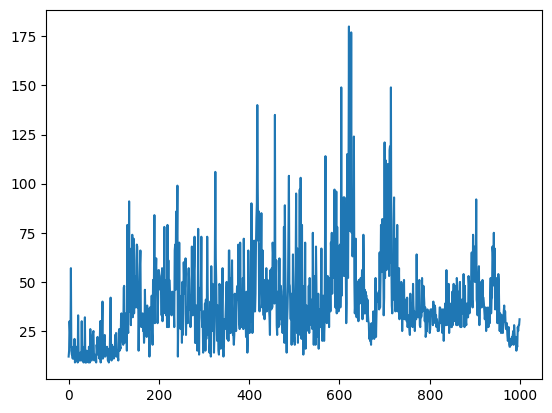

Testing for 10 episodes
Episode:1,return: 26.0
Episode:2,return: 23.0
Episode:3,return: 34.0
Episode:4,return: 33.0
Episode:5,return: 25.0
Episode:6,return: 30.0
Episode:7,return: 23.0
Episode:8,return: 24.0
Episode:9,return: 31.0
Episode:10,return: 30.0


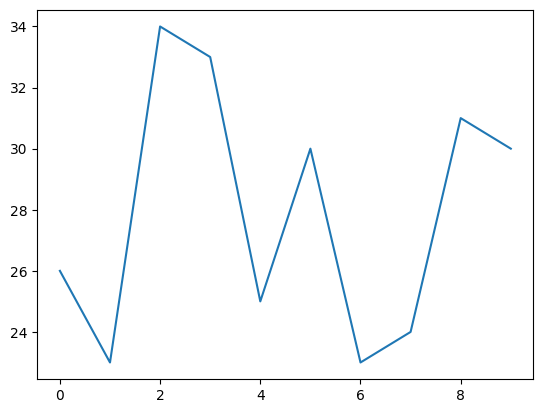

In [38]:
main(1000,3)

In [42]:
main(3000,2)

Training for 3000 episodes
1/1 [==============================] - 0s 9ms/step
Episode:1/3000,return: 15.0
1/1 [==============================] - 0s 12ms/step
Episode:2/3000,return: 17.0
1/1 [==============================] - 0s 14ms/step
Episode:3/3000,return: 14.0
1/1 [==============================] - 0s 13ms/step
Episode:4/3000,return: 14.0
1/1 [==============================] - 0s 15ms/step
Episode:5/3000,return: 19.0
1/1 [==============================] - 0s 14ms/step
Episode:6/3000,return: 11.0
1/1 [==============================] - 0s 12ms/step
Episode:7/3000,return: 14.0
1/1 [==============================] - 0s 14ms/step
Episode:8/3000,return: 12.0
1/1 [==============================] - 0s 12ms/step
Episode:9/3000,return: 15.0
1/1 [==============================] - 0s 16ms/step
Episode:10/3000,return: 12.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step
Episode:11/3000,return: 27.0
1/1 [==============================] - 0s 12ms/step
Episode:12/3000,return: 14.0
1/1 [==============================] - 0s 17ms/step
Episode:13/3000,return: 34.0
1/1 [==============================] - 0s 15ms/step
Episode:14/3000,return: 14.0
1/1 [==============================] - 0s 11ms/step
Episode:15/3000,return: 35.0
1/1 [==============================] - 0s 14ms/step
Episode:16/3000,return: 13.0
1/1 [==============================] - 0s 12ms/step
Episode:17/3000,return: 20.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 13ms/step
Episode:18/3000,return: 12.0
1/1 [==============================] - 0s 13ms/step
Episode:19/3000,return: 11.0
1/1 [==============================] - 0s 11ms/step
Episode:20/3000,return: 18.0
1/1 [==============================] - 0s 32ms/step
Episode:21/3000,return: 14.0
1/1 [==============================] - 0s 12ms/step
Episode:22/3000,return: 10.0
1/1 [==============================] - 0s 9ms/step
Episode:23/3000,return: 13.0
1/1 [==============================] - 0s 18ms/step
Episode:24/3000,return: 10.0
1/1 [==============================] - 0s 10ms/step
Episode:25/3000,return: 13.0
1/1 [==============================] - 0s 16ms/step
Episode:26/3000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:27/3000,return: 24.0
1/1 [==============================] - 0s 19ms/step
Episode:28/3000,return: 17.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 16ms/step
Episode:29/3000,return: 13.0
1/1 [==============================] - 0s 19ms/step
Episode:30/3000,return: 11.0
1/1 [==============================] - 0s 15ms/step
Episode:31/3000,return: 16.0
1/1 [==============================] - 0s 14ms/step
Episode:32/3000,return: 20.0
1/1 [==============================] - 0s 10ms/step
Episode:33/3000,return: 12.0
1/1 [==============================] - 0s 10ms/step
Episode:34/3000,return: 10.0
1/1 [==============================] - 0s 9ms/step
Episode:35/3000,return: 23.0
1/1 [==============================] - 0s 14ms/step
Episode:36/3000,return: 10.0
1/1 [==============================] - 0s 21ms/step
Episode:37/3000,return: 19.0
1/1 [==============================] - 0s 10ms/step
Episode:38/3000,return: 11.0
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 13ms/step
Episode:39/3000,return: 14.0
1/1 [==============================] - 0s 9ms/step
Episode:40/3000,return: 15.0
1/1 [==============================] - 0s 12ms/step
Episode:41/3000,return: 30.0
1/1 [==============================] - 0s 12ms/step
Episode:42/3000,return: 12.0
1/1 [==============================] - 0s 10ms/step
Episode:43/3000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:44/3000,return: 15.0
1/1 [==============================] - 0s 20ms/step
Episode:45/3000,return: 13.0
1/1 [==============================] - 0s 8ms/step
Episode:46/3000,return: 12.0
1/1 [==============================] - 0s 11ms/step
Episode:47/3000,return: 13.0
1/1 [==============================] - 0s 12ms/step
Episode:48/3000,return: 12.0
1/1 [==============================] - 0s 10ms/step
Episode:49/3000,return: 9.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 20ms/step
Episode:50/3000,return: 14.0
1/1 [==============================] - 0s 10ms/step
Episode:51/3000,return: 16.0
1/1 [==============================] - 0s 9ms/step
Episode:52/3000,return: 13.0
1/1 [==============================] - 0s 18ms/step
Episode:53/3000,return: 14.0
1/1 [==============================] - 0s 13ms/step
Episode:54/3000,return: 13.0
1/1 [==============================] - 0s 13ms/step
Episode:55/3000,return: 12.0
1/1 [==============================] - 0s 17ms/step
Episode:56/3000,return: 22.0
1/1 [==============================] - 0s 12ms/step
Episode:57/3000,return: 11.0
1/1 [==============================] - 0s 9ms/step
Episode:58/3000,return: 10.0
1/1 [==============================] - 0s 11ms/step
Episode:59/3000,return: 19.0
1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step
Episode:60/3000,return: 19.0
1/1 [==============================] - 0s 11ms/step
Episode:61/3000,return: 14.0
1/1 [==============================] - 0s 18ms/step
Episode:62/3000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:63/3000,return: 23.0
1/1 [==============================] - 0s 20ms/step
Episode:64/3000,return: 21.0
1/1 [==============================] - 0s 15ms/step
Episode:65/3000,return: 11.0
1/1 [==============================] - 0s 10ms/step
Episode:66/3000,return: 12.0
1/1 [==============================] - 0s 10ms/step
Episode:67/3000,return: 18.0
1/1 [==============================] - 0s 17ms/step
Episode:68/3000,return: 12.0
1/1 [==============================] - 0s 24ms/step
Episode:69/3000,return: 16.0
1/1 [==============================] - 0s 21ms/step
Episode:70/3000,return: 10.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 9ms/step
Episode:71/3000,return: 28.0
1/1 [==============================] - 0s 10ms/step
Episode:72/3000,return: 11.0
1/1 [==============================] - 0s 19ms/step
Episode:73/3000,return: 12.0
1/1 [==============================] - 0s 12ms/step
Episode:74/3000,return: 13.0
1/1 [==============================] - 0s 16ms/step
Episode:75/3000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:76/3000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:77/3000,return: 12.0
1/1 [==============================] - 0s 13ms/step
Episode:78/3000,return: 15.0
1/1 [==============================] - 0s 9ms/step
Episode:79/3000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:80/3000,return: 10.0
1/1 [==============================] - 0s 10ms/step
Episode:81/3000,return: 10.0
1/1 [==============================] - 0s 30ms/step
Episode:82/3000,return: 11.0
1/1 [===========================

1/1 [==============================] - 0s 10ms/step
Episode:83/3000,return: 17.0
1/1 [==============================] - 0s 13ms/step
Episode:84/3000,return: 9.0
1/1 [==============================] - 0s 11ms/step
Episode:85/3000,return: 10.0
1/1 [==============================] - 0s 13ms/step
Episode:86/3000,return: 11.0
1/1 [==============================] - 0s 11ms/step
Episode:87/3000,return: 13.0
1/1 [==============================] - 0s 12ms/step
Episode:88/3000,return: 10.0
1/1 [==============================] - 0s 10ms/step
Episode:89/3000,return: 11.0
1/1 [==============================] - 0s 11ms/step
Episode:90/3000,return: 9.0
1/1 [==============================] - 0s 12ms/step
Episode:91/3000,return: 10.0
1/1 [==============================] - 0s 12ms/step
Episode:92/3000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:93/3000,return: 15.0
1/1 [==============================] - 0s 13ms/step
Episode:94/3000,return: 10.0
1/1 [=========================

1/1 [==============================] - 0s 9ms/step
Episode:97/3000,return: 17.0
1/1 [==============================] - 0s 9ms/step
Episode:98/3000,return: 13.0
1/1 [==============================] - 0s 23ms/step
Episode:99/3000,return: 9.0
1/1 [==============================] - 0s 13ms/step
Episode:100/3000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:101/3000,return: 22.0
1/1 [==============================] - 0s 15ms/step
Episode:102/3000,return: 15.0
1/1 [==============================] - 0s 17ms/step
Episode:103/3000,return: 10.0
1/1 [==============================] - 0s 13ms/step
Episode:104/3000,return: 10.0
1/1 [==============================] - 0s 10ms/step
Episode:105/3000,return: 9.0
1/1 [==============================] - 0s 11ms/step
Episode:106/3000,return: 12.0
1/1 [==============================] - 0s 19ms/step
Episode:107/3000,return: 13.0
1/1 [==============================] - 0s 26ms/step
Episode:108/3000,return: 9.0
1/1 [===================

1/1 [==============================] - 0s 30ms/step
Episode:109/3000,return: 10.0
1/1 [==============================] - 0s 13ms/step
Episode:110/3000,return: 9.0
1/1 [==============================] - 0s 13ms/step
Episode:111/3000,return: 12.0
1/1 [==============================] - 0s 12ms/step
Episode:112/3000,return: 10.0
1/1 [==============================] - 0s 13ms/step
Episode:113/3000,return: 9.0
1/1 [==============================] - 0s 12ms/step
Episode:114/3000,return: 10.0
1/1 [==============================] - 0s 9ms/step
Episode:115/3000,return: 9.0
1/1 [==============================] - 0s 11ms/step
Episode:116/3000,return: 14.0
1/1 [==============================] - 0s 9ms/step
Episode:117/3000,return: 10.0
1/1 [==============================] - 0s 11ms/step
Episode:118/3000,return: 24.0
1/1 [==============================] - 0s 10ms/step
Episode:119/3000,return: 13.0
1/1 [==============================] - 0s 10ms/step
Episode:120/3000,return: 13.0
1/1 [================

1/1 [==============================] - 0s 12ms/step
Episode:122/3000,return: 14.0
1/1 [==============================] - 0s 9ms/step
Episode:123/3000,return: 22.0
1/1 [==============================] - 0s 9ms/step
Episode:124/3000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:125/3000,return: 17.0
1/1 [==============================] - 0s 14ms/step
Episode:126/3000,return: 14.0
1/1 [==============================] - 0s 9ms/step
Episode:127/3000,return: 9.0
1/1 [==============================] - 0s 23ms/step
Episode:128/3000,return: 10.0
1/1 [==============================] - 0s 13ms/step
Episode:129/3000,return: 10.0
1/1 [==============================] - 0s 9ms/step
Episode:130/3000,return: 11.0
1/1 [==============================] - 0s 13ms/step
Episode:131/3000,return: 9.0
1/1 [==============================] - 0s 9ms/step
Episode:132/3000,return: 14.0
1/1 [==============================] - 0s 30ms/step
Episode:133/3000,return: 10.0
1/1 [==================

1/1 [==============================] - 0s 16ms/step
Episode:134/3000,return: 18.0
1/1 [==============================] - 0s 32ms/step
Episode:135/3000,return: 10.0
1/1 [==============================] - 0s 12ms/step
Episode:136/3000,return: 12.0
1/1 [==============================] - 0s 20ms/step
Episode:137/3000,return: 15.0
1/1 [==============================] - 0s 12ms/step
Episode:138/3000,return: 12.0
1/1 [==============================] - 0s 11ms/step
Episode:139/3000,return: 9.0
1/1 [==============================] - 0s 22ms/step
Episode:140/3000,return: 9.0
1/1 [==============================] - 0s 12ms/step
Episode:141/3000,return: 11.0
1/1 [==============================] - 0s 12ms/step
Episode:142/3000,return: 9.0
1/1 [==============================] - 0s 12ms/step
Episode:143/3000,return: 12.0
1/1 [==============================] - 0s 26ms/step
Episode:144/3000,return: 9.0
1/1 [==============================] - 0s 20ms/step
Episode:145/3000,return: 16.0
1/1 [===============

1/1 [==============================] - 0s 9ms/step
Episode:146/3000,return: 16.0
1/1 [==============================] - 0s 15ms/step
Episode:147/3000,return: 10.0
1/1 [==============================] - 0s 9ms/step
Episode:148/3000,return: 12.0
1/1 [==============================] - 0s 10ms/step
Episode:149/3000,return: 10.0
1/1 [==============================] - 0s 10ms/step
Episode:150/3000,return: 12.0
1/1 [==============================] - 0s 19ms/step
Episode:151/3000,return: 10.0
1/1 [==============================] - 0s 11ms/step
Episode:152/3000,return: 8.0
1/1 [==============================] - 0s 13ms/step
Episode:153/3000,return: 10.0
1/1 [==============================] - 0s 10ms/step
Episode:154/3000,return: 12.0
1/1 [==============================] - 0s 11ms/step
Episode:155/3000,return: 13.0
1/1 [==============================] - 0s 13ms/step
Episode:156/3000,return: 9.0
1/1 [==============================] - 0s 10ms/step
Episode:157/3000,return: 10.0
1/1 [===============

1/1 [==============================] - 0s 11ms/step
Episode:159/3000,return: 19.0
1/1 [==============================] - 0s 14ms/step
Episode:160/3000,return: 11.0
1/1 [==============================] - 0s 15ms/step
Episode:161/3000,return: 13.0
1/1 [==============================] - 0s 11ms/step
Episode:162/3000,return: 13.0
1/1 [==============================] - 0s 11ms/step
Episode:163/3000,return: 16.0
1/1 [==============================] - 0s 13ms/step
Episode:164/3000,return: 9.0
1/1 [==============================] - 0s 9ms/step
Episode:165/3000,return: 9.0
1/1 [==============================] - 0s 11ms/step
Episode:166/3000,return: 9.0
1/1 [==============================] - 0s 22ms/step
Episode:167/3000,return: 10.0
1/1 [==============================] - 0s 22ms/step
Episode:168/3000,return: 10.0
1/1 [==============================] - 0s 11ms/step
Episode:169/3000,return: 9.0
1/1 [==============================] - 0s 22ms/step
Episode:170/3000,return: 14.0
1/1 [================

1/1 [==============================] - 0s 21ms/step
Episode:172/3000,return: 10.0
1/1 [==============================] - 0s 19ms/step
Episode:173/3000,return: 16.0
1/1 [==============================] - 0s 14ms/step
Episode:174/3000,return: 15.0
1/1 [==============================] - 0s 27ms/step
Episode:175/3000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:176/3000,return: 10.0
1/1 [==============================] - 0s 36ms/step
Episode:177/3000,return: 10.0
1/1 [==============================] - 0s 22ms/step
Episode:178/3000,return: 14.0
1/1 [==============================] - 0s 18ms/step
Episode:179/3000,return: 10.0
1/1 [==============================] - 0s 12ms/step
Episode:180/3000,return: 12.0
1/1 [==============================] - 0s 12ms/step
Episode:181/3000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:182/3000,return: 10.0
1/1 [==============================] - 0s 11ms/step
Episode:183/3000,return: 9.0
1/1 [=============

1/1 [==============================] - 0s 17ms/step
Episode:186/3000,return: 9.0
1/1 [==============================] - 0s 27ms/step
Episode:187/3000,return: 10.0
1/1 [==============================] - 0s 23ms/step
Episode:188/3000,return: 14.0
1/1 [==============================] - 0s 14ms/step
Episode:189/3000,return: 18.0
1/1 [==============================] - 0s 11ms/step
Episode:190/3000,return: 14.0
1/1 [==============================] - 0s 20ms/step
Episode:191/3000,return: 12.0
1/1 [==============================] - 0s 14ms/step
Episode:192/3000,return: 12.0
1/1 [==============================] - 0s 13ms/step
Episode:193/3000,return: 12.0
1/1 [==============================] - 0s 12ms/step
Episode:194/3000,return: 12.0
1/1 [==============================] - 0s 35ms/step
Episode:195/3000,return: 15.0
1/1 [==============================] - 0s 28ms/step
Episode:196/3000,return: 10.0
1/1 [==============================] - 0s 13ms/step
Episode:197/3000,return: 10.0
1/1 [============

1/1 [==============================] - 0s 12ms/step
Episode:198/3000,return: 21.0
1/1 [==============================] - 0s 20ms/step
Episode:199/3000,return: 17.0
1/1 [==============================] - 0s 14ms/step
Episode:200/3000,return: 18.0
1/1 [==============================] - 0s 19ms/step
Episode:201/3000,return: 14.0
1/1 [==============================] - 0s 15ms/step
Episode:202/3000,return: 22.0
1/1 [==============================] - 0s 15ms/step
Episode:203/3000,return: 9.0
1/1 [==============================] - 0s 10ms/step
Episode:204/3000,return: 8.0
1/1 [==============================] - 0s 11ms/step
Episode:205/3000,return: 26.0
1/1 [==============================] - 0s 12ms/step
Episode:206/3000,return: 17.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 21ms/step
Episode:207/3000,return: 26.0
1/1 [==============================] - 0s 16ms/step
Episode:208/3000,return: 10.0
1/1 [==============================] - 0s 27ms/step
Episode:209/3000,return: 11.0
1/1 [==============================] - 0s 13ms/step
Episode:210/3000,return: 18.0
1/1 [==============================] - 0s 12ms/step
Episode:211/3000,return: 28.0
1/1 [==============================] - 0s 9ms/step
Episode:212/3000,return: 9.0
1/1 [==============================] - 0s 11ms/step
Episode:213/3000,return: 9.0
1/1 [==============================] - 0s 14ms/step
Episode:214/3000,return: 14.0
1/1 [==============================] - 0s 10ms/step
Episode:215/3000,return: 11.0
1/1 [==============================] - 0s 13ms/step
Episode:216/3000,return: 13.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 28ms/step
Episode:217/3000,return: 17.0
1/1 [==============================] - 0s 12ms/step
Episode:218/3000,return: 10.0
1/1 [==============================] - 0s 9ms/step
Episode:219/3000,return: 9.0
1/1 [==============================] - 0s 13ms/step
Episode:220/3000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:221/3000,return: 13.0
1/1 [==============================] - 0s 11ms/step
Episode:222/3000,return: 8.0
1/1 [==============================] - 0s 18ms/step
Episode:223/3000,return: 21.0
1/1 [==============================] - 0s 12ms/step
Episode:224/3000,return: 13.0
1/1 [==============================] - 0s 21ms/step
Episode:225/3000,return: 11.0
1/1 [==============================] - 0s 18ms/step
Episode:226/3000,return: 15.0
1/1 [==============================] - 0s 10ms/step
Episode:227/3000,return: 12.0
1/1 [==============================] - 0s 10ms/step
Episode:228/3000,return: 14.0
1/1 [==============

1/1 [==============================] - 0s 10ms/step
Episode:229/3000,return: 9.0
1/1 [==============================] - 0s 40ms/step
Episode:230/3000,return: 13.0
1/1 [==============================] - 0s 11ms/step
Episode:231/3000,return: 15.0
1/1 [==============================] - 0s 24ms/step
Episode:232/3000,return: 22.0
1/1 [==============================] - 0s 18ms/step
Episode:233/3000,return: 12.0
1/1 [==============================] - 0s 11ms/step
Episode:234/3000,return: 10.0
1/1 [==============================] - 0s 22ms/step
Episode:235/3000,return: 9.0
1/1 [==============================] - 0s 14ms/step
Episode:236/3000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:237/3000,return: 13.0
1/1 [==============================] - 0s 17ms/step
Episode:238/3000,return: 12.0
1/1 [==============================] - 0s 9ms/step
Episode:239/3000,return: 19.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 19ms/step
Episode:240/3000,return: 13.0
1/1 [==============================] - 0s 18ms/step
Episode:241/3000,return: 15.0
1/1 [==============================] - 0s 10ms/step
Episode:242/3000,return: 16.0
1/1 [==============================] - 0s 12ms/step
Episode:243/3000,return: 19.0
1/1 [==============================] - 0s 12ms/step
Episode:244/3000,return: 13.0
1/1 [==============================] - 0s 9ms/step
Episode:245/3000,return: 33.0
1/1 [==============================] - 0s 13ms/step
Episode:246/3000,return: 14.0
1/1 [==============================] - 0s 14ms/step
Episode:247/3000,return: 24.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
Episode:248/3000,return: 36.0
1/1 [==============================] - 0s 12ms/step
Episode:249/3000,return: 11.0
1/1 [==============================] - 0s 10ms/step
Episode:250/3000,return: 28.0
1/1 [==============================] - 0s 12ms/step
Episode:251/3000,return: 11.0
1/1 [==============================] - 0s 12ms/step
Episode:252/3000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:253/3000,return: 10.0
1/1 [==============================] - 0s 19ms/step
Episode:254/3000,return: 15.0
1/1 [==============================] - 0s 21ms/step
Episode:255/3000,return: 18.0
1/1 [==============================] - 0s 19ms/step
Episode:256/3000,return: 14.0
1/1 [==============================] - 0s 23ms/step
Episode:257/3000,return: 11.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 14ms/step
Episode:258/3000,return: 12.0
1/1 [==============================] - 0s 40ms/step
Episode:259/3000,return: 13.0
1/1 [==============================] - 0s 16ms/step
Episode:260/3000,return: 11.0
1/1 [==============================] - 0s 12ms/step
Episode:261/3000,return: 9.0
1/1 [==============================] - 0s 12ms/step
Episode:262/3000,return: 10.0
1/1 [==============================] - 0s 10ms/step
Episode:263/3000,return: 42.0
1/1 [==============================] - 0s 12ms/step
Episode:264/3000,return: 14.0
1/1 [==============================] - 0s 12ms/step
Episode:265/3000,return: 10.0
1/1 [==============================] - 0s 13ms/step
Episode:266/3000,return: 13.0
1/1 [==============================] - 0s 13ms/step
Episode:267/3000,return: 11.0
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 33ms/step
Episode:268/3000,return: 10.0
1/1 [==============================] - 0s 20ms/step


2022-11-22 21:07:11.458381: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 14ms/step
Episode:269/3000,return: 17.0
1/1 [==============================] - 0s 13ms/step
Episode:270/3000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:271/3000,return: 30.0
1/1 [==============================] - 0s 10ms/step
Episode:272/3000,return: 13.0
1/1 [==============================] - 0s 15ms/step
Episode:273/3000,return: 11.0
1/1 [==============================] - 0s 17ms/step
Episode:274/3000,return: 12.0
1/1 [==============================] - 0s 14ms/step
Episode:275/3000,return: 17.0
1/1 [==============================] - 0s 11ms/step
Episode:276/3000,return: 28.0
1/1 [==============================] - 0s 13ms/step
Episode:277/3000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:278/3000,return: 8.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step
Episode:279/3000,return: 11.0
1/1 [==============================] - 0s 10ms/step
Episode:280/3000,return: 34.0
1/1 [==============================] - 0s 16ms/step
Episode:281/3000,return: 13.0
1/1 [==============================] - 0s 15ms/step
Episode:282/3000,return: 16.0
1/1 [==============================] - 0s 14ms/step
Episode:283/3000,return: 19.0
1/1 [==============================] - 0s 11ms/step
Episode:284/3000,return: 11.0
1/1 [==============================] - 0s 13ms/step
Episode:285/3000,return: 12.0
1/1 [==============================] - 0s 13ms/step
Episode:286/3000,return: 8.0
1/1 [==============================] - 0s 12ms/step
Episode:287/3000,return: 11.0
1/1 [==============================] - 0s 13ms/step
Episode:288/3000,return: 15.0
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step
Episode:289/3000,return: 9.0
1/1 [==============================] - 0s 18ms/step
Episode:290/3000,return: 9.0
1/1 [==============================] - 0s 19ms/step
Episode:291/3000,return: 12.0
1/1 [==============================] - 0s 10ms/step
Episode:292/3000,return: 10.0
1/1 [==============================] - 0s 24ms/step
Episode:293/3000,return: 12.0
1/1 [==============================] - 0s 11ms/step
Episode:294/3000,return: 14.0
1/1 [==============================] - 0s 12ms/step
Episode:295/3000,return: 22.0
1/1 [==============================] - 0s 14ms/step
Episode:296/3000,return: 20.0
1/1 [==============================] - 0s 23ms/step
Episode:297/3000,return: 9.0
1/1 [==============================] - 0s 13ms/step
Episode:298/3000,return: 13.0
1/1 [==============================] - 0s 9ms/step
Episode:299/3000,return: 9.0
1/1 [==============================] - 0s 14ms/step
Episode:300/3000,return: 13.0
1/1 [================

1/1 [==============================] - 0s 15ms/step
Episode:301/3000,return: 13.0
1/1 [==============================] - 0s 13ms/step
Episode:302/3000,return: 9.0
1/1 [==============================] - 0s 12ms/step
Episode:303/3000,return: 19.0
1/1 [==============================] - 0s 17ms/step
Episode:304/3000,return: 30.0
1/1 [==============================] - 0s 14ms/step
Episode:305/3000,return: 30.0
1/1 [==============================] - 0s 14ms/step
Episode:306/3000,return: 21.0
1/1 [==============================] - 0s 30ms/step
Episode:307/3000,return: 11.0
1/1 [==============================] - 0s 13ms/step
Episode:308/3000,return: 17.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 9ms/step
Episode:309/3000,return: 11.0
1/1 [==============================] - 0s 12ms/step
Episode:310/3000,return: 12.0
1/1 [==============================] - 0s 10ms/step
Episode:311/3000,return: 12.0
1/1 [==============================] - 0s 21ms/step
Episode:312/3000,return: 19.0
1/1 [==============================] - 0s 23ms/step
Episode:313/3000,return: 26.0
1/1 [==============================] - 0s 19ms/step
Episode:314/3000,return: 16.0
1/1 [==============================] - 0s 12ms/step
Episode:315/3000,return: 16.0
1/1 [==============================] - 0s 13ms/step
Episode:316/3000,return: 12.0
1/1 [==============================] - 0s 10ms/step
Episode:317/3000,return: 16.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 11ms/step
Episode:318/3000,return: 33.0
1/1 [==============================] - 0s 20ms/step
Episode:319/3000,return: 21.0
1/1 [==============================] - 0s 10ms/step
Episode:320/3000,return: 10.0
1/1 [==============================] - 0s 11ms/step
Episode:321/3000,return: 24.0
1/1 [==============================] - 0s 9ms/step
Episode:322/3000,return: 16.0
1/1 [==============================] - 0s 12ms/step
Episode:323/3000,return: 14.0
1/1 [==============================] - 0s 10ms/step
Episode:324/3000,return: 33.0
1/1 [==============================] - 0s 17ms/step
Episode:325/3000,return: 15.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 13ms/step
Episode:326/3000,return: 26.0
1/1 [==============================] - 0s 17ms/step
Episode:327/3000,return: 37.0
1/1 [==============================] - 0s 20ms/step
Episode:328/3000,return: 36.0
1/1 [==============================] - 0s 52ms/step
Episode:329/3000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:330/3000,return: 26.0
1/1 [==============================] - 0s 51ms/step
Episode:331/3000,return: 17.0
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 9ms/step
Episode:332/3000,return: 23.0
1/1 [==============================] - 0s 27ms/step
Episode:333/3000,return: 26.0
1/1 [==============================] - 0s 19ms/step
Episode:334/3000,return: 11.0
1/1 [==============================] - 0s 22ms/step
Episode:335/3000,return: 28.0
1/1 [==============================] - 0s 16ms/step
Episode:336/3000,return: 25.0
1/1 [==============================] - 0s 22ms/step
Episode:337/3000,return: 24.0
1/1 [==============================] - 0s 18ms/step
Episode:338/3000,return: 26.0


1/1 [==============================] - 0s 10ms/step
Episode:339/3000,return: 21.0
1/1 [==============================] - 0s 12ms/step
Episode:340/3000,return: 14.0
1/1 [==============================] - 0s 14ms/step
Episode:341/3000,return: 14.0
1/1 [==============================] - 0s 14ms/step
Episode:342/3000,return: 33.0
1/1 [==============================] - 0s 12ms/step
Episode:343/3000,return: 38.0
1/1 [==============================] - 0s 19ms/step
Episode:344/3000,return: 14.0
1/1 [==============================] - 0s 39ms/step
Episode:345/3000,return: 15.0
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 11ms/step
Episode:346/3000,return: 13.0
1/1 [==============================] - 0s 14ms/step
Episode:347/3000,return: 12.0
1/1 [==============================] - 0s 19ms/step
Episode:348/3000,return: 39.0
1/1 [==============================] - 0s 9ms/step
Episode:349/3000,return: 15.0
1/1 [==============================] - 0s 11ms/step
Episode:350/3000,return: 22.0
1/1 [==============================] - 0s 12ms/step
Episode:351/3000,return: 49.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Episode:352/3000,return: 32.0
1/1 [==============================] - 0s 19ms/step
Episode:353/3000,return: 14.0
1/1 [==============================] - 0s 20ms/step
Episode:354/3000,return: 18.0
1/1 [==============================] - 0s 11ms/step
Episode:355/3000,return: 15.0
1/1 [==============================] - 0s 16ms/step
Episode:356/3000,return: 25.0
1/1 [==============================] - 0s 14ms/step
Episode:357/3000,return: 24.0
1/1 [==============================] - 0s 12ms/step
Episode:358/3000,return: 16.0
1/1 [==============================] - 0s 45ms/step
Episode:359/3000,return: 11.0
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 15ms/step
Episode:360/3000,return: 11.0
1/1 [==============================] - 0s 27ms/step
Episode:361/3000,return: 23.0
1/1 [==============================] - 0s 11ms/step
Episode:362/3000,return: 18.0
1/1 [==============================] - 0s 18ms/step
Episode:363/3000,return: 23.0
1/1 [==============================] - 0s 16ms/step
Episode:364/3000,return: 18.0
1/1 [==============================] - 0s 12ms/step
Episode:365/3000,return: 26.0
1/1 [==============================] - 0s 16ms/step
Episode:366/3000,return: 17.0
1/1 [==============================] - 0s 29ms/step
Episode:367/3000,return: 16.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step
Episode:368/3000,return: 42.0
1/1 [==============================] - 0s 18ms/step
Episode:369/3000,return: 24.0
1/1 [==============================] - 0s 13ms/step
Episode:370/3000,return: 19.0
1/1 [==============================] - 0s 17ms/step
Episode:371/3000,return: 20.0
1/1 [==============================] - 0s 25ms/step
Episode:372/3000,return: 25.0
1/1 [==============================] - 0s 13ms/step
Episode:373/3000,return: 23.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 15ms/step
Episode:374/3000,return: 40.0
1/1 [==============================] - 0s 12ms/step
Episode:375/3000,return: 17.0
1/1 [==============================] - 0s 16ms/step
Episode:376/3000,return: 26.0
1/1 [==============================] - 0s 16ms/step
Episode:377/3000,return: 31.0
1/1 [==============================] - 0s 10ms/step
Episode:378/3000,return: 27.0
1/1 [==============================] - 0s 15ms/step
Episode:379/3000,return: 21.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 48ms/step
Episode:380/3000,return: 21.0
1/1 [==============================] - 0s 29ms/step
Episode:381/3000,return: 13.0
1/1 [==============================] - 0s 12ms/step
Episode:382/3000,return: 11.0
1/1 [==============================] - 0s 18ms/step
Episode:383/3000,return: 17.0
1/1 [==============================] - 0s 34ms/step
Episode:384/3000,return: 18.0
1/1 [==============================] - 0s 9ms/step
Episode:385/3000,return: 15.0
1/1 [==============================] - 0s 10ms/step
Episode:386/3000,return: 19.0
1/1 [==============================] - 0s 14ms/step
Episode:387/3000,return: 17.0
1/1 [==============================] - 0s 16ms/step
Episode:388/3000,return: 16.0
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 10ms/step
Episode:389/3000,return: 18.0
1/1 [==============================] - 0s 13ms/step
Episode:390/3000,return: 12.0
1/1 [==============================] - 0s 16ms/step
Episode:391/3000,return: 16.0
1/1 [==============================] - 0s 14ms/step
Episode:392/3000,return: 15.0
1/1 [==============================] - 0s 11ms/step
Episode:393/3000,return: 20.0
1/1 [==============================] - 0s 12ms/step
Episode:394/3000,return: 14.0
1/1 [==============================] - 0s 10ms/step
Episode:395/3000,return: 20.0
1/1 [==============================] - 0s 14ms/step
Episode:396/3000,return: 27.0
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 16ms/step
Episode:397/3000,return: 19.0
1/1 [==============================] - 0s 13ms/step
Episode:398/3000,return: 17.0
1/1 [==============================] - 0s 12ms/step
Episode:399/3000,return: 33.0
1/1 [==============================] - 0s 13ms/step
Episode:400/3000,return: 21.0
1/1 [==============================] - 0s 19ms/step
Episode:401/3000,return: 16.0
1/1 [==============================] - 0s 10ms/step
Episode:402/3000,return: 15.0
1/1 [==============================] - 0s 14ms/step
Episode:403/3000,return: 18.0
1/1 [==============================] - 0s 17ms/step
Episode:404/3000,return: 19.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 9ms/step
Episode:405/3000,return: 24.0
1/1 [==============================] - 0s 11ms/step
Episode:406/3000,return: 23.0
1/1 [==============================] - 0s 9ms/step
Episode:407/3000,return: 18.0
1/1 [==============================] - 0s 17ms/step
Episode:408/3000,return: 13.0
1/1 [==============================] - 0s 10ms/step
Episode:409/3000,return: 26.0
1/1 [==============================] - 0s 11ms/step
Episode:410/3000,return: 23.0
1/1 [==============================] - 0s 13ms/step
Episode:411/3000,return: 20.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 12ms/step
Episode:412/3000,return: 49.0
1/1 [==============================] - 0s 25ms/step
Episode:413/3000,return: 23.0
1/1 [==============================] - 0s 11ms/step
Episode:414/3000,return: 34.0
1/1 [==============================] - 0s 11ms/step
Episode:415/3000,return: 39.0
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 37ms/step
Episode:416/3000,return: 32.0
1/1 [==============================] - 0s 17ms/step
Episode:417/3000,return: 38.0
1/1 [==============================] - 0s 23ms/step
Episode:418/3000,return: 24.0
1/1 [==============================] - 0s 14ms/step
Episode:419/3000,return: 36.0
1/1 [==============================] - 0s 10ms/step
Episode:420/3000,return: 41.0
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
Episode:421/3000,return: 51.0
1/1 [==============================] - 0s 15ms/step
Episode:422/3000,return: 41.0
1/1 [==============================] - 0s 10ms/step
Episode:423/3000,return: 40.0
1/1 [==============================] - 0s 20ms/step


Episode:424/3000,return: 35.0
1/1 [==============================] - 0s 18ms/step
Episode:425/3000,return: 62.0
1/1 [==============================] - 0s 10ms/step
Episode:426/3000,return: 48.0
1/1 [==============================] - 0s 29ms/step
Episode:427/3000,return: 33.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step
Episode:428/3000,return: 28.0
1/1 [==============================] - 0s 17ms/step
Episode:429/3000,return: 28.0
1/1 [==============================] - 0s 11ms/step
Episode:430/3000,return: 26.0
1/1 [==============================] - 0s 17ms/step
Episode:431/3000,return: 24.0
1/1 [==============================] - 0s 16ms/step
Episode:432/3000,return: 35.0
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 23ms/step
Episode:433/3000,return: 40.0
1/1 [==============================] - 0s 10ms/step
Episode:434/3000,return: 44.0
1/1 [==============================] - 0s 13ms/step
Episode:435/3000,return: 22.0
1/1 [==============================] - 0s 29ms/step
Episode:436/3000,return: 30.0
1/1 [==============================] - 0s 11ms/step
Episode:437/3000,return: 24.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
Episode:438/3000,return: 43.0
1/1 [==============================] - 0s 11ms/step
Episode:439/3000,return: 37.0
1/1 [==============================] - 0s 38ms/step
Episode:440/3000,return: 45.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step
Episode:441/3000,return: 72.0
1/1 [==============================] - 0s 22ms/step
Episode:442/3000,return: 37.0
1/1 [==============================] - 0s 12ms/step
Episode:443/3000,return: 27.0
1/1 [==============================] - 0s 11ms/step
Episode:444/3000,return: 21.0
1/1 [==============================] - 0s 24ms/step
Episode:445/3000,return: 28.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 16ms/step
Episode:446/3000,return: 35.0
1/1 [==============================] - 0s 14ms/step
Episode:447/3000,return: 28.0
1/1 [==============================] - 0s 17ms/step
Episode:448/3000,return: 18.0
1/1 [==============================] - 0s 12ms/step
Episode:449/3000,return: 24.0
1/1 [==============================] - 0s 15ms/step
Episode:450/3000,return: 27.0
1/1 [==============================] - 0s 11ms/step
Episode:451/3000,return: 16.0
1/1 [==============================] - 0s 12ms/step
Episode:452/3000,return: 17.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 18ms/step
Episode:453/3000,return: 25.0
1/1 [==============================] - 0s 15ms/step
Episode:454/3000,return: 21.0
1/1 [==============================] - 0s 24ms/step
Episode:455/3000,return: 23.0
1/1 [==============================] - 0s 16ms/step
Episode:456/3000,return: 17.0
1/1 [==============================] - 0s 9ms/step
Episode:457/3000,return: 21.0
1/1 [==============================] - 0s 12ms/step
Episode:458/3000,return: 13.0
1/1 [==============================] - 0s 12ms/step
Episode:459/3000,return: 19.0
1/1 [==============================] - 0s 20ms/step
Episode:460/3000,return: 15.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 15ms/step
Episode:461/3000,return: 18.0
1/1 [==============================] - 0s 11ms/step
Episode:462/3000,return: 17.0
1/1 [==============================] - 0s 11ms/step
Episode:463/3000,return: 19.0
1/1 [==============================] - 0s 25ms/step
Episode:464/3000,return: 12.0
1/1 [==============================] - 0s 17ms/step
Episode:465/3000,return: 14.0
1/1 [==============================] - 0s 17ms/step
Episode:466/3000,return: 13.0
1/1 [==============================] - 0s 14ms/step
Episode:467/3000,return: 17.0
1/1 [==============================] - 0s 19ms/step
Episode:468/3000,return: 13.0
1/1 [==============================] - 0s 21ms/step
Episode:469/3000,return: 15.0
1/1 [==============================] - 0s 12ms/step
Episode:470/3000,return: 13.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step
Episode:471/3000,return: 10.0
1/1 [==============================] - 0s 10ms/step
Episode:472/3000,return: 18.0
1/1 [==============================] - 0s 11ms/step
Episode:473/3000,return: 11.0
1/1 [==============================] - 0s 12ms/step
Episode:474/3000,return: 14.0
1/1 [==============================] - 0s 45ms/step
Episode:475/3000,return: 11.0
1/1 [==============================] - 0s 24ms/step
Episode:476/3000,return: 15.0
1/1 [==============================] - 0s 13ms/step
Episode:477/3000,return: 12.0
1/1 [==============================] - 0s 11ms/step
Episode:478/3000,return: 14.0
1/1 [==============================] - 0s 11ms/step
Episode:479/3000,return: 12.0
1/1 [==============================] - 0s 20ms/step
Episode:480/3000,return: 14.0
1/1 [==============================] - 0s 12ms/step
Episode:481/3000,return: 12.0
1/1 [==============================] - 0s 20ms/step
Episode:482/3000,return: 13.0
1/1 [===========

1/1 [==============================] - 0s 11ms/step
Episode:483/3000,return: 15.0
1/1 [==============================] - 0s 17ms/step
Episode:484/3000,return: 14.0
1/1 [==============================] - 0s 10ms/step
Episode:485/3000,return: 12.0
1/1 [==============================] - 0s 11ms/step
Episode:486/3000,return: 14.0
1/1 [==============================] - 0s 22ms/step
Episode:487/3000,return: 12.0
1/1 [==============================] - 0s 22ms/step
Episode:488/3000,return: 16.0
1/1 [==============================] - 0s 24ms/step
Episode:489/3000,return: 12.0
1/1 [==============================] - 0s 13ms/step
Episode:490/3000,return: 12.0
1/1 [==============================] - 0s 29ms/step
Episode:491/3000,return: 13.0
1/1 [==============================] - 0s 32ms/step
Episode:492/3000,return: 10.0
1/1 [==============================] - 0s 25ms/step
Episode:493/3000,return: 12.0
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 13ms/step
Episode:494/3000,return: 12.0
1/1 [==============================] - 0s 14ms/step
Episode:495/3000,return: 13.0
1/1 [==============================] - 0s 12ms/step
Episode:496/3000,return: 11.0
1/1 [==============================] - 0s 14ms/step
Episode:497/3000,return: 10.0
1/1 [==============================] - 0s 22ms/step
Episode:498/3000,return: 11.0
1/1 [==============================] - 0s 10ms/step
Episode:499/3000,return: 10.0
1/1 [==============================] - 0s 11ms/step
Episode:500/3000,return: 11.0
1/1 [==============================] - 0s 10ms/step
Episode:501/3000,return: 11.0
1/1 [==============================] - 0s 24ms/step
Episode:502/3000,return: 13.0
1/1 [==============================] - 0s 10ms/step
Episode:503/3000,return: 17.0
1/1 [==============================] - 0s 16ms/step
Episode:504/3000,return: 14.0
1/1 [==============================] - 0s 10ms/step
Episode:505/3000,return: 12.0
1/1 [===========

1/1 [==============================] - 0s 13ms/step
Episode:507/3000,return: 14.0
1/1 [==============================] - 0s 14ms/step
Episode:508/3000,return: 15.0
1/1 [==============================] - 0s 14ms/step
Episode:509/3000,return: 15.0
1/1 [==============================] - 0s 11ms/step
Episode:510/3000,return: 12.0
1/1 [==============================] - 0s 26ms/step
Episode:511/3000,return: 14.0
1/1 [==============================] - 0s 16ms/step
Episode:512/3000,return: 18.0
1/1 [==============================] - 0s 24ms/step
Episode:513/3000,return: 13.0
1/1 [==============================] - 0s 19ms/step
Episode:514/3000,return: 19.0
1/1 [==============================] - 0s 19ms/step
Episode:515/3000,return: 13.0
1/1 [==============================] - 0s 15ms/step
Episode:516/3000,return: 19.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step
Episode:517/3000,return: 17.0
1/1 [==============================] - 0s 10ms/step
Episode:518/3000,return: 12.0
1/1 [==============================] - 0s 12ms/step
Episode:519/3000,return: 14.0
1/1 [==============================] - 0s 44ms/step
Episode:520/3000,return: 13.0
1/1 [==============================] - 0s 17ms/step
Episode:521/3000,return: 14.0
1/1 [==============================] - 0s 15ms/step
Episode:522/3000,return: 16.0
1/1 [==============================] - 0s 20ms/step
Episode:523/3000,return: 12.0
1/1 [==============================] - 0s 16ms/step
Episode:524/3000,return: 12.0
1/1 [==============================] - 0s 13ms/step
Episode:525/3000,return: 17.0
1/1 [==============================] - 0s 23ms/step
Episode:526/3000,return: 12.0
1/1 [==============================] - 0s 16ms/step
Episode:527/3000,return: 11.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 15ms/step
Episode:528/3000,return: 13.0
1/1 [==============================] - 0s 14ms/step
Episode:529/3000,return: 14.0
1/1 [==============================] - 0s 12ms/step
Episode:530/3000,return: 20.0
1/1 [==============================] - 0s 32ms/step
Episode:531/3000,return: 18.0
1/1 [==============================] - 0s 14ms/step
Episode:532/3000,return: 17.0
1/1 [==============================] - 0s 11ms/step
Episode:533/3000,return: 20.0
1/1 [==============================] - 0s 15ms/step
Episode:534/3000,return: 16.0
1/1 [==============================] - 0s 10ms/step
Episode:535/3000,return: 18.0
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 11ms/step
Episode:536/3000,return: 22.0
1/1 [==============================] - 0s 12ms/step
Episode:537/3000,return: 19.0
1/1 [==============================] - 0s 13ms/step
Episode:538/3000,return: 16.0
1/1 [==============================] - 0s 11ms/step
Episode:539/3000,return: 16.0
1/1 [==============================] - 0s 21ms/step
Episode:540/3000,return: 20.0
1/1 [==============================] - 0s 21ms/step
Episode:541/3000,return: 19.0
1/1 [==============================] - 0s 9ms/step
Episode:542/3000,return: 14.0
1/1 [==============================] - 0s 10ms/step
Episode:543/3000,return: 18.0
1/1 [==============================] - 0s 30ms/step
Episode:544/3000,return: 18.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 36ms/step
Episode:545/3000,return: 19.0
1/1 [==============================] - 0s 11ms/step
Episode:546/3000,return: 18.0
1/1 [==============================] - 0s 15ms/step
Episode:547/3000,return: 17.0
1/1 [==============================] - 0s 17ms/step
Episode:548/3000,return: 14.0
1/1 [==============================] - 0s 9ms/step
Episode:549/3000,return: 15.0
1/1 [==============================] - 0s 14ms/step
Episode:550/3000,return: 20.0
1/1 [==============================] - 0s 13ms/step
Episode:551/3000,return: 20.0
1/1 [==============================] - 0s 15ms/step
Episode:552/3000,return: 18.0
1/1 [==============================] - 0s 10ms/step
Episode:553/3000,return: 17.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
Episode:554/3000,return: 11.0
1/1 [==============================] - 0s 18ms/step
Episode:555/3000,return: 13.0
1/1 [==============================] - 0s 36ms/step
Episode:556/3000,return: 14.0
1/1 [==============================] - 0s 20ms/step
Episode:557/3000,return: 17.0
1/1 [==============================] - 0s 13ms/step
Episode:558/3000,return: 14.0
1/1 [==============================] - 0s 13ms/step
Episode:559/3000,return: 13.0
1/1 [==============================] - 0s 9ms/step
Episode:560/3000,return: 13.0
1/1 [==============================] - 0s 15ms/step
Episode:561/3000,return: 11.0
1/1 [==============================] - 0s 12ms/step
Episode:562/3000,return: 13.0
1/1 [==============================] - 0s 14ms/step
Episode:563/3000,return: 16.0
1/1 [==============================] - 0s 21ms/step
Episode:564/3000,return: 13.0
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 28ms/step
Episode:565/3000,return: 12.0
1/1 [==============================] - 0s 20ms/step
Episode:566/3000,return: 11.0
1/1 [==============================] - 0s 16ms/step
Episode:567/3000,return: 15.0
1/1 [==============================] - 0s 13ms/step
Episode:568/3000,return: 11.0
1/1 [==============================] - 0s 12ms/step
Episode:569/3000,return: 14.0
1/1 [==============================] - 0s 13ms/step
Episode:570/3000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:571/3000,return: 13.0
1/1 [==============================] - 0s 15ms/step
Episode:572/3000,return: 10.0
1/1 [==============================] - 0s 12ms/step
Episode:573/3000,return: 14.0
1/1 [==============================] - 0s 10ms/step
Episode:574/3000,return: 10.0
1/1 [==============================] - 0s 19ms/step
Episode:575/3000,return: 15.0
1/1 [==============================] - 0s 20ms/step
Episode:576/3000,return: 10.0
1/1 [===========

1/1 [==============================] - 0s 13ms/step
Episode:578/3000,return: 11.0
1/1 [==============================] - 0s 14ms/step
Episode:579/3000,return: 13.0
1/1 [==============================] - 0s 16ms/step
Episode:580/3000,return: 11.0
1/1 [==============================] - 0s 11ms/step
Episode:581/3000,return: 11.0
1/1 [==============================] - 0s 18ms/step
Episode:582/3000,return: 13.0
1/1 [==============================] - 0s 17ms/step
Episode:583/3000,return: 12.0
1/1 [==============================] - 0s 10ms/step
Episode:584/3000,return: 11.0
1/1 [==============================] - 0s 10ms/step
Episode:585/3000,return: 10.0
1/1 [==============================] - 0s 10ms/step
Episode:586/3000,return: 12.0
1/1 [==============================] - 0s 19ms/step
Episode:587/3000,return: 12.0
1/1 [==============================] - 0s 14ms/step
Episode:588/3000,return: 11.0
1/1 [==============================] - 0s 13ms/step
Episode:589/3000,return: 12.0
1/1 [===========

1/1 [==============================] - 0s 14ms/step
Episode:591/3000,return: 15.0
1/1 [==============================] - 0s 15ms/step
Episode:592/3000,return: 13.0
1/1 [==============================] - 0s 10ms/step
Episode:593/3000,return: 11.0
1/1 [==============================] - 0s 17ms/step
Episode:594/3000,return: 17.0
1/1 [==============================] - 0s 15ms/step
Episode:595/3000,return: 11.0
1/1 [==============================] - 0s 10ms/step
Episode:596/3000,return: 14.0
1/1 [==============================] - 0s 18ms/step
Episode:597/3000,return: 18.0
1/1 [==============================] - 0s 23ms/step
Episode:598/3000,return: 17.0
1/1 [==============================] - 0s 10ms/step
Episode:599/3000,return: 16.0
1/1 [==============================] - 0s 19ms/step
Episode:600/3000,return: 12.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 21ms/step
Episode:601/3000,return: 16.0
1/1 [==============================] - 0s 9ms/step
Episode:602/3000,return: 12.0
1/1 [==============================] - 0s 11ms/step
Episode:603/3000,return: 15.0
1/1 [==============================] - 0s 10ms/step
Episode:604/3000,return: 17.0
1/1 [==============================] - 0s 9ms/step
Episode:605/3000,return: 11.0
1/1 [==============================] - 0s 17ms/step
Episode:606/3000,return: 16.0
1/1 [==============================] - 0s 10ms/step
Episode:607/3000,return: 9.0
1/1 [==============================] - 0s 12ms/step
Episode:608/3000,return: 15.0
1/1 [==============================] - 0s 13ms/step
Episode:609/3000,return: 16.0
1/1 [==============================] - 0s 28ms/step
Episode:610/3000,return: 16.0
1/1 [==============================] - 0s 11ms/step
Episode:611/3000,return: 14.0
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 13ms/step
Episode:612/3000,return: 12.0
1/1 [==============================] - 0s 17ms/step
Episode:613/3000,return: 20.0
1/1 [==============================] - 0s 15ms/step
Episode:614/3000,return: 18.0
1/1 [==============================] - 0s 11ms/step
Episode:615/3000,return: 14.0
1/1 [==============================] - 0s 10ms/step
Episode:616/3000,return: 17.0
1/1 [==============================] - 0s 12ms/step
Episode:617/3000,return: 18.0
1/1 [==============================] - 0s 12ms/step
Episode:618/3000,return: 15.0
1/1 [==============================] - 0s 13ms/step
Episode:619/3000,return: 17.0
1/1 [==============================] - 0s 11ms/step
Episode:620/3000,return: 18.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 9ms/step
Episode:621/3000,return: 17.0
1/1 [==============================] - 0s 10ms/step
Episode:622/3000,return: 18.0
1/1 [==============================] - 0s 17ms/step
Episode:623/3000,return: 21.0
1/1 [==============================] - 0s 18ms/step
Episode:624/3000,return: 25.0
1/1 [==============================] - 0s 12ms/step
Episode:625/3000,return: 21.0
1/1 [==============================] - 0s 15ms/step
Episode:626/3000,return: 21.0
1/1 [==============================] - 0s 12ms/step
Episode:627/3000,return: 24.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 11ms/step
Episode:628/3000,return: 16.0
1/1 [==============================] - 0s 11ms/step
Episode:629/3000,return: 29.0
1/1 [==============================] - 0s 11ms/step
Episode:630/3000,return: 18.0
1/1 [==============================] - 0s 16ms/step
Episode:631/3000,return: 23.0
1/1 [==============================] - 0s 17ms/step
Episode:632/3000,return: 23.0
1/1 [==============================] - 0s 17ms/step
Episode:633/3000,return: 21.0
1/1 [==============================] - 0s 15ms/step
Episode:634/3000,return: 24.0
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 10ms/step
Episode:635/3000,return: 17.0
1/1 [==============================] - 0s 10ms/step
Episode:636/3000,return: 30.0
1/1 [==============================] - 0s 18ms/step
Episode:637/3000,return: 27.0
1/1 [==============================] - 0s 12ms/step
Episode:638/3000,return: 24.0
1/1 [==============================] - 0s 10ms/step
Episode:639/3000,return: 28.0
1/1 [==============================] - 0s 11ms/step
Episode:640/3000,return: 28.0
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 10ms/step
Episode:641/3000,return: 29.0
1/1 [==============================] - 0s 18ms/step
Episode:642/3000,return: 17.0
1/1 [==============================] - 0s 12ms/step
Episode:643/3000,return: 26.0
1/1 [==============================] - 0s 9ms/step


2022-11-22 21:22:55.590887: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 11ms/step
Episode:644/3000,return: 25.0
1/1 [==============================] - 0s 13ms/step
Episode:645/3000,return: 21.0
1/1 [==============================] - 0s 9ms/step
Episode:646/3000,return: 31.0
1/1 [==============================] - 0s 10ms/step
Episode:647/3000,return: 41.0
1/1 [==============================] - 0s 10ms/step
Episode:648/3000,return: 29.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Episode:649/3000,return: 38.0
1/1 [==============================] - 0s 16ms/step
Episode:650/3000,return: 28.0
1/1 [==============================] - 0s 9ms/step
Episode:651/3000,return: 31.0
1/1 [==============================] - 0s 16ms/step
Episode:652/3000,return: 21.0
1/1 [==============================] - 0s 19ms/step
Episode:653/3000,return: 20.0
1/1 [==============================] - 0s 12ms/step
Episode:654/3000,return: 24.0
1/1 [==============================] - 0s 15ms/step
Episode:655/3000,return: 21.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Episode:656/3000,return: 16.0
1/1 [==============================] - 0s 9ms/step
Episode:657/3000,return: 21.0
1/1 [==============================] - 0s 11ms/step
Episode:658/3000,return: 21.0
1/1 [==============================] - 0s 9ms/step
Episode:659/3000,return: 18.0
1/1 [==============================] - 0s 11ms/step
Episode:660/3000,return: 14.0
1/1 [==============================] - 0s 10ms/step
Episode:661/3000,return: 17.0
1/1 [==============================] - 0s 24ms/step
Episode:662/3000,return: 21.0
1/1 [==============================] - 0s 13ms/step
Episode:663/3000,return: 16.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 16ms/step
Episode:664/3000,return: 16.0
1/1 [==============================] - 0s 13ms/step
Episode:665/3000,return: 22.0
1/1 [==============================] - 0s 14ms/step
Episode:666/3000,return: 22.0
1/1 [==============================] - 0s 10ms/step
Episode:667/3000,return: 15.0
1/1 [==============================] - 0s 22ms/step
Episode:668/3000,return: 15.0
1/1 [==============================] - 0s 8ms/step
Episode:669/3000,return: 15.0
1/1 [==============================] - 0s 9ms/step
Episode:670/3000,return: 11.0
1/1 [==============================] - 0s 8ms/step
Episode:671/3000,return: 15.0
1/1 [==============================] - 0s 9ms/step
Episode:672/3000,return: 16.0
1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step
Episode:673/3000,return: 22.0
1/1 [==============================] - 0s 9ms/step
Episode:674/3000,return: 11.0
1/1 [==============================] - 0s 8ms/step
Episode:675/3000,return: 16.0
1/1 [==============================] - 0s 9ms/step
Episode:676/3000,return: 13.0
1/1 [==============================] - 0s 9ms/step
Episode:677/3000,return: 15.0
1/1 [==============================] - 0s 9ms/step
Episode:678/3000,return: 14.0
1/1 [==============================] - 0s 9ms/step
Episode:679/3000,return: 17.0
1/1 [==============================] - 0s 9ms/step
Episode:680/3000,return: 12.0
1/1 [==============================] - 0s 9ms/step
Episode:681/3000,return: 15.0
1/1 [==============================] - 0s 8ms/step
Episode:682/3000,return: 16.0
1/1 [==============================] - 0s 8ms/step
Episode:683/3000,return: 11.0
1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 10ms/step
Episode:684/3000,return: 12.0
1/1 [==============================] - 0s 9ms/step
Episode:685/3000,return: 10.0
1/1 [==============================] - 0s 10ms/step
Episode:686/3000,return: 12.0
1/1 [==============================] - 0s 10ms/step
Episode:687/3000,return: 13.0
1/1 [==============================] - 0s 8ms/step
Episode:688/3000,return: 12.0
1/1 [==============================] - 0s 10ms/step
Episode:689/3000,return: 11.0
1/1 [==============================] - 0s 9ms/step
Episode:690/3000,return: 13.0
1/1 [==============================] - 0s 8ms/step
Episode:691/3000,return: 11.0
1/1 [==============================] - 0s 11ms/step
Episode:692/3000,return: 10.0
1/1 [==============================] - 0s 10ms/step
Episode:693/3000,return: 10.0
1/1 [==============================] - 0s 11ms/step
Episode:694/3000,return: 10.0
1/1 [==============================] - 0s 9ms/step
Episode:695/3000,return: 10.0
1/1 [================

1/1 [==============================] - 0s 9ms/step
Episode:698/3000,return: 9.0
1/1 [==============================] - 0s 10ms/step
Episode:699/3000,return: 12.0
1/1 [==============================] - 0s 11ms/step
Episode:700/3000,return: 10.0
1/1 [==============================] - 0s 8ms/step
Episode:701/3000,return: 10.0
1/1 [==============================] - 0s 8ms/step
Episode:702/3000,return: 10.0
1/1 [==============================] - 0s 8ms/step
Episode:703/3000,return: 12.0
1/1 [==============================] - 0s 8ms/step
Episode:704/3000,return: 11.0
1/1 [==============================] - 0s 8ms/step
Episode:705/3000,return: 9.0
1/1 [==============================] - 0s 9ms/step
Episode:706/3000,return: 10.0
1/1 [==============================] - 0s 11ms/step
Episode:707/3000,return: 11.0
1/1 [==============================] - 0s 12ms/step
Episode:708/3000,return: 12.0
1/1 [==============================] - 0s 19ms/step
Episode:709/3000,return: 10.0
1/1 [====================

1/1 [==============================] - 0s 11ms/step
Episode:712/3000,return: 14.0
1/1 [==============================] - 0s 22ms/step
Episode:713/3000,return: 11.0
1/1 [==============================] - 0s 14ms/step
Episode:714/3000,return: 14.0
1/1 [==============================] - 0s 10ms/step
Episode:715/3000,return: 15.0
1/1 [==============================] - 0s 18ms/step
Episode:716/3000,return: 17.0
1/1 [==============================] - 0s 16ms/step
Episode:717/3000,return: 14.0
1/1 [==============================] - 0s 10ms/step
Episode:718/3000,return: 15.0
1/1 [==============================] - 0s 20ms/step
Episode:719/3000,return: 17.0
1/1 [==============================] - 0s 27ms/step
Episode:720/3000,return: 18.0
1/1 [==============================] - 0s 19ms/step
Episode:721/3000,return: 15.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 12ms/step
Episode:722/3000,return: 14.0
1/1 [==============================] - 0s 20ms/step
Episode:723/3000,return: 17.0
1/1 [==============================] - 0s 9ms/step
Episode:724/3000,return: 13.0
1/1 [==============================] - 0s 9ms/step
Episode:725/3000,return: 14.0
1/1 [==============================] - 0s 9ms/step
Episode:726/3000,return: 14.0
1/1 [==============================] - 0s 9ms/step
Episode:727/3000,return: 11.0
1/1 [==============================] - 0s 10ms/step
Episode:728/3000,return: 14.0
1/1 [==============================] - 0s 20ms/step
Episode:729/3000,return: 12.0
1/1 [==============================] - 0s 17ms/step
Episode:730/3000,return: 15.0
1/1 [==============================] - 0s 10ms/step
Episode:731/3000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:732/3000,return: 15.0
1/1 [==============================] - 0s 13ms/step
Episode:733/3000,return: 11.0


1/1 [==============================] - 0s 11ms/step
Episode:734/3000,return: 12.0
1/1 [==============================] - 0s 9ms/step
Episode:735/3000,return: 16.0
1/1 [==============================] - 0s 10ms/step
Episode:736/3000,return: 13.0
1/1 [==============================] - 0s 11ms/step
Episode:737/3000,return: 16.0
1/1 [==============================] - 0s 13ms/step
Episode:738/3000,return: 11.0
1/1 [==============================] - 0s 21ms/step
Episode:739/3000,return: 14.0
1/1 [==============================] - 0s 12ms/step
Episode:740/3000,return: 16.0
1/1 [==============================] - 0s 11ms/step
Episode:741/3000,return: 13.0
1/1 [==============================] - 0s 13ms/step
Episode:742/3000,return: 15.0
1/1 [==============================] - 0s 13ms/step
Episode:743/3000,return: 13.0
1/1 [==============================] - 0s 53ms/step
Episode:744/3000,return: 11.0
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step
Episode:745/3000,return: 12.0
1/1 [==============================] - 0s 11ms/step
Episode:746/3000,return: 15.0
1/1 [==============================] - 0s 21ms/step
Episode:747/3000,return: 11.0
1/1 [==============================] - 0s 20ms/step
Episode:748/3000,return: 18.0
1/1 [==============================] - 0s 14ms/step
Episode:749/3000,return: 10.0
1/1 [==============================] - 0s 21ms/step
Episode:750/3000,return: 14.0
1/1 [==============================] - 0s 9ms/step
Episode:751/3000,return: 14.0
1/1 [==============================] - 0s 18ms/step
Episode:752/3000,return: 11.0
1/1 [==============================] - 0s 16ms/step
Episode:753/3000,return: 14.0
1/1 [==============================] - 0s 33ms/step
Episode:754/3000,return: 16.0
1/1 [==============================] - 0s 15ms/step
Episode:755/3000,return: 13.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 11ms/step
Episode:756/3000,return: 17.0
1/1 [==============================] - 0s 24ms/step
Episode:757/3000,return: 17.0
1/1 [==============================] - 0s 14ms/step
Episode:758/3000,return: 11.0
1/1 [==============================] - 0s 10ms/step
Episode:759/3000,return: 17.0
1/1 [==============================] - 0s 12ms/step
Episode:760/3000,return: 14.0
1/1 [==============================] - 0s 9ms/step
Episode:761/3000,return: 14.0
1/1 [==============================] - 0s 10ms/step
Episode:762/3000,return: 15.0
1/1 [==============================] - 0s 10ms/step
Episode:763/3000,return: 13.0
1/1 [==============================] - 0s 10ms/step
Episode:764/3000,return: 13.0
1/1 [==============================] - 0s 11ms/step
Episode:765/3000,return: 11.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
Episode:766/3000,return: 15.0
1/1 [==============================] - 0s 21ms/step
Episode:767/3000,return: 13.0
1/1 [==============================] - 0s 10ms/step
Episode:768/3000,return: 13.0
1/1 [==============================] - 0s 13ms/step
Episode:769/3000,return: 13.0
1/1 [==============================] - 0s 10ms/step
Episode:770/3000,return: 13.0
1/1 [==============================] - 0s 9ms/step
Episode:771/3000,return: 15.0
1/1 [==============================] - 0s 20ms/step
Episode:772/3000,return: 16.0
1/1 [==============================] - 0s 9ms/step
Episode:773/3000,return: 18.0
1/1 [==============================] - 0s 16ms/step
Episode:774/3000,return: 17.0
1/1 [==============================] - 0s 18ms/step
Episode:775/3000,return: 18.0
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 9ms/step
Episode:776/3000,return: 19.0
1/1 [==============================] - 0s 9ms/step
Episode:777/3000,return: 17.0
1/1 [==============================] - 0s 11ms/step
Episode:778/3000,return: 13.0
1/1 [==============================] - 0s 19ms/step
Episode:779/3000,return: 18.0
1/1 [==============================] - 0s 26ms/step
Episode:780/3000,return: 15.0
1/1 [==============================] - 0s 22ms/step
Episode:781/3000,return: 15.0
1/1 [==============================] - 0s 11ms/step
Episode:782/3000,return: 16.0
1/1 [==============================] - 0s 15ms/step
Episode:783/3000,return: 16.0
1/1 [==============================] - 0s 12ms/step
Episode:784/3000,return: 16.0
1/1 [==============================] - 0s 9ms/step
Episode:785/3000,return: 15.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 19ms/step
Episode:786/3000,return: 13.0
1/1 [==============================] - 0s 13ms/step
Episode:787/3000,return: 17.0
1/1 [==============================] - 0s 16ms/step
Episode:788/3000,return: 16.0
1/1 [==============================] - 0s 20ms/step
Episode:789/3000,return: 17.0
1/1 [==============================] - 0s 10ms/step
Episode:790/3000,return: 13.0
1/1 [==============================] - 0s 9ms/step
Episode:791/3000,return: 16.0
1/1 [==============================] - 0s 16ms/step
Episode:792/3000,return: 17.0
1/1 [==============================] - 0s 13ms/step
Episode:793/3000,return: 14.0
1/1 [==============================] - 0s 16ms/step
Episode:794/3000,return: 15.0
1/1 [==============================] - 0s 10ms/step
Episode:795/3000,return: 15.0
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 14ms/step
Episode:796/3000,return: 17.0
1/1 [==============================] - 0s 14ms/step
Episode:797/3000,return: 15.0
1/1 [==============================] - 0s 15ms/step
Episode:798/3000,return: 19.0
1/1 [==============================] - 0s 10ms/step
Episode:799/3000,return: 17.0
1/1 [==============================] - 0s 13ms/step
Episode:800/3000,return: 14.0
1/1 [==============================] - 0s 12ms/step
Episode:801/3000,return: 18.0
1/1 [==============================] - 0s 9ms/step
Episode:802/3000,return: 17.0
1/1 [==============================] - 0s 12ms/step
Episode:803/3000,return: 16.0
1/1 [==============================] - 0s 18ms/step
Episode:804/3000,return: 15.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 20ms/step
Episode:805/3000,return: 21.0
1/1 [==============================] - 0s 9ms/step
Episode:806/3000,return: 19.0
1/1 [==============================] - 0s 15ms/step
Episode:807/3000,return: 15.0
1/1 [==============================] - 0s 14ms/step
Episode:808/3000,return: 16.0
1/1 [==============================] - 0s 39ms/step
Episode:809/3000,return: 20.0
1/1 [==============================] - 0s 13ms/step
Episode:810/3000,return: 19.0
1/1 [==============================] - 0s 11ms/step
Episode:811/3000,return: 19.0
1/1 [==============================] - 0s 9ms/step
Episode:812/3000,return: 16.0
1/1 [==============================] - 0s 11ms/step


2022-11-22 21:27:45.081825: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


Episode:813/3000,return: 16.0
1/1 [==============================] - 0s 10ms/step
Episode:814/3000,return: 16.0
1/1 [==============================] - 0s 13ms/step
Episode:815/3000,return: 19.0
1/1 [==============================] - 0s 11ms/step
Episode:816/3000,return: 12.0
1/1 [==============================] - 0s 12ms/step
Episode:817/3000,return: 20.0
1/1 [==============================] - 0s 32ms/step
Episode:818/3000,return: 25.0
1/1 [==============================] - 0s 10ms/step
Episode:819/3000,return: 16.0
1/1 [==============================] - 0s 19ms/step
Episode:820/3000,return: 13.0
1/1 [==============================] - 0s 11ms/step
Episode:821/3000,return: 19.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 66ms/step
Episode:822/3000,return: 17.0
1/1 [==============================] - 0s 16ms/step
Episode:823/3000,return: 22.0
1/1 [==============================] - 0s 9ms/step
Episode:824/3000,return: 27.0
1/1 [==============================] - 0s 9ms/step
Episode:825/3000,return: 16.0
1/1 [==============================] - 0s 11ms/step
Episode:826/3000,return: 20.0
1/1 [==============================] - 0s 13ms/step
Episode:827/3000,return: 24.0
1/1 [==============================] - 0s 9ms/step
Episode:828/3000,return: 19.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step
Episode:829/3000,return: 23.0
1/1 [==============================] - 0s 9ms/step
Episode:830/3000,return: 20.0
1/1 [==============================] - 0s 9ms/step
Episode:831/3000,return: 26.0
1/1 [==============================] - 0s 13ms/step
Episode:832/3000,return: 26.0
1/1 [==============================] - 0s 12ms/step
Episode:833/3000,return: 24.0
1/1 [==============================] - 0s 13ms/step
Episode:834/3000,return: 39.0
1/1 [==============================] - 0s 13ms/step
Episode:835/3000,return: 17.0


1/1 [==============================] - 0s 47ms/step
Episode:836/3000,return: 23.0
1/1 [==============================] - 0s 11ms/step
Episode:837/3000,return: 20.0
1/1 [==============================] - 0s 11ms/step
Episode:838/3000,return: 28.0
1/1 [==============================] - 0s 20ms/step
Episode:839/3000,return: 20.0
1/1 [==============================] - 0s 11ms/step
Episode:840/3000,return: 23.0
1/1 [==============================] - 0s 12ms/step
Episode:841/3000,return: 28.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
Episode:842/3000,return: 28.0
1/1 [==============================] - 0s 11ms/step
Episode:843/3000,return: 35.0
1/1 [==============================] - 0s 13ms/step
Episode:844/3000,return: 31.0
1/1 [==============================] - 0s 11ms/step
Episode:845/3000,return: 33.0
1/1 [==============================] - 0s 11ms/step
Episode:846/3000,return: 29.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 10ms/step
Episode:847/3000,return: 24.0
1/1 [==============================] - 0s 12ms/step
Episode:848/3000,return: 23.0
1/1 [==============================] - 0s 15ms/step
Episode:849/3000,return: 29.0
1/1 [==============================] - 0s 16ms/step
Episode:850/3000,return: 22.0
1/1 [==============================] - 0s 34ms/step
Episode:851/3000,return: 34.0
1/1 [==============================] - 0s 19ms/step
Episode:852/3000,return: 28.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step
Episode:853/3000,return: 18.0
1/1 [==============================] - 0s 11ms/step
Episode:854/3000,return: 25.0
1/1 [==============================] - 0s 11ms/step
Episode:855/3000,return: 31.0
1/1 [==============================] - 0s 9ms/step
Episode:856/3000,return: 18.0
1/1 [==============================] - 0s 10ms/step
Episode:857/3000,return: 29.0
1/1 [==============================] - 0s 12ms/step
Episode:858/3000,return: 27.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 45ms/step
Episode:859/3000,return: 24.0
1/1 [==============================] - 0s 16ms/step
Episode:860/3000,return: 20.0
1/1 [==============================] - 0s 12ms/step
Episode:861/3000,return: 22.0
1/1 [==============================] - 0s 27ms/step
Episode:862/3000,return: 25.0
1/1 [==============================] - 0s 14ms/step
Episode:863/3000,return: 23.0
1/1 [==============================] - 0s 18ms/step
Episode:864/3000,return: 19.0
1/1 [==============================] - 0s 12ms/step
Episode:865/3000,return: 26.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 15ms/step
Episode:866/3000,return: 19.0
1/1 [==============================] - 0s 10ms/step
Episode:867/3000,return: 20.0
1/1 [==============================] - 0s 12ms/step
Episode:868/3000,return: 26.0
1/1 [==============================] - 0s 13ms/step
Episode:869/3000,return: 18.0
1/1 [==============================] - 0s 10ms/step
Episode:870/3000,return: 28.0
1/1 [==============================] - 0s 12ms/step
Episode:871/3000,return: 18.0
1/1 [==============================] - 0s 13ms/step
Episode:872/3000,return: 24.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 22ms/step
Episode:873/3000,return: 22.0
1/1 [==============================] - 0s 14ms/step
Episode:874/3000,return: 36.0
1/1 [==============================] - 0s 14ms/step
Episode:875/3000,return: 29.0
1/1 [==============================] - 0s 12ms/step
Episode:876/3000,return: 19.0
1/1 [==============================] - 0s 10ms/step
Episode:877/3000,return: 24.0
1/1 [==============================] - 0s 14ms/step
Episode:878/3000,return: 27.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:879/3000,return: 35.0
1/1 [==============================] - 0s 10ms/step
Episode:880/3000,return: 30.0
1/1 [==============================] - 0s 10ms/step
Episode:881/3000,return: 24.0
1/1 [==============================] - 0s 9ms/step
Episode:882/3000,return: 23.0
1/1 [==============================] - 0s 11ms/step
Episode:883/3000,return: 22.0
1/1 [==============================] - 0s 10ms/step
Episode:884/3000,return: 21.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 17ms/step
Episode:885/3000,return: 25.0
1/1 [==============================] - 0s 10ms/step
Episode:886/3000,return: 26.0
1/1 [==============================] - 0s 12ms/step
Episode:887/3000,return: 25.0
1/1 [==============================] - 0s 14ms/step
Episode:888/3000,return: 19.0
1/1 [==============================] - 0s 9ms/step
Episode:889/3000,return: 33.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:890/3000,return: 32.0
1/1 [==============================] - 0s 15ms/step
Episode:891/3000,return: 32.0
1/1 [==============================] - 0s 11ms/step
Episode:892/3000,return: 27.0
1/1 [==============================] - 0s 15ms/step
Episode:893/3000,return: 21.0
1/1 [==============================] - 0s 20ms/step
Episode:894/3000,return: 26.0
1/1 [==============================] - 0s 13ms/step
Episode:895/3000,return: 36.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 17ms/step
Episode:896/3000,return: 20.0
1/1 [==============================] - 0s 13ms/step
Episode:897/3000,return: 24.0
1/1 [==============================] - 0s 12ms/step
Episode:898/3000,return: 25.0
1/1 [==============================] - 0s 17ms/step
Episode:899/3000,return: 29.0
1/1 [==============================] - 0s 14ms/step
Episode:900/3000,return: 32.0
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 12ms/step
Episode:901/3000,return: 39.0
1/1 [==============================] - 0s 14ms/step
Episode:902/3000,return: 51.0
1/1 [==============================] - 0s 22ms/step
Episode:903/3000,return: 36.0
1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 12ms/step
Episode:904/3000,return: 67.0
1/1 [==============================] - 0s 11ms/step
Episode:905/3000,return: 36.0
1/1 [==============================] - 0s 13ms/step
Episode:906/3000,return: 59.0
1/1 [==============================] - 0s 10ms/step
Episode:907/3000,return: 51.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
Episode:908/3000,return: 38.0
1/1 [==============================] - 0s 13ms/step
Episode:909/3000,return: 45.0
1/1 [==============================] - 0s 10ms/step
Episode:910/3000,return: 29.0
1/1 [==============================] - 0s 12ms/step
Episode:911/3000,return: 47.0
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 10ms/step
Episode:912/3000,return: 37.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 12ms/step
Episode:913/3000,return: 129.0
1/1 [==============================] - 0s 18ms/step
Episode:914/3000,return: 101.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step
Episode:915/3000,return: 63.0
1/1 [==============================] - 0s 12ms/step
Episode:916/3000,return: 47.0
1/1 [==============================] - 0s 17ms/step
Episode:917/3000,return: 43.0
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 13ms/step
Episode:918/3000,return: 56.0
1/1 [==============================] - 0s 12ms/step
Episode:919/3000,return: 55.0
1/1 [==============================] - 0s 11ms/step
Episode:920/3000,return: 63.0
1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 14ms/step
Episode:921/3000,return: 36.0
1/1 [==============================] - 0s 16ms/step
Episode:922/3000,return: 36.0
1/1 [==============================] - 0s 32ms/step
Episode:923/3000,return: 47.0
1/1 [==============================] - 0s 10ms/step
Episode:924/3000,return: 51.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 17ms/step
Episode:925/3000,return: 28.0
1/1 [==============================] - 0s 10ms/step
Episode:926/3000,return: 78.0
1/1 [==============================] - 0s 10ms/step
Episode:927/3000,return: 54.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:928/3000,return: 33.0
1/1 [==============================] - 0s 9ms/step
Episode:929/3000,return: 58.0
1/1 [==============================] - 0s 10ms/step
Episode:930/3000,return: 68.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 9ms/step
Episode:931/3000,return: 35.0
1/1 [==============================] - 0s 18ms/step
Episode:932/3000,return: 53.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 17ms/step
Episode:933/3000,return: 107.0
1/1 [==============================] - 0s 11ms/step
Episode:934/3000,return: 96.0
1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 8ms/step
Episode:935/3000,return: 61.0
1/1 [==============================] - 0s 10ms/step
Episode:936/3000,return: 121.0
1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 10ms/step
Episode:937/3000,return: 51.0
1/1 [==============================] - 0s 9ms/step
Episode:938/3000,return: 48.0
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 12ms/step
Episode:939/3000,return: 76.0
1/1 [==============================] - 0s 12ms/step
Episode:940/3000,return: 60.0
1/1 [==============================] - 0s 11ms/step
Episode:941/3000,return: 54.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step
Episode:942/3000,return: 43.0
1/1 [==============================] - 0s 14ms/step
Episode:943/3000,return: 50.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
Episode:944/3000,return: 112.0
1/1 [==============================] - 0s 9ms/step
Episode:945/3000,return: 44.0
1/1 [==============================] - 0s 14ms/step
Episode:946/3000,return: 87.0
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 24ms/step
Episode:947/3000,return: 76.0
1/1 [==============================] - 0s 15ms/step
Episode:948/3000,return: 77.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 19ms/step
Episode:949/3000,return: 67.0
1/1 [==============================] - 0s 16ms/step
Episode:950/3000,return: 50.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step
Episode:951/3000,return: 53.0
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 11ms/step
Episode:952/3000,return: 194.0
1/1 [==============================] - 0s 13ms/step
Episode:953/3000,return: 53.0
1/1 [==============================] - 0s 9ms/step
Episode:954/3000,return: 54.0
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 9ms/step
Episode:955/3000,return: 76.0
1/1 [==============================] - 0s 23ms/step
Episode:956/3000,return: 52.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step
Episode:957/3000,return: 90.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 12ms/step
Episode:958/3000,return: 147.0
1/1 [==============================] - 0s 11ms/step
Episode:959/3000,return: 38.0
1/1 [==============================] - 0s 9ms/step
Episode:960/3000,return: 45.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 11ms/step
Episode:961/3000,return: 52.0
1/1 [==============================] - 0s 13ms/step
Episode:962/3000,return: 38.0
1/1 [==============================] - 0s 13ms/step
Episode:963/3000,return: 48.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step
Episode:964/3000,return: 95.0
1/1 [==============================] - 0s 14ms/step
Episode:965/3000,return: 55.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step
Episode:966/3000,return: 89.0
1/1 [==============================] - 0s 10ms/step
Episode:967/3000,return: 90.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Episode:968/3000,return: 43.0
1/1 [==============================] - 0s 31ms/step
Episode:969/3000,return: 61.0
1/1 [==============================] - 0s 10ms/step
Episode:970/3000,return: 62.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 10ms/step
Episode:971/3000,return: 39.0
1/1 [==============================] - 0s 12ms/step
Episode:972/3000,return: 66.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 11ms/step
Episode:973/3000,return: 79.0
1/1 [==============================] - 0s 14ms/step
Episode:974/3000,return: 36.0
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 9ms/step
Episode:975/3000,return: 126.0
1/1 [==============================] - 0s 14ms/step
Episode:976/3000,return: 72.0
1/1 [==============================] - 0s 11ms/step
Episode:977/3000,return: 47.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 20ms/step
Episode:978/3000,return: 71.0
1/1 [==============================] - 0s 13ms/step
Episode:979/3000,return: 92.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 10ms/step
Episode:980/3000,return: 39.0
1/1 [==============================] - 0s 13ms/step
Episode:981/3000,return: 56.0
1/1 [==============================] - 0s 12ms/step
Episode:982/3000,return: 35.0
1/1 [==============================] - 0s 23ms/step
Episode:983/3000,return: 35.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 30ms/step
Episode:984/3000,return: 43.0
1/1 [==============================] - 0s 21ms/step
Episode:985/3000,return: 70.0
1/1 [==============================] - 0s 13ms/step
Episode:986/3000,return: 48.0
1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 16ms/step
Episode:987/3000,return: 45.0
1/1 [==============================] - 0s 23ms/step
Episode:988/3000,return: 28.0
1/1 [==============================] - 0s 16ms/step
Episode:989/3000,return: 57.0
1/1 [==============================] - 0s 12ms/step
Episode:990/3000,return: 30.0


1/1 [==============================] - 0s 14ms/step
Episode:991/3000,return: 33.0
1/1 [==============================] - 0s 14ms/step
Episode:992/3000,return: 31.0
1/1 [==============================] - 0s 12ms/step
Episode:993/3000,return: 35.0
1/1 [==============================] - 0s 11ms/step
Episode:994/3000,return: 34.0
1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 11ms/step
Episode:995/3000,return: 27.0
1/1 [==============================] - 0s 14ms/step
Episode:996/3000,return: 40.0
1/1 [==============================] - 0s 21ms/step
Episode:997/3000,return: 26.0
1/1 [==============================] - 0s 19ms/step
Episode:998/3000,return: 48.0
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 35ms/step
Episode:999/3000,return: 45.0
1/1 [==============================] - 0s 29ms/step
Episode:1000/3000,return: 67.0
1/1 [==============================] - 0s 20ms/step
Episode:1001/3000,return: 30.0
1/1 [==============================] - 0s 21ms/step
Episode:1002/3000,return: 35.0
1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 13ms/step
Episode:1003/3000,return: 35.0
1/1 [==============================] - 0s 15ms/step
Episode:1004/3000,return: 64.0
1/1 [==============================] - 0s 9ms/step
Episode:1005/3000,return: 25.0
1/1 [==============================] - 0s 30ms/step
Episode:1006/3000,return: 43.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 16ms/step
Episode:1007/3000,return: 31.0
1/1 [==============================] - 0s 12ms/step
Episode:1008/3000,return: 49.0
1/1 [==============================] - 0s 19ms/step
Episode:1009/3000,return: 33.0
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 11ms/step
Episode:1010/3000,return: 47.0
1/1 [==============================] - 0s 23ms/step
Episode:1011/3000,return: 25.0
1/1 [==============================] - 0s 11ms/step
Episode:1012/3000,return: 24.0
1/1 [==============================] - 0s 12ms/step
Episode:1013/3000,return: 24.0
1/1 [==============================] - 0s 12ms/step
Episode:1014/3000,return: 30.0
1/1 [==============================] - 0s 15ms/step
Episode:1015/3000,return: 36.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step
Episode:1016/3000,return: 47.0
1/1 [==============================] - 0s 13ms/step
Episode:1017/3000,return: 44.0
1/1 [==============================] - 0s 13ms/step
Episode:1018/3000,return: 29.0
1/1 [==============================] - 0s 21ms/step
Episode:1019/3000,return: 22.0
1/1 [==============================] - 0s 15ms/step
Episode:1020/3000,return: 24.0


1/1 [==============================] - 0s 11ms/step
Episode:1021/3000,return: 22.0
1/1 [==============================] - 0s 13ms/step
Episode:1022/3000,return: 31.0
1/1 [==============================] - 0s 18ms/step
Episode:1023/3000,return: 26.0
1/1 [==============================] - 0s 12ms/step
Episode:1024/3000,return: 14.0
1/1 [==============================] - 0s 14ms/step
Episode:1025/3000,return: 19.0
1/1 [==============================] - 0s 15ms/step
Episode:1026/3000,return: 14.0
1/1 [==============================] - 0s 14ms/step
Episode:1027/3000,return: 22.0
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 11ms/step
Episode:1028/3000,return: 16.0
1/1 [==============================] - 0s 12ms/step
Episode:1029/3000,return: 18.0
1/1 [==============================] - 0s 22ms/step
Episode:1030/3000,return: 25.0
1/1 [==============================] - 0s 11ms/step
Episode:1031/3000,return: 14.0
1/1 [==============================] - 0s 15ms/step
Episode:1032/3000,return: 17.0
1/1 [==============================] - 0s 21ms/step
Episode:1033/3000,return: 20.0
1/1 [==============================] - 0s 14ms/step
Episode:1034/3000,return: 21.0
1/1 [==============================] - 0s 12ms/step
Episode:1035/3000,return: 26.0


1/1 [==============================] - 0s 11ms/step
Episode:1036/3000,return: 18.0
1/1 [==============================] - 0s 19ms/step
Episode:1037/3000,return: 15.0
1/1 [==============================] - 0s 11ms/step
Episode:1038/3000,return: 19.0
1/1 [==============================] - 0s 12ms/step
Episode:1039/3000,return: 23.0
1/1 [==============================] - 0s 11ms/step
Episode:1040/3000,return: 21.0
1/1 [==============================] - 0s 26ms/step
Episode:1041/3000,return: 21.0
1/1 [==============================] - 0s 13ms/step
Episode:1042/3000,return: 20.0
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 9ms/step
Episode:1043/3000,return: 18.0
1/1 [==============================] - 0s 11ms/step
Episode:1044/3000,return: 19.0
1/1 [==============================] - 0s 12ms/step
Episode:1045/3000,return: 20.0
1/1 [==============================] - 0s 10ms/step
Episode:1046/3000,return: 14.0
1/1 [==============================] - 0s 21ms/step
Episode:1047/3000,return: 14.0
1/1 [==============================] - 0s 17ms/step
Episode:1048/3000,return: 13.0
1/1 [==============================] - 0s 12ms/step
Episode:1049/3000,return: 10.0
1/1 [==============================] - 0s 12ms/step
Episode:1050/3000,return: 18.0
1/1 [==============================] - 0s 27ms/step
Episode:1051/3000,return: 24.0
1/1 [==============================] - 0s 34ms/step
Episode:1052/3000,return: 18.0


1/1 [==============================] - 0s 24ms/step
Episode:1053/3000,return: 17.0
1/1 [==============================] - 0s 15ms/step
Episode:1054/3000,return: 20.0
1/1 [==============================] - 0s 11ms/step
Episode:1055/3000,return: 19.0
1/1 [==============================] - 0s 25ms/step
Episode:1056/3000,return: 24.0
1/1 [==============================] - 0s 19ms/step
Episode:1057/3000,return: 20.0
1/1 [==============================] - 0s 17ms/step
Episode:1058/3000,return: 17.0
1/1 [==============================] - 0s 16ms/step
Episode:1059/3000,return: 24.0
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 10ms/step
Episode:1060/3000,return: 16.0
1/1 [==============================] - 0s 17ms/step
Episode:1061/3000,return: 16.0
1/1 [==============================] - 0s 14ms/step
Episode:1062/3000,return: 15.0
1/1 [==============================] - 0s 11ms/step
Episode:1063/3000,return: 19.0
1/1 [==============================] - 0s 11ms/step
Episode:1064/3000,return: 18.0
1/1 [==============================] - 0s 11ms/step
Episode:1065/3000,return: 10.0
1/1 [==============================] - 0s 13ms/step
Episode:1066/3000,return: 19.0
1/1 [==============================] - 0s 11ms/step
Episode:1067/3000,return: 18.0
1/1 [==============================] - 0s 11ms/step
Episode:1068/3000,return: 12.0
1/1 [==============================] - 0s 17ms/step
Episode:1069/3000,return: 10.0
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step
Episode:1070/3000,return: 16.0
1/1 [==============================] - 0s 43ms/step
Episode:1071/3000,return: 14.0
1/1 [==============================] - 0s 26ms/step
Episode:1072/3000,return: 12.0
1/1 [==============================] - 0s 10ms/step
Episode:1073/3000,return: 14.0
1/1 [==============================] - 0s 19ms/step
Episode:1074/3000,return: 14.0
1/1 [==============================] - 0s 22ms/step
Episode:1075/3000,return: 9.0
1/1 [==============================] - 0s 11ms/step
Episode:1076/3000,return: 13.0
1/1 [==============================] - 0s 17ms/step
Episode:1077/3000,return: 10.0
1/1 [==============================] - 0s 19ms/step
Episode:1078/3000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:1079/3000,return: 13.0
1/1 [==============================] - 0s 34ms/step
Episode:1080/3000,return: 11.0
1/1 [==============================] - 0s 14ms/step
Episode:1081/3000,return: 11.0
1/1 [

1/1 [==============================] - 0s 13ms/step
Episode:1083/3000,return: 12.0
1/1 [==============================] - 0s 12ms/step
Episode:1084/3000,return: 9.0
1/1 [==============================] - 0s 12ms/step
Episode:1085/3000,return: 8.0
1/1 [==============================] - 0s 23ms/step
Episode:1086/3000,return: 14.0
1/1 [==============================] - 0s 9ms/step
Episode:1087/3000,return: 8.0
1/1 [==============================] - 0s 10ms/step
Episode:1088/3000,return: 15.0
1/1 [==============================] - 0s 11ms/step
Episode:1089/3000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:1090/3000,return: 10.0
1/1 [==============================] - 0s 10ms/step
Episode:1091/3000,return: 8.0
1/1 [==============================] - 0s 11ms/step
Episode:1092/3000,return: 15.0
1/1 [==============================] - 0s 12ms/step
Episode:1093/3000,return: 10.0
1/1 [==============================] - 0s 11ms/step
Episode:1094/3000,return: 12.0
1/1 [=====

1/1 [==============================] - 0s 16ms/step
Episode:1097/3000,return: 10.0
1/1 [==============================] - 0s 10ms/step
Episode:1098/3000,return: 9.0
1/1 [==============================] - 0s 11ms/step
Episode:1099/3000,return: 11.0
1/1 [==============================] - 0s 26ms/step
Episode:1100/3000,return: 11.0
1/1 [==============================] - 0s 18ms/step
Episode:1101/3000,return: 9.0
1/1 [==============================] - 0s 12ms/step
Episode:1102/3000,return: 9.0
1/1 [==============================] - 0s 12ms/step
Episode:1103/3000,return: 9.0
1/1 [==============================] - 0s 10ms/step
Episode:1104/3000,return: 11.0
1/1 [==============================] - 0s 10ms/step
Episode:1105/3000,return: 10.0
1/1 [==============================] - 0s 13ms/step
Episode:1106/3000,return: 13.0
1/1 [==============================] - 0s 33ms/step
Episode:1107/3000,return: 13.0
1/1 [==============================] - 0s 18ms/step
Episode:1108/3000,return: 9.0
1/1 [====

1/1 [==============================] - 0s 13ms/step
Episode:1111/3000,return: 12.0
1/1 [==============================] - 0s 12ms/step
Episode:1112/3000,return: 8.0
1/1 [==============================] - 0s 17ms/step
Episode:1113/3000,return: 9.0
1/1 [==============================] - 0s 13ms/step
Episode:1114/3000,return: 10.0
1/1 [==============================] - 0s 32ms/step
Episode:1115/3000,return: 9.0
1/1 [==============================] - 0s 18ms/step
Episode:1116/3000,return: 11.0
1/1 [==============================] - 0s 12ms/step
Episode:1117/3000,return: 12.0
1/1 [==============================] - 0s 13ms/step
Episode:1118/3000,return: 9.0
1/1 [==============================] - 0s 27ms/step
Episode:1119/3000,return: 11.0
1/1 [==============================] - 0s 11ms/step
Episode:1120/3000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:1121/3000,return: 12.0
1/1 [==============================] - 0s 16ms/step
Episode:1122/3000,return: 8.0
1/1 [====

1/1 [==============================] - 0s 11ms/step
Episode:1125/3000,return: 9.0
1/1 [==============================] - 0s 13ms/step
Episode:1126/3000,return: 10.0
1/1 [==============================] - 0s 11ms/step
Episode:1127/3000,return: 10.0
1/1 [==============================] - 0s 11ms/step
Episode:1128/3000,return: 11.0
1/1 [==============================] - 0s 13ms/step
Episode:1129/3000,return: 10.0
1/1 [==============================] - 0s 12ms/step
Episode:1130/3000,return: 11.0
1/1 [==============================] - 0s 14ms/step
Episode:1131/3000,return: 9.0
1/1 [==============================] - 0s 10ms/step
Episode:1132/3000,return: 9.0
1/1 [==============================] - 0s 22ms/step
Episode:1133/3000,return: 10.0
1/1 [==============================] - 0s 11ms/step
Episode:1134/3000,return: 9.0
1/1 [==============================] - 0s 10ms/step
Episode:1135/3000,return: 10.0
1/1 [==============================] - 0s 12ms/step
Episode:1136/3000,return: 8.0
1/1 [====

1/1 [==============================] - 0s 18ms/step
Episode:1140/3000,return: 9.0
1/1 [==============================] - 0s 10ms/step
Episode:1141/3000,return: 10.0
1/1 [==============================] - 0s 25ms/step
Episode:1142/3000,return: 11.0
1/1 [==============================] - 0s 44ms/step
Episode:1143/3000,return: 11.0
1/1 [==============================] - 0s 18ms/step
Episode:1144/3000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:1145/3000,return: 11.0
1/1 [==============================] - 0s 11ms/step
Episode:1146/3000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:1147/3000,return: 11.0
1/1 [==============================] - 0s 17ms/step
Episode:1148/3000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:1149/3000,return: 10.0
1/1 [==============================] - 0s 9ms/step
Episode:1150/3000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:1151/3000,return: 10.0
1/1 [===

1/1 [==============================] - 0s 14ms/step
Episode:1155/3000,return: 10.0
1/1 [==============================] - 0s 11ms/step
Episode:1156/3000,return: 12.0
1/1 [==============================] - 0s 9ms/step
Episode:1157/3000,return: 9.0
1/1 [==============================] - 0s 31ms/step
Episode:1158/3000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:1159/3000,return: 9.0
1/1 [==============================] - 0s 45ms/step
Episode:1160/3000,return: 11.0
1/1 [==============================] - 0s 13ms/step
Episode:1161/3000,return: 10.0
1/1 [==============================] - 0s 24ms/step
Episode:1162/3000,return: 9.0
1/1 [==============================] - 0s 19ms/step
Episode:1163/3000,return: 11.0
1/1 [==============================] - 0s 14ms/step
Episode:1164/3000,return: 15.0
1/1 [==============================] - 0s 20ms/step
Episode:1165/3000,return: 10.0
1/1 [==============================] - 0s 26ms/step
Episode:1166/3000,return: 11.0
1/1 [===

1/1 [==============================] - 0s 17ms/step
Episode:1169/3000,return: 11.0
1/1 [==============================] - 0s 14ms/step
Episode:1170/3000,return: 9.0
1/1 [==============================] - 0s 15ms/step
Episode:1171/3000,return: 18.0
1/1 [==============================] - 0s 16ms/step
Episode:1172/3000,return: 8.0
1/1 [==============================] - 0s 20ms/step
Episode:1173/3000,return: 8.0
1/1 [==============================] - 0s 28ms/step
Episode:1174/3000,return: 12.0
1/1 [==============================] - 0s 10ms/step
Episode:1175/3000,return: 12.0
1/1 [==============================] - 0s 10ms/step
Episode:1176/3000,return: 9.0
1/1 [==============================] - 0s 21ms/step
Episode:1177/3000,return: 9.0
1/1 [==============================] - 0s 11ms/step
Episode:1178/3000,return: 9.0
1/1 [==============================] - 0s 31ms/step
Episode:1179/3000,return: 12.0
1/1 [==============================] - 0s 26ms/step
Episode:1180/3000,return: 13.0
1/1 [=====

1/1 [==============================] - 0s 14ms/step
Episode:1183/3000,return: 15.0
1/1 [==============================] - 0s 11ms/step
Episode:1184/3000,return: 8.0
1/1 [==============================] - 0s 20ms/step
Episode:1185/3000,return: 11.0
1/1 [==============================] - 0s 12ms/step
Episode:1186/3000,return: 12.0
1/1 [==============================] - 0s 10ms/step
Episode:1187/3000,return: 13.0
1/1 [==============================] - 0s 37ms/step
Episode:1188/3000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:1189/3000,return: 11.0
1/1 [==============================] - 0s 17ms/step
Episode:1190/3000,return: 12.0
1/1 [==============================] - 0s 14ms/step
Episode:1191/3000,return: 10.0
1/1 [==============================] - 0s 22ms/step
Episode:1192/3000,return: 9.0
1/1 [==============================] - 0s 11ms/step
Episode:1193/3000,return: 8.0
1/1 [==============================] - 0s 10ms/step
Episode:1194/3000,return: 15.0
1/1 [==

1/1 [==============================] - 0s 15ms/step
Episode:1196/3000,return: 12.0
1/1 [==============================] - 0s 23ms/step
Episode:1197/3000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:1198/3000,return: 9.0
1/1 [==============================] - 0s 13ms/step
Episode:1199/3000,return: 12.0
1/1 [==============================] - 0s 16ms/step
Episode:1200/3000,return: 10.0
1/1 [==============================] - 0s 13ms/step
Episode:1201/3000,return: 9.0
1/1 [==============================] - 0s 10ms/step
Episode:1202/3000,return: 10.0
1/1 [==============================] - 0s 11ms/step
Episode:1203/3000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:1204/3000,return: 8.0
1/1 [==============================] - 0s 21ms/step
Episode:1205/3000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:1206/3000,return: 10.0
1/1 [==============================] - 0s 16ms/step
Episode:1207/3000,return: 12.0
1/1 [===

1/1 [==============================] - 0s 14ms/step
Episode:1211/3000,return: 10.0
1/1 [==============================] - 0s 20ms/step
Episode:1212/3000,return: 9.0
1/1 [==============================] - 0s 22ms/step
Episode:1213/3000,return: 14.0
1/1 [==============================] - 0s 16ms/step
Episode:1214/3000,return: 9.0
1/1 [==============================] - 0s 12ms/step
Episode:1215/3000,return: 10.0
1/1 [==============================] - 0s 9ms/step
Episode:1216/3000,return: 9.0
1/1 [==============================] - 0s 13ms/step
Episode:1217/3000,return: 10.0
1/1 [==============================] - 0s 12ms/step
Episode:1218/3000,return: 8.0
1/1 [==============================] - 0s 16ms/step
Episode:1219/3000,return: 11.0
1/1 [==============================] - 0s 10ms/step
Episode:1220/3000,return: 10.0
1/1 [==============================] - 0s 20ms/step
Episode:1221/3000,return: 10.0
1/1 [==============================] - 0s 12ms/step
Episode:1222/3000,return: 10.0
1/1 [====

1/1 [==============================] - 0s 10ms/step
Episode:1226/3000,return: 11.0
1/1 [==============================] - 0s 11ms/step
Episode:1227/3000,return: 11.0
1/1 [==============================] - 0s 14ms/step
Episode:1228/3000,return: 9.0
1/1 [==============================] - 0s 32ms/step
Episode:1229/3000,return: 10.0
1/1 [==============================] - 0s 11ms/step
Episode:1230/3000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:1231/3000,return: 11.0
1/1 [==============================] - 0s 10ms/step
Episode:1232/3000,return: 8.0
1/1 [==============================] - 0s 19ms/step
Episode:1233/3000,return: 9.0
1/1 [==============================] - 0s 12ms/step
Episode:1234/3000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:1235/3000,return: 16.0
1/1 [==============================] - 0s 15ms/step
Episode:1236/3000,return: 8.0
1/1 [==============================] - 0s 18ms/step
Episode:1237/3000,return: 12.0
1/1 [====

1/1 [==============================] - 0s 11ms/step
Episode:1240/3000,return: 9.0
1/1 [==============================] - 0s 18ms/step
Episode:1241/3000,return: 11.0
1/1 [==============================] - 0s 23ms/step
Episode:1242/3000,return: 14.0
1/1 [==============================] - 0s 12ms/step
Episode:1243/3000,return: 9.0
1/1 [==============================] - 0s 19ms/step
Episode:1244/3000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:1245/3000,return: 11.0
1/1 [==============================] - 0s 22ms/step
Episode:1246/3000,return: 8.0
1/1 [==============================] - 0s 18ms/step
Episode:1247/3000,return: 11.0
1/1 [==============================] - 0s 18ms/step
Episode:1248/3000,return: 10.0
1/1 [==============================] - 0s 13ms/step
Episode:1249/3000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:1250/3000,return: 10.0
1/1 [==============================] - 0s 10ms/step
Episode:1251/3000,return: 9.0
1/1 [===

1/1 [==============================] - 0s 18ms/step
Episode:1254/3000,return: 10.0
1/1 [==============================] - 0s 13ms/step
Episode:1255/3000,return: 9.0
1/1 [==============================] - 0s 16ms/step
Episode:1256/3000,return: 10.0
1/1 [==============================] - 0s 10ms/step
Episode:1257/3000,return: 11.0
1/1 [==============================] - 0s 11ms/step
Episode:1258/3000,return: 10.0
1/1 [==============================] - 0s 44ms/step
Episode:1259/3000,return: 10.0
1/1 [==============================] - 0s 34ms/step
Episode:1260/3000,return: 12.0
1/1 [==============================] - 0s 15ms/step
Episode:1261/3000,return: 9.0
1/1 [==============================] - 0s 18ms/step
Episode:1262/3000,return: 11.0
1/1 [==============================] - 0s 12ms/step
Episode:1263/3000,return: 11.0
1/1 [==============================] - 0s 14ms/step
Episode:1264/3000,return: 16.0
1/1 [==============================] - 0s 15ms/step
Episode:1265/3000,return: 10.0
1/1 [=

1/1 [==============================] - 0s 13ms/step
Episode:1268/3000,return: 11.0
1/1 [==============================] - 0s 12ms/step
Episode:1269/3000,return: 9.0
1/1 [==============================] - 0s 11ms/step
Episode:1270/3000,return: 14.0
1/1 [==============================] - 0s 15ms/step
Episode:1271/3000,return: 10.0
1/1 [==============================] - 0s 11ms/step
Episode:1272/3000,return: 13.0
1/1 [==============================] - 0s 12ms/step
Episode:1273/3000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:1274/3000,return: 9.0
1/1 [==============================] - 0s 14ms/step
Episode:1275/3000,return: 10.0
1/1 [==============================] - 0s 11ms/step
Episode:1276/3000,return: 9.0
1/1 [==============================] - 0s 19ms/step
Episode:1277/3000,return: 11.0
1/1 [==============================] - 0s 24ms/step
Episode:1278/3000,return: 10.0
1/1 [==============================] - 0s 18ms/step
Episode:1279/3000,return: 14.0
1/1 [==

1/1 [==============================] - 0s 27ms/step
Episode:1282/3000,return: 15.0
1/1 [==============================] - 0s 44ms/step
Episode:1283/3000,return: 10.0
1/1 [==============================] - 0s 10ms/step
Episode:1284/3000,return: 11.0
1/1 [==============================] - 0s 19ms/step
Episode:1285/3000,return: 12.0
1/1 [==============================] - 0s 22ms/step
Episode:1286/3000,return: 9.0
1/1 [==============================] - 0s 26ms/step
Episode:1287/3000,return: 11.0
1/1 [==============================] - 0s 36ms/step
Episode:1288/3000,return: 9.0
1/1 [==============================] - 0s 11ms/step
Episode:1289/3000,return: 12.0
1/1 [==============================] - 0s 26ms/step
Episode:1290/3000,return: 12.0
1/1 [==============================] - 0s 12ms/step
Episode:1291/3000,return: 10.0
1/1 [==============================] - 0s 19ms/step
Episode:1292/3000,return: 11.0
1/1 [==============================] - 0s 11ms/step
Episode:1293/3000,return: 10.0
1/1 [=

1/1 [==============================] - 0s 12ms/step
Episode:1296/3000,return: 10.0
1/1 [==============================] - 0s 14ms/step
Episode:1297/3000,return: 10.0
1/1 [==============================] - 0s 12ms/step
Episode:1298/3000,return: 10.0
1/1 [==============================] - 0s 13ms/step
Episode:1299/3000,return: 11.0
1/1 [==============================] - 0s 37ms/step
Episode:1300/3000,return: 11.0
1/1 [==============================] - 0s 12ms/step
Episode:1301/3000,return: 15.0
1/1 [==============================] - 0s 17ms/step
Episode:1302/3000,return: 9.0
1/1 [==============================] - 0s 18ms/step
Episode:1303/3000,return: 11.0
1/1 [==============================] - 0s 16ms/step
Episode:1304/3000,return: 11.0
1/1 [==============================] - 0s 17ms/step
Episode:1305/3000,return: 14.0
1/1 [==============================] - 0s 15ms/step
Episode:1306/3000,return: 12.0
1/1 [==============================] - 0s 13ms/step
Episode:1307/3000,return: 8.0
1/1 [=

1/1 [==============================] - 0s 25ms/step
Episode:1309/3000,return: 11.0
1/1 [==============================] - 0s 11ms/step
Episode:1310/3000,return: 10.0
1/1 [==============================] - 0s 10ms/step
Episode:1311/3000,return: 12.0
1/1 [==============================] - 0s 19ms/step
Episode:1312/3000,return: 12.0
1/1 [==============================] - 0s 16ms/step
Episode:1313/3000,return: 8.0
1/1 [==============================] - 0s 25ms/step
Episode:1314/3000,return: 9.0
1/1 [==============================] - 0s 17ms/step
Episode:1315/3000,return: 15.0
1/1 [==============================] - 0s 20ms/step
Episode:1316/3000,return: 11.0
1/1 [==============================] - 0s 18ms/step
Episode:1317/3000,return: 8.0
1/1 [==============================] - 0s 15ms/step
Episode:1318/3000,return: 11.0
1/1 [==============================] - 0s 13ms/step
Episode:1319/3000,return: 8.0
1/1 [==============================] - 0s 12ms/step
Episode:1320/3000,return: 13.0
1/1 [===

1/1 [==============================] - 0s 25ms/step
Episode:1323/3000,return: 10.0
1/1 [==============================] - 0s 15ms/step
Episode:1324/3000,return: 10.0
1/1 [==============================] - 0s 10ms/step
Episode:1325/3000,return: 9.0
1/1 [==============================] - 0s 13ms/step
Episode:1326/3000,return: 10.0
1/1 [==============================] - 0s 10ms/step
Episode:1327/3000,return: 14.0
1/1 [==============================] - 0s 11ms/step
Episode:1328/3000,return: 9.0
1/1 [==============================] - 0s 12ms/step
Episode:1329/3000,return: 13.0
1/1 [==============================] - 0s 12ms/step
Episode:1330/3000,return: 14.0
1/1 [==============================] - 0s 19ms/step
Episode:1331/3000,return: 9.0
1/1 [==============================] - 0s 11ms/step
Episode:1332/3000,return: 10.0
1/1 [==============================] - 0s 11ms/step
Episode:1333/3000,return: 9.0
1/1 [==============================] - 0s 11ms/step
Episode:1334/3000,return: 11.0
1/1 [===

1/1 [==============================] - 0s 17ms/step
Episode:1337/3000,return: 10.0
1/1 [==============================] - 0s 21ms/step
Episode:1338/3000,return: 14.0
1/1 [==============================] - 0s 17ms/step
Episode:1339/3000,return: 12.0
1/1 [==============================] - 0s 12ms/step
Episode:1340/3000,return: 11.0
1/1 [==============================] - 0s 11ms/step
Episode:1341/3000,return: 11.0
1/1 [==============================] - 0s 18ms/step
Episode:1342/3000,return: 10.0
1/1 [==============================] - 0s 17ms/step
Episode:1343/3000,return: 14.0
1/1 [==============================] - 0s 22ms/step
Episode:1344/3000,return: 13.0
1/1 [==============================] - 0s 10ms/step
Episode:1345/3000,return: 11.0
1/1 [==============================] - 0s 12ms/step
Episode:1346/3000,return: 14.0
1/1 [==============================] - 0s 15ms/step
Episode:1347/3000,return: 13.0
1/1 [==============================] - 0s 18ms/step
Episode:1348/3000,return: 11.0
1/1 

1/1 [==============================] - 0s 15ms/step
Episode:1350/3000,return: 17.0
1/1 [==============================] - 0s 16ms/step


2022-11-22 21:55:23.483970: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 21ms/step
Episode:1351/3000,return: 13.0
1/1 [==============================] - 0s 18ms/step
Episode:1352/3000,return: 16.0
1/1 [==============================] - 0s 20ms/step
Episode:1353/3000,return: 24.0
1/1 [==============================] - 0s 23ms/step
Episode:1354/3000,return: 16.0
1/1 [==============================] - 0s 20ms/step
Episode:1355/3000,return: 22.0
1/1 [==============================] - 0s 28ms/step
Episode:1356/3000,return: 16.0
1/1 [==============================] - 0s 12ms/step
Episode:1357/3000,return: 21.0
1/1 [==============================] - 0s 14ms/step
Episode:1358/3000,return: 18.0
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 9ms/step
Episode:1359/3000,return: 24.0
1/1 [==============================] - 0s 13ms/step
Episode:1360/3000,return: 28.0
1/1 [==============================] - 0s 10ms/step
Episode:1361/3000,return: 24.0
1/1 [==============================] - 0s 18ms/step
Episode:1362/3000,return: 23.0
1/1 [==============================] - 0s 11ms/step
Episode:1363/3000,return: 20.0
1/1 [==============================] - 0s 11ms/step
Episode:1364/3000,return: 14.0
1/1 [==============================] - 0s 20ms/step
Episode:1365/3000,return: 20.0
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 26ms/step
Episode:1366/3000,return: 17.0
1/1 [==============================] - 0s 28ms/step
Episode:1367/3000,return: 23.0
1/1 [==============================] - 0s 15ms/step
Episode:1368/3000,return: 15.0
1/1 [==============================] - 0s 10ms/step
Episode:1369/3000,return: 12.0
1/1 [==============================] - 0s 15ms/step
Episode:1370/3000,return: 20.0
1/1 [==============================] - 0s 9ms/step
Episode:1371/3000,return: 18.0
1/1 [==============================] - 0s 17ms/step
Episode:1372/3000,return: 21.0
1/1 [==============================] - 0s 11ms/step
Episode:1373/3000,return: 21.0
1/1 [==============================] - 0s 10ms/step
Episode:1374/3000,return: 14.0
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 14ms/step
Episode:1375/3000,return: 20.0
1/1 [==============================] - 0s 10ms/step
Episode:1376/3000,return: 19.0
1/1 [==============================] - 0s 10ms/step
Episode:1377/3000,return: 19.0
1/1 [==============================] - 0s 25ms/step
Episode:1378/3000,return: 22.0
1/1 [==============================] - 0s 12ms/step
Episode:1379/3000,return: 18.0
1/1 [==============================] - 0s 19ms/step
Episode:1380/3000,return: 30.0
1/1 [==============================] - 0s 10ms/step
Episode:1381/3000,return: 19.0
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 10ms/step
Episode:1382/3000,return: 17.0
1/1 [==============================] - 0s 16ms/step
Episode:1383/3000,return: 24.0
1/1 [==============================] - 0s 11ms/step
Episode:1384/3000,return: 12.0
1/1 [==============================] - 0s 12ms/step
Episode:1385/3000,return: 17.0
1/1 [==============================] - 0s 11ms/step
Episode:1386/3000,return: 11.0
1/1 [==============================] - 0s 12ms/step
Episode:1387/3000,return: 16.0
1/1 [==============================] - 0s 28ms/step
Episode:1388/3000,return: 24.0
1/1 [==============================] - 0s 11ms/step
Episode:1389/3000,return: 9.0
1/1 [==============================] - 0s 10ms/step
Episode:1390/3000,return: 27.0
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 10ms/step
Episode:1391/3000,return: 24.0
1/1 [==============================] - 0s 12ms/step
Episode:1392/3000,return: 26.0
1/1 [==============================] - 0s 11ms/step
Episode:1393/3000,return: 20.0
1/1 [==============================] - 0s 11ms/step
Episode:1394/3000,return: 25.0
1/1 [==============================] - 0s 13ms/step
Episode:1395/3000,return: 29.0
1/1 [==============================] - 0s 15ms/step
Episode:1396/3000,return: 18.0
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step
Episode:1397/3000,return: 27.0
1/1 [==============================] - 0s 19ms/step
Episode:1398/3000,return: 32.0
1/1 [==============================] - 0s 30ms/step
Episode:1399/3000,return: 24.0
1/1 [==============================] - 0s 10ms/step
Episode:1400/3000,return: 24.0
1/1 [==============================] - 0s 12ms/step
Episode:1401/3000,return: 23.0
1/1 [==============================] - 0s 15ms/step
Episode:1402/3000,return: 32.0
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 12ms/step
Episode:1403/3000,return: 30.0
1/1 [==============================] - 0s 17ms/step
Episode:1404/3000,return: 38.0
1/1 [==============================] - 0s 12ms/step
Episode:1405/3000,return: 28.0
1/1 [==============================] - 0s 18ms/step
Episode:1406/3000,return: 24.0
1/1 [==============================] - 0s 15ms/step
Episode:1407/3000,return: 39.0
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 38ms/step
Episode:1408/3000,return: 37.0
1/1 [==============================] - 0s 21ms/step
Episode:1409/3000,return: 29.0
1/1 [==============================] - 0s 34ms/step
Episode:1410/3000,return: 23.0
1/1 [==============================] - 0s 40ms/step
Episode:1411/3000,return: 43.0
1/1 [==============================] - 0s 58ms/step
Episode:1412/3000,return: 26.0
1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 21ms/step
Episode:1413/3000,return: 28.0
1/1 [==============================] - 0s 41ms/step
Episode:1414/3000,return: 35.0
1/1 [==============================] - 0s 24ms/step
Episode:1415/3000,return: 22.0
1/1 [==============================] - 0s 65ms/step
Episode:1416/3000,return: 23.0
1/1 [==============================] - 0s 38ms/step
Episode:1417/3000,return: 26.0
1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 28ms/step
Episode:1418/3000,return: 26.0
1/1 [==============================] - 0s 53ms/step
Episode:1419/3000,return: 17.0
1/1 [==============================] - 0s 43ms/step
Episode:1420/3000,return: 28.0
1/1 [==============================] - 0s 39ms/step
Episode:1421/3000,return: 24.0
1/1 [==============================] - 0s 64ms/step
Episode:1422/3000,return: 22.0
1/1 [==============================] - 0s 54ms/step
Episode:1423/3000,return: 21.0
1/1 [==============================] - 0s 29ms/step
Episode:1424/3000,return: 18.0
1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 28ms/step
Episode:1425/3000,return: 31.0
1/1 [==============================] - 0s 42ms/step
Episode:1426/3000,return: 20.0
1/1 [==============================] - 0s 28ms/step
Episode:1427/3000,return: 27.0
1/1 [==============================] - 0s 26ms/step
Episode:1428/3000,return: 26.0
1/1 [==============================] - 0s 45ms/step
Episode:1429/3000,return: 27.0
1/1 [==============================] - 0s 57ms/step
Episode:1430/3000,return: 17.0
1/1 [==============================] - 0s 36ms/step
Episode:1431/3000,return: 20.0
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 26ms/step
Episode:1432/3000,return: 21.0
1/1 [==============================] - 0s 25ms/step
Episode:1433/3000,return: 22.0
1/1 [==============================] - 0s 40ms/step
Episode:1434/3000,return: 53.0
1/1 [==============================] - 0s 29ms/step
Episode:1435/3000,return: 24.0
1/1 [==============================] - 0s 29ms/step
Episode:1436/3000,return: 30.0
1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 147ms/step


2022-11-22 22:03:05.169336: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 40ms/step
Episode:1437/3000,return: 24.0
1/1 [==============================] - 0s 31ms/step
Episode:1438/3000,return: 21.0
1/1 [==============================] - 0s 42ms/step
Episode:1439/3000,return: 23.0
1/1 [==============================] - 0s 24ms/step
Episode:1440/3000,return: 34.0
1/1 [==============================] - 0s 69ms/step
Episode:1441/3000,return: 16.0
1/1 [==============================] - 0s 33ms/step
Episode:1442/3000,return: 15.0
1/1 [==============================] - 0s 33ms/step
Episode:1443/3000,return: 17.0
1/1 [==============================] - 0s 39ms/step
Episode:1444/3000,return: 19.0
1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 70ms/step
Episode:1445/3000,return: 21.0
1/1 [==============================] - 0s 25ms/step
Episode:1446/3000,return: 18.0
1/1 [==============================] - 0s 24ms/step
Episode:1447/3000,return: 21.0
1/1 [==============================] - 0s 27ms/step
Episode:1448/3000,return: 20.0
1/1 [==============================] - 0s 32ms/step
Episode:1449/3000,return: 18.0
1/1 [==============================] - 0s 64ms/step
Episode:1450/3000,return: 21.0
1/1 [==============================] - 0s 39ms/step
Episode:1451/3000,return: 20.0
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 38ms/step
Episode:1452/3000,return: 31.0
1/1 [==============================] - 0s 46ms/step
Episode:1453/3000,return: 24.0
1/1 [==============================] - 0s 34ms/step
Episode:1454/3000,return: 25.0
1/1 [==============================] - 0s 45ms/step
Episode:1455/3000,return: 17.0
1/1 [==============================] - 0s 69ms/step
Episode:1456/3000,return: 15.0
1/1 [==============================] - 0s 33ms/step
Episode:1457/3000,return: 18.0
1/1 [==============================] - 0s 24ms/step
Episode:1458/3000,return: 19.0
1/1 [==============================] - 0s 27ms/step
Episode:1459/3000,return: 15.0
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 56ms/step
Episode:1460/3000,return: 21.0
1/1 [==============================] - 0s 35ms/step
Episode:1461/3000,return: 18.0
1/1 [==============================] - 0s 100ms/step
Episode:1462/3000,return: 19.0
1/1 [==============================] - 0s 37ms/step
Episode:1463/3000,return: 25.0
1/1 [==============================] - 0s 28ms/step
Episode:1464/3000,return: 19.0
1/1 [==============================] - 0s 24ms/step
Episode:1465/3000,return: 27.0
1/1 [==============================] - 0s 29ms/step
Episode:1466/3000,return: 25.0
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 28ms/step
Episode:1467/3000,return: 18.0
1/1 [==============================] - 0s 22ms/step
Episode:1468/3000,return: 26.0
1/1 [==============================] - 0s 33ms/step
Episode:1469/3000,return: 24.0
1/1 [==============================] - 0s 61ms/step
Episode:1470/3000,return: 31.0
1/1 [==============================] - 0s 42ms/step
Episode:1471/3000,return: 19.0
1/1 [==============================] - 0s 58ms/step
Episode:1472/3000,return: 33.0
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step
Episode:1473/3000,return: 18.0
1/1 [==============================] - 0s 26ms/step
Episode:1474/3000,return: 25.0
1/1 [==============================] - 0s 41ms/step
Episode:1475/3000,return: 31.0
1/1 [==============================] - 0s 35ms/step
Episode:1476/3000,return: 30.0
1/1 [==============================] - 0s 29ms/step
Episode:1477/3000,return: 35.0
1/1 [==============================] - 0s 22ms/step
Episode:1478/3000,return: 21.0


1/1 [==============================] - 0s 22ms/step
Episode:1479/3000,return: 19.0
1/1 [==============================] - 0s 25ms/step
Episode:1480/3000,return: 24.0
1/1 [==============================] - 0s 23ms/step
Episode:1481/3000,return: 31.0
1/1 [==============================] - 0s 58ms/step
Episode:1482/3000,return: 20.0
1/1 [==============================] - 0s 24ms/step
Episode:1483/3000,return: 43.0
1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 29ms/step
Episode:1484/3000,return: 31.0
1/1 [==============================] - 0s 44ms/step
Episode:1485/3000,return: 34.0
1/1 [==============================] - 0s 62ms/step
Episode:1486/3000,return: 24.0
1/1 [==============================] - 0s 58ms/step
Episode:1487/3000,return: 29.0
1/1 [==============================] - 0s 48ms/step
Episode:1488/3000,return: 44.0
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 44ms/step
Episode:1489/3000,return: 32.0
1/1 [==============================] - 0s 111ms/step
Episode:1490/3000,return: 38.0
1/1 [==============================] - 0s 63ms/step
Episode:1491/3000,return: 25.0
1/1 [==============================] - 0s 41ms/step
Episode:1492/3000,return: 28.0
1/1 [==============================] - 0s 57ms/step
Episode:1493/3000,return: 26.0
1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 29ms/step
Episode:1494/3000,return: 25.0
1/1 [==============================] - 0s 40ms/step
Episode:1495/3000,return: 27.0
1/1 [==============================] - 0s 31ms/step
Episode:1496/3000,return: 25.0
1/1 [==============================] - 0s 21ms/step
Episode:1497/3000,return: 20.0
1/1 [==============================] - 0s 30ms/step
Episode:1498/3000,return: 19.0
1/1 [==============================] - 0s 60ms/step
Episode:1499/3000,return: 24.0
1/1 [==============================] - 0s 104ms/step
Episode:1500/3000,return: 24.0
1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 92ms/step
Episode:1501/3000,return: 19.0
1/1 [==============================] - 0s 52ms/step
Episode:1502/3000,return: 32.0
1/1 [==============================] - 0s 27ms/step
Episode:1503/3000,return: 20.0
1/1 [==============================] - 0s 76ms/step
Episode:1504/3000,return: 22.0
1/1 [==============================] - 0s 30ms/step
Episode:1505/3000,return: 21.0
1/1 [==============================] - 0s 41ms/step
Episode:1506/3000,return: 25.0
1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 47ms/step
Episode:1507/3000,return: 26.0
1/1 [==============================] - 0s 22ms/step
Episode:1508/3000,return: 23.0
1/1 [==============================] - 0s 38ms/step
Episode:1509/3000,return: 25.0
1/1 [==============================] - 0s 55ms/step


2022-11-22 22:14:19.454849: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 22ms/step
Episode:1510/3000,return: 21.0
1/1 [==============================] - 0s 38ms/step
Episode:1511/3000,return: 25.0
1/1 [==============================] - 0s 29ms/step
Episode:1512/3000,return: 20.0
1/1 [==============================] - 0s 39ms/step
Episode:1513/3000,return: 24.0
1/1 [==============================] - 0s 42ms/step
Episode:1514/3000,return: 17.0
1/1 [==============================] - 0s 36ms/step
Episode:1515/3000,return: 23.0
1/1 [==============================] - 0s 31ms/step
Episode:1516/3000,return: 21.0
1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 25ms/step
Episode:1517/3000,return: 20.0
1/1 [==============================] - 0s 32ms/step
Episode:1518/3000,return: 13.0
1/1 [==============================] - 0s 23ms/step
Episode:1519/3000,return: 23.0
1/1 [==============================] - 0s 70ms/step
Episode:1520/3000,return: 15.0
1/1 [==============================] - 0s 78ms/step
Episode:1521/3000,return: 19.0
1/1 [==============================] - 0s 48ms/step


2022-11-22 22:15:50.090828: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 121ms/step
Episode:1522/3000,return: 17.0
1/1 [==============================] - 0s 24ms/step
Episode:1523/3000,return: 16.0
1/1 [==============================] - 0s 33ms/step
Episode:1524/3000,return: 17.0
1/1 [==============================] - 0s 44ms/step
Episode:1525/3000,return: 19.0
1/1 [==============================] - 0s 24ms/step
Episode:1526/3000,return: 25.0
1/1 [==============================] - 0s 39ms/step
Episode:1527/3000,return: 12.0
1/1 [==============================] - 0s 39ms/step
Episode:1528/3000,return: 19.0
1/1 [==============================] - 0s 35ms/step
Episode:1529/3000,return: 21.0
1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 26ms/step
Episode:1530/3000,return: 25.0
1/1 [==============================] - 0s 36ms/step
Episode:1531/3000,return: 22.0
1/1 [==============================] - 0s 43ms/step
Episode:1532/3000,return: 15.0
1/1 [==============================] - 0s 25ms/step
Episode:1533/3000,return: 29.0
1/1 [==============================] - 0s 30ms/step
Episode:1534/3000,return: 22.0
1/1 [==============================] - 0s 54ms/step
Episode:1535/3000,return: 23.0
1/1 [==============================] - 0s 48ms/step
Episode:1536/3000,return: 19.0
1/1 [==============================] - 0s 25ms/step
Episode:1537/3000,return: 14.0


1/1 [==============================] - 0s 34ms/step
Episode:1538/3000,return: 12.0
1/1 [==============================] - 0s 48ms/step
Episode:1539/3000,return: 19.0
1/1 [==============================] - 0s 40ms/step
Episode:1540/3000,return: 18.0
1/1 [==============================] - 0s 55ms/step
Episode:1541/3000,return: 18.0
1/1 [==============================] - 0s 33ms/step
Episode:1542/3000,return: 25.0
1/1 [==============================] - 0s 24ms/step
Episode:1543/3000,return: 24.0
1/1 [==============================] - 0s 25ms/step
Episode:1544/3000,return: 14.0
1/1 [==============================] - 0s 21ms/step
Episode:1545/3000,return: 15.0
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step
Episode:1546/3000,return: 16.0
1/1 [==============================] - 0s 60ms/step
Episode:1547/3000,return: 20.0
1/1 [==============================] - 0s 47ms/step
Episode:1548/3000,return: 14.0
1/1 [==============================] - 0s 31ms/step
Episode:1549/3000,return: 36.0
1/1 [==============================] - 0s 38ms/step
Episode:1550/3000,return: 22.0
1/1 [==============================] - 0s 50ms/step
Episode:1551/3000,return: 15.0
1/1 [==============================] - 0s 28ms/step
Episode:1552/3000,return: 17.0
1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step
Episode:1553/3000,return: 26.0
1/1 [==============================] - 0s 22ms/step
Episode:1554/3000,return: 20.0
1/1 [==============================] - 0s 136ms/step
Episode:1555/3000,return: 11.0
1/1 [==============================] - 0s 35ms/step
Episode:1556/3000,return: 12.0
1/1 [==============================] - 0s 23ms/step
Episode:1557/3000,return: 33.0
1/1 [==============================] - 0s 32ms/step
Episode:1558/3000,return: 28.0
1/1 [==============================] - 0s 52ms/step
Episode:1559/3000,return: 23.0
1/1 [==============================] - 0s 26ms/step
Episode:1560/3000,return: 17.0
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 52ms/step
Episode:1561/3000,return: 18.0
1/1 [==============================] - 0s 27ms/step
Episode:1562/3000,return: 15.0
1/1 [==============================] - 0s 33ms/step
Episode:1563/3000,return: 17.0
1/1 [==============================] - 0s 36ms/step
Episode:1564/3000,return: 15.0
1/1 [==============================] - 0s 25ms/step
Episode:1565/3000,return: 23.0
1/1 [==============================] - 0s 33ms/step
Episode:1566/3000,return: 24.0
1/1 [==============================] - 0s 26ms/step
Episode:1567/3000,return: 22.0
1/1 [==============================] - 0s 25ms/step
Episode:1568/3000,return: 17.0
1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 45ms/step
Episode:1569/3000,return: 16.0
1/1 [==============================] - 0s 28ms/step
Episode:1570/3000,return: 18.0
1/1 [==============================] - 0s 23ms/step
Episode:1571/3000,return: 14.0
1/1 [==============================] - 0s 49ms/step
Episode:1572/3000,return: 19.0
1/1 [==============================] - 0s 28ms/step
Episode:1573/3000,return: 19.0
1/1 [==============================] - 0s 29ms/step
Episode:1574/3000,return: 23.0
1/1 [==============================] - 0s 22ms/step
Episode:1575/3000,return: 25.0
1/1 [==============================] - 0s 22ms/step
Episode:1576/3000,return: 20.0
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step
Episode:1577/3000,return: 23.0
1/1 [==============================] - 0s 63ms/step
Episode:1578/3000,return: 18.0
1/1 [==============================] - 0s 34ms/step
Episode:1579/3000,return: 21.0
1/1 [==============================] - 0s 56ms/step
Episode:1580/3000,return: 15.0
1/1 [==============================] - 0s 42ms/step
Episode:1581/3000,return: 22.0
1/1 [==============================] - 0s 29ms/step
Episode:1582/3000,return: 12.0
1/1 [==============================] - 0s 54ms/step
Episode:1583/3000,return: 21.0
1/1 [==============================] - 0s 47ms/step
Episode:1584/3000,return: 22.0


1/1 [==============================] - 0s 44ms/step
Episode:1585/3000,return: 12.0
1/1 [==============================] - 0s 36ms/step
Episode:1586/3000,return: 13.0
1/1 [==============================] - 0s 27ms/step
Episode:1587/3000,return: 11.0
1/1 [==============================] - 0s 64ms/step
Episode:1588/3000,return: 22.0
1/1 [==============================] - 0s 38ms/step
Episode:1589/3000,return: 15.0
1/1 [==============================] - 0s 26ms/step
Episode:1590/3000,return: 13.0
1/1 [==============================] - 0s 25ms/step
Episode:1591/3000,return: 15.0
1/1 [==============================] - 0s 30ms/step
Episode:1592/3000,return: 18.0
1/1 [==============================] - 0s 55ms/step
Episode:1593/3000,return: 27.0
1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 73ms/step
Episode:1594/3000,return: 14.0
1/1 [==============================] - 0s 28ms/step
Episode:1595/3000,return: 22.0
1/1 [==============================] - 0s 43ms/step
Episode:1596/3000,return: 14.0
1/1 [==============================] - 0s 43ms/step
Episode:1597/3000,return: 12.0
1/1 [==============================] - 0s 45ms/step
Episode:1598/3000,return: 20.0
1/1 [==============================] - 0s 25ms/step
Episode:1599/3000,return: 19.0
1/1 [==============================] - 0s 40ms/step
Episode:1600/3000,return: 20.0
1/1 [==============================] - 0s 82ms/step
Episode:1601/3000,return: 16.0
1/1 [==============================] - 0s 20ms/step
Episode:1602/3000,return: 15.0
1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 30ms/step
Episode:1603/3000,return: 15.0
1/1 [==============================] - 0s 24ms/step
Episode:1604/3000,return: 20.0
1/1 [==============================] - 0s 33ms/step
Episode:1605/3000,return: 17.0
1/1 [==============================] - 0s 72ms/step
Episode:1606/3000,return: 15.0
1/1 [==============================] - 0s 55ms/step
Episode:1607/3000,return: 19.0
1/1 [==============================] - 0s 53ms/step
Episode:1608/3000,return: 17.0
1/1 [==============================] - 0s 28ms/step
Episode:1609/3000,return: 15.0
1/1 [==============================] - 0s 38ms/step
Episode:1610/3000,return: 12.0
1/1 [==============================] - 0s 21ms/step
Episode:1611/3000,return: 14.0
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 30ms/step
Episode:1612/3000,return: 22.0
1/1 [==============================] - 0s 96ms/step
Episode:1613/3000,return: 14.0
1/1 [==============================] - 0s 30ms/step
Episode:1614/3000,return: 14.0
1/1 [==============================] - 0s 80ms/step
Episode:1615/3000,return: 18.0
1/1 [==============================] - 0s 23ms/step
Episode:1616/3000,return: 17.0
1/1 [==============================] - 0s 48ms/step
Episode:1617/3000,return: 14.0
1/1 [==============================] - 0s 98ms/step
Episode:1618/3000,return: 24.0
1/1 [==============================] - 0s 47ms/step
Episode:1619/3000,return: 17.0
1/1 [==============================] - 0s 78ms/step
Episode:1620/3000,return: 15.0
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 37ms/step
Episode:1621/3000,return: 22.0
1/1 [==============================] - 0s 37ms/step
Episode:1622/3000,return: 25.0
1/1 [==============================] - 0s 32ms/step
Episode:1623/3000,return: 26.0
1/1 [==============================] - 0s 28ms/step
Episode:1624/3000,return: 25.0
1/1 [==============================] - 0s 25ms/step
Episode:1625/3000,return: 18.0
1/1 [==============================] - 0s 26ms/step
Episode:1626/3000,return: 16.0
1/1 [==============================] - 0s 39ms/step
Episode:1627/3000,return: 24.0
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step
Episode:1628/3000,return: 12.0
1/1 [==============================] - 0s 57ms/step
Episode:1629/3000,return: 19.0
1/1 [==============================] - 0s 35ms/step
Episode:1630/3000,return: 13.0
1/1 [==============================] - 0s 56ms/step
Episode:1631/3000,return: 14.0
1/1 [==============================] - 0s 32ms/step
Episode:1632/3000,return: 18.0
1/1 [==============================] - 0s 22ms/step
Episode:1633/3000,return: 16.0
1/1 [==============================] - 0s 22ms/step
Episode:1634/3000,return: 13.0
1/1 [==============================] - 0s 44ms/step
Episode:1635/3000,return: 20.0
1/1 [==============================] - 0s 34ms/step
Episode:1636/3000,return: 15.0
1/1 [==============================] - 0s 42ms/step
Episode:1637/3000,return: 15.0
1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 30ms/step
Episode:1638/3000,return: 16.0
1/1 [==============================] - 0s 36ms/step
Episode:1639/3000,return: 12.0
1/1 [==============================] - 0s 26ms/step
Episode:1640/3000,return: 13.0
1/1 [==============================] - 0s 32ms/step
Episode:1641/3000,return: 15.0
1/1 [==============================] - 0s 38ms/step
Episode:1642/3000,return: 16.0
1/1 [==============================] - 0s 32ms/step
Episode:1643/3000,return: 12.0
1/1 [==============================] - 0s 23ms/step
Episode:1644/3000,return: 18.0
1/1 [==============================] - 0s 44ms/step
Episode:1645/3000,return: 19.0
1/1 [==============================] - 0s 49ms/step
Episode:1646/3000,return: 16.0
1/1 [==============================] - 0s 56ms/step
Episode:1647/3000,return: 15.0
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 52ms/step
Episode:1648/3000,return: 17.0
1/1 [==============================] - 0s 36ms/step
Episode:1649/3000,return: 17.0
1/1 [==============================] - 0s 42ms/step
Episode:1650/3000,return: 23.0
1/1 [==============================] - 0s 69ms/step
Episode:1651/3000,return: 12.0
1/1 [==============================] - 0s 26ms/step
Episode:1652/3000,return: 12.0
1/1 [==============================] - 0s 23ms/step
Episode:1653/3000,return: 13.0
1/1 [==============================] - 0s 30ms/step
Episode:1654/3000,return: 14.0
1/1 [==============================] - 0s 41ms/step
Episode:1655/3000,return: 16.0
1/1 [==============================] - 0s 38ms/step
Episode:1656/3000,return: 16.0
1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 33ms/step
Episode:1657/3000,return: 19.0
1/1 [==============================] - 0s 40ms/step
Episode:1658/3000,return: 15.0
1/1 [==============================] - 0s 145ms/step
Episode:1659/3000,return: 17.0
1/1 [==============================] - 0s 33ms/step
Episode:1660/3000,return: 16.0
1/1 [==============================] - 0s 41ms/step
Episode:1661/3000,return: 12.0
1/1 [==============================] - 0s 27ms/step
Episode:1662/3000,return: 14.0
1/1 [==============================] - 0s 35ms/step
Episode:1663/3000,return: 14.0
1/1 [==============================] - 0s 31ms/step
Episode:1664/3000,return: 22.0
1/1 [==============================] - 0s 32ms/step
Episode:1665/3000,return: 13.0
1/1 [==============================] - 0s 28ms/step
Episode:1666/3000,return: 14.0
1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 21ms/step
Episode:1667/3000,return: 17.0
1/1 [==============================] - 0s 51ms/step
Episode:1668/3000,return: 11.0
1/1 [==============================] - 0s 49ms/step
Episode:1669/3000,return: 18.0
1/1 [==============================] - 0s 45ms/step
Episode:1670/3000,return: 18.0
1/1 [==============================] - 0s 85ms/step
Episode:1671/3000,return: 17.0
1/1 [==============================] - 0s 32ms/step
Episode:1672/3000,return: 11.0
1/1 [==============================] - 0s 50ms/step
Episode:1673/3000,return: 21.0
1/1 [==============================] - 0s 42ms/step
Episode:1674/3000,return: 17.0
1/1 [==============================] - 0s 48ms/step
Episode:1675/3000,return: 24.0
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step
Episode:1676/3000,return: 12.0
1/1 [==============================] - 0s 32ms/step
Episode:1677/3000,return: 15.0
1/1 [==============================] - 0s 41ms/step
Episode:1678/3000,return: 17.0
1/1 [==============================] - 0s 33ms/step
Episode:1679/3000,return: 18.0
1/1 [==============================] - 0s 36ms/step
Episode:1680/3000,return: 17.0
1/1 [==============================] - 0s 34ms/step
Episode:1681/3000,return: 16.0
1/1 [==============================] - 0s 33ms/step
Episode:1682/3000,return: 13.0
1/1 [==============================] - 0s 35ms/step
Episode:1683/3000,return: 11.0
1/1 [==============================] - 0s 24ms/step
Episode:1684/3000,return: 11.0
1/1 [==============================] - 0s 31ms/step
Episode:1685/3000,return: 16.0
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 123ms/step
Episode:1686/3000,return: 16.0
1/1 [==============================] - 0s 61ms/step
Episode:1687/3000,return: 18.0
1/1 [==============================] - 0s 45ms/step
Episode:1688/3000,return: 14.0
1/1 [==============================] - 0s 26ms/step
Episode:1689/3000,return: 15.0
1/1 [==============================] - 0s 26ms/step
Episode:1690/3000,return: 16.0
1/1 [==============================] - 0s 32ms/step
Episode:1691/3000,return: 17.0
1/1 [==============================] - 0s 25ms/step
Episode:1692/3000,return: 16.0
1/1 [==============================] - 0s 31ms/step
Episode:1693/3000,return: 17.0
1/1 [==============================] - 0s 36ms/step
Episode:1694/3000,return: 13.0
1/1 [==============================] - 0s 27ms/step
Episode:1695/3000,return: 17.0
1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 25ms/step
Episode:1696/3000,return: 16.0
1/1 [==============================] - 0s 25ms/step
Episode:1697/3000,return: 18.0
1/1 [==============================] - 0s 25ms/step
Episode:1698/3000,return: 17.0
1/1 [==============================] - 0s 64ms/step
Episode:1699/3000,return: 22.0
1/1 [==============================] - 0s 29ms/step
Episode:1700/3000,return: 16.0
1/1 [==============================] - 0s 127ms/step
Episode:1701/3000,return: 14.0
1/1 [==============================] - 0s 96ms/step
Episode:1702/3000,return: 16.0
1/1 [==============================] - 0s 27ms/step
Episode:1703/3000,return: 21.0
1/1 [==============================] - 0s 43ms/step
Episode:1704/3000,return: 17.0
1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 31ms/step
Episode:1705/3000,return: 20.0
1/1 [==============================] - 0s 54ms/step
Episode:1706/3000,return: 24.0
1/1 [==============================] - 0s 355ms/step
Episode:1707/3000,return: 21.0
1/1 [==============================] - 0s 49ms/step
Episode:1708/3000,return: 14.0
1/1 [==============================] - 0s 31ms/step
Episode:1709/3000,return: 13.0
1/1 [==============================] - 0s 65ms/step
Episode:1710/3000,return: 16.0
1/1 [==============================] - 0s 122ms/step
Episode:1711/3000,return: 22.0
1/1 [==============================] - 0s 28ms/step
Episode:1712/3000,return: 18.0
1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 28ms/step
Episode:1713/3000,return: 15.0
1/1 [==============================] - 0s 30ms/step
Episode:1714/3000,return: 14.0
1/1 [==============================] - 0s 48ms/step
Episode:1715/3000,return: 16.0
1/1 [==============================] - 0s 47ms/step
Episode:1716/3000,return: 13.0
1/1 [==============================] - 0s 23ms/step
Episode:1717/3000,return: 12.0
1/1 [==============================] - 0s 50ms/step


2022-11-22 22:37:59.307478: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 27ms/step
Episode:1718/3000,return: 16.0
1/1 [==============================] - 0s 26ms/step
Episode:1719/3000,return: 15.0
1/1 [==============================] - 0s 37ms/step
Episode:1720/3000,return: 16.0
1/1 [==============================] - 0s 38ms/step
Episode:1721/3000,return: 18.0
1/1 [==============================] - 0s 31ms/step
Episode:1722/3000,return: 16.0
1/1 [==============================] - 0s 26ms/step
Episode:1723/3000,return: 11.0
1/1 [==============================] - 0s 43ms/step
Episode:1724/3000,return: 14.0
1/1 [==============================] - 0s 28ms/step
Episode:1725/3000,return: 22.0
1/1 [==============================] - 0s 66ms/step
Episode:1726/3000,return: 18.0
1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 64ms/step
Episode:1727/3000,return: 23.0
1/1 [==============================] - 0s 62ms/step
Episode:1728/3000,return: 21.0
1/1 [==============================] - 0s 56ms/step
Episode:1729/3000,return: 25.0
1/1 [==============================] - 0s 38ms/step
Episode:1730/3000,return: 17.0
1/1 [==============================] - 0s 22ms/step
Episode:1731/3000,return: 22.0
1/1 [==============================] - 0s 25ms/step
Episode:1732/3000,return: 18.0
1/1 [==============================] - 0s 27ms/step
Episode:1733/3000,return: 16.0
1/1 [==============================] - 0s 71ms/step
Episode:1734/3000,return: 13.0
1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 45ms/step
Episode:1735/3000,return: 18.0
1/1 [==============================] - 0s 31ms/step
Episode:1736/3000,return: 17.0
1/1 [==============================] - 0s 30ms/step
Episode:1737/3000,return: 16.0
1/1 [==============================] - 0s 46ms/step
Episode:1738/3000,return: 20.0
1/1 [==============================] - 0s 30ms/step
Episode:1739/3000,return: 15.0
1/1 [==============================] - 0s 26ms/step
Episode:1740/3000,return: 20.0
1/1 [==============================] - 0s 36ms/step
Episode:1741/3000,return: 19.0
1/1 [==============================] - 0s 56ms/step
Episode:1742/3000,return: 15.0
1/1 [==============================] - 0s 71ms/step
Episode:1743/3000,return: 11.0
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step
Episode:1744/3000,return: 21.0
1/1 [==============================] - 0s 79ms/step
Episode:1745/3000,return: 14.0
1/1 [==============================] - 0s 32ms/step
Episode:1746/3000,return: 16.0
1/1 [==============================] - 0s 28ms/step


2022-11-22 22:41:28.906491: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 45ms/step
Episode:1747/3000,return: 16.0
1/1 [==============================] - 0s 22ms/step
Episode:1748/3000,return: 14.0
1/1 [==============================] - 0s 21ms/step
Episode:1749/3000,return: 12.0
1/1 [==============================] - 0s 29ms/step
Episode:1750/3000,return: 20.0
1/1 [==============================] - 0s 22ms/step
Episode:1751/3000,return: 19.0
1/1 [==============================] - 0s 42ms/step
Episode:1752/3000,return: 11.0
1/1 [==============================] - 0s 30ms/step
Episode:1753/3000,return: 13.0
1/1 [==============================] - 0s 104ms/step
Episode:1754/3000,return: 14.0
1/1 [==============================] - 0s 27ms/step
Episode:1755/3000,return: 16.0
1/1 [==============================] - 0s 36ms/step
Episode:1756/3000,return: 15.0
1/1 [==============================] - 0s 28ms/step
Episode:1757/3000,return: 10.0
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step
Episode:1758/3000,return: 15.0
1/1 [==============================] - 0s 47ms/step
Episode:1759/3000,return: 17.0
1/1 [==============================] - 0s 63ms/step
Episode:1760/3000,return: 16.0
1/1 [==============================] - 0s 27ms/step
Episode:1761/3000,return: 20.0
1/1 [==============================] - 0s 43ms/step
Episode:1762/3000,return: 17.0
1/1 [==============================] - 0s 23ms/step
Episode:1763/3000,return: 15.0
1/1 [==============================] - 0s 34ms/step
Episode:1764/3000,return: 11.0
1/1 [==============================] - 0s 62ms/step
Episode:1765/3000,return: 13.0
1/1 [==============================] - 0s 54ms/step
Episode:1766/3000,return: 11.0
1/1 [==============================] - 0s 20ms/step
Episode:1767/3000,return: 15.0
1/1 [==============================] - 0s 119ms/step


1/1 [==============================] - 0s 52ms/step
Episode:1768/3000,return: 16.0
1/1 [==============================] - 0s 68ms/step
Episode:1769/3000,return: 15.0
1/1 [==============================] - 0s 35ms/step
Episode:1770/3000,return: 18.0
1/1 [==============================] - 0s 29ms/step
Episode:1771/3000,return: 20.0
1/1 [==============================] - 0s 26ms/step
Episode:1772/3000,return: 13.0
1/1 [==============================] - 0s 30ms/step
Episode:1773/3000,return: 14.0
1/1 [==============================] - 0s 23ms/step
Episode:1774/3000,return: 19.0
1/1 [==============================] - 0s 57ms/step
Episode:1775/3000,return: 14.0
1/1 [==============================] - 0s 45ms/step
Episode:1776/3000,return: 21.0
1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 51ms/step
Episode:1777/3000,return: 20.0
1/1 [==============================] - 0s 35ms/step
Episode:1778/3000,return: 18.0
1/1 [==============================] - 0s 43ms/step
Episode:1779/3000,return: 16.0
1/1 [==============================] - 0s 28ms/step
Episode:1780/3000,return: 22.0
1/1 [==============================] - 0s 25ms/step
Episode:1781/3000,return: 15.0
1/1 [==============================] - 0s 25ms/step
Episode:1782/3000,return: 26.0
1/1 [==============================] - 0s 43ms/step
Episode:1783/3000,return: 21.0
1/1 [==============================] - 0s 54ms/step
Episode:1784/3000,return: 12.0
1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 65ms/step
Episode:1785/3000,return: 20.0
1/1 [==============================] - 0s 30ms/step
Episode:1786/3000,return: 21.0
1/1 [==============================] - 0s 76ms/step
Episode:1787/3000,return: 15.0
1/1 [==============================] - 0s 28ms/step
Episode:1788/3000,return: 22.0
1/1 [==============================] - 0s 21ms/step
Episode:1789/3000,return: 20.0
1/1 [==============================] - 0s 45ms/step
Episode:1790/3000,return: 20.0
1/1 [==============================] - 0s 23ms/step
Episode:1791/3000,return: 13.0
1/1 [==============================] - 0s 58ms/step
Episode:1792/3000,return: 25.0
1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 24ms/step
Episode:1793/3000,return: 22.0
1/1 [==============================] - 0s 47ms/step
Episode:1794/3000,return: 20.0
1/1 [==============================] - 0s 37ms/step
Episode:1795/3000,return: 25.0
1/1 [==============================] - 0s 60ms/step
Episode:1796/3000,return: 21.0
1/1 [==============================] - 0s 24ms/step
Episode:1797/3000,return: 15.0
1/1 [==============================] - 0s 29ms/step
Episode:1798/3000,return: 16.0
1/1 [==============================] - 0s 26ms/step
Episode:1799/3000,return: 19.0
1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 28ms/step
Episode:1800/3000,return: 23.0
1/1 [==============================] - 0s 29ms/step
Episode:1801/3000,return: 25.0
1/1 [==============================] - 0s 70ms/step


2022-11-22 22:47:50.576734: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 23ms/step
Episode:1802/3000,return: 20.0
1/1 [==============================] - 0s 73ms/step
Episode:1803/3000,return: 22.0
1/1 [==============================] - 0s 29ms/step
Episode:1804/3000,return: 17.0
1/1 [==============================] - 0s 74ms/step
Episode:1805/3000,return: 16.0
1/1 [==============================] - 0s 42ms/step
Episode:1806/3000,return: 22.0
1/1 [==============================] - 0s 29ms/step
Episode:1807/3000,return: 17.0
1/1 [==============================] - 0s 33ms/step
Episode:1808/3000,return: 12.0
1/1 [==============================] - 0s 32ms/step
Episode:1809/3000,return: 23.0
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step
Episode:1810/3000,return: 17.0
1/1 [==============================] - 0s 25ms/step
Episode:1811/3000,return: 20.0
1/1 [==============================] - 0s 28ms/step
Episode:1812/3000,return: 25.0
1/1 [==============================] - 0s 34ms/step
Episode:1813/3000,return: 16.0
1/1 [==============================] - 0s 42ms/step
Episode:1814/3000,return: 20.0
1/1 [==============================] - 0s 29ms/step
Episode:1815/3000,return: 14.0
1/1 [==============================] - 0s 100ms/step
Episode:1816/3000,return: 15.0
1/1 [==============================] - 0s 26ms/step
Episode:1817/3000,return: 17.0
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 54ms/step
Episode:1818/3000,return: 17.0
1/1 [==============================] - 0s 27ms/step
Episode:1819/3000,return: 19.0
1/1 [==============================] - 0s 86ms/step
Episode:1820/3000,return: 17.0
1/1 [==============================] - 0s 45ms/step
Episode:1821/3000,return: 22.0
1/1 [==============================] - 0s 29ms/step
Episode:1822/3000,return: 18.0
1/1 [==============================] - 0s 39ms/step


2022-11-22 22:50:31.106903: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 84ms/step
Episode:1823/3000,return: 15.0
1/1 [==============================] - 0s 29ms/step
Episode:1824/3000,return: 17.0
1/1 [==============================] - 0s 33ms/step
Episode:1825/3000,return: 26.0
1/1 [==============================] - 0s 30ms/step
Episode:1826/3000,return: 22.0
1/1 [==============================] - 0s 43ms/step
Episode:1827/3000,return: 18.0
1/1 [==============================] - 0s 43ms/step
Episode:1828/3000,return: 16.0
1/1 [==============================] - 0s 26ms/step
Episode:1829/3000,return: 15.0
1/1 [==============================] - 0s 30ms/step
Episode:1830/3000,return: 19.0
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 40ms/step
Episode:1831/3000,return: 20.0
1/1 [==============================] - 0s 72ms/step
Episode:1832/3000,return: 17.0
1/1 [==============================] - 0s 32ms/step
Episode:1833/3000,return: 15.0
1/1 [==============================] - 0s 35ms/step
Episode:1834/3000,return: 22.0
1/1 [==============================] - 0s 68ms/step
Episode:1835/3000,return: 21.0
1/1 [==============================] - 0s 40ms/step
Episode:1836/3000,return: 15.0
1/1 [==============================] - 0s 66ms/step
Episode:1837/3000,return: 18.0
1/1 [==============================] - 0s 33ms/step
Episode:1838/3000,return: 17.0
1/1 [==============================] - 0s 37ms/step
Episode:1839/3000,return: 19.0
1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 24ms/step
Episode:1840/3000,return: 24.0
1/1 [==============================] - 0s 24ms/step
Episode:1841/3000,return: 16.0
1/1 [==============================] - 0s 36ms/step
Episode:1842/3000,return: 21.0
1/1 [==============================] - 0s 23ms/step
Episode:1843/3000,return: 24.0
1/1 [==============================] - 0s 35ms/step
Episode:1844/3000,return: 23.0
1/1 [==============================] - 0s 53ms/step
Episode:1845/3000,return: 16.0
1/1 [==============================] - 0s 24ms/step
Episode:1846/3000,return: 18.0
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 24ms/step
Episode:1847/3000,return: 22.0
1/1 [==============================] - 0s 38ms/step
Episode:1848/3000,return: 21.0
1/1 [==============================] - 0s 42ms/step
Episode:1849/3000,return: 21.0
1/1 [==============================] - 0s 59ms/step
Episode:1850/3000,return: 24.0
1/1 [==============================] - 0s 28ms/step
Episode:1851/3000,return: 16.0
1/1 [==============================] - 0s 85ms/step


2022-11-22 22:54:34.551471: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 32ms/step
Episode:1852/3000,return: 19.0
1/1 [==============================] - 0s 54ms/step
Episode:1853/3000,return: 18.0
1/1 [==============================] - 0s 70ms/step
Episode:1854/3000,return: 16.0
1/1 [==============================] - 0s 29ms/step
Episode:1855/3000,return: 12.0
1/1 [==============================] - 0s 74ms/step
Episode:1856/3000,return: 12.0
1/1 [==============================] - 0s 25ms/step
Episode:1857/3000,return: 21.0
1/1 [==============================] - 0s 39ms/step
Episode:1858/3000,return: 15.0
1/1 [==============================] - 0s 58ms/step
Episode:1859/3000,return: 13.0
1/1 [==============================] - 0s 33ms/step
Episode:1860/3000,return: 17.0
1/1 [==============================] - 0s 46ms/step
Episode:1861/3000,return: 17.0
1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 40ms/step
Episode:1862/3000,return: 20.0
1/1 [==============================] - 0s 41ms/step
Episode:1863/3000,return: 14.0
1/1 [==============================] - 0s 45ms/step
Episode:1864/3000,return: 19.0
1/1 [==============================] - 0s 43ms/step
Episode:1865/3000,return: 18.0
1/1 [==============================] - 0s 121ms/step
Episode:1866/3000,return: 14.0
1/1 [==============================] - 0s 75ms/step
Episode:1867/3000,return: 18.0
1/1 [==============================] - 0s 35ms/step
Episode:1868/3000,return: 15.0
1/1 [==============================] - 0s 47ms/step
Episode:1869/3000,return: 20.0
1/1 [==============================] - 0s 39ms/step
Episode:1870/3000,return: 15.0
1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 30ms/step
Episode:1871/3000,return: 18.0
1/1 [==============================] - 0s 47ms/step
Episode:1872/3000,return: 16.0
1/1 [==============================] - 0s 25ms/step
Episode:1873/3000,return: 18.0
1/1 [==============================] - 0s 24ms/step
Episode:1874/3000,return: 14.0
1/1 [==============================] - 0s 50ms/step
Episode:1875/3000,return: 15.0
1/1 [==============================] - 0s 98ms/step
Episode:1876/3000,return: 17.0
1/1 [==============================] - 0s 27ms/step
Episode:1877/3000,return: 22.0
1/1 [==============================] - 0s 59ms/step
Episode:1878/3000,return: 26.0
1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 26ms/step
Episode:1879/3000,return: 17.0
1/1 [==============================] - 0s 39ms/step
Episode:1880/3000,return: 21.0
1/1 [==============================] - 0s 120ms/step
Episode:1881/3000,return: 18.0
1/1 [==============================] - 0s 33ms/step
Episode:1882/3000,return: 24.0
1/1 [==============================] - 0s 43ms/step
Episode:1883/3000,return: 20.0
1/1 [==============================] - 0s 65ms/step
Episode:1884/3000,return: 20.0
1/1 [==============================] - 0s 73ms/step
Episode:1885/3000,return: 17.0
1/1 [==============================] - 0s 35ms/step
Episode:1886/3000,return: 16.0
1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 26ms/step
Episode:1887/3000,return: 16.0
1/1 [==============================] - 0s 29ms/step
Episode:1888/3000,return: 23.0
1/1 [==============================] - 0s 53ms/step
Episode:1889/3000,return: 22.0
1/1 [==============================] - 0s 43ms/step
Episode:1890/3000,return: 17.0
1/1 [==============================] - 0s 40ms/step
Episode:1891/3000,return: 24.0
1/1 [==============================] - 0s 63ms/step
Episode:1892/3000,return: 19.0
1/1 [==============================] - 0s 31ms/step
Episode:1893/3000,return: 22.0
1/1 [==============================] - 0s 55ms/step
Episode:1894/3000,return: 19.0
1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 25ms/step
Episode:1895/3000,return: 17.0
1/1 [==============================] - 0s 49ms/step
Episode:1896/3000,return: 19.0
1/1 [==============================] - 0s 55ms/step
Episode:1897/3000,return: 22.0
1/1 [==============================] - 0s 28ms/step
Episode:1898/3000,return: 18.0
1/1 [==============================] - 0s 52ms/step
Episode:1899/3000,return: 22.0
1/1 [==============================] - 0s 24ms/step
Episode:1900/3000,return: 19.0
1/1 [==============================] - 0s 29ms/step
Episode:1901/3000,return: 16.0
1/1 [==============================] - 0s 31ms/step
Episode:1902/3000,return: 19.0
1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 26ms/step
Episode:1903/3000,return: 17.0
1/1 [==============================] - 0s 36ms/step
Episode:1904/3000,return: 15.0
1/1 [==============================] - 0s 31ms/step
Episode:1905/3000,return: 19.0
1/1 [==============================] - 0s 67ms/step
Episode:1906/3000,return: 24.0
1/1 [==============================] - 0s 41ms/step
Episode:1907/3000,return: 12.0
1/1 [==============================] - 0s 46ms/step
Episode:1908/3000,return: 17.0
1/1 [==============================] - 0s 21ms/step
Episode:1909/3000,return: 9.0
1/1 [==============================] - 0s 38ms/step
Episode:1910/3000,return: 14.0
1/1 [==============================] - 0s 47ms/step
Episode:1911/3000,return: 14.0
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 40ms/step
Episode:1912/3000,return: 14.0
1/1 [==============================] - 0s 27ms/step
Episode:1913/3000,return: 20.0
1/1 [==============================] - 0s 67ms/step
Episode:1914/3000,return: 20.0
1/1 [==============================] - 0s 41ms/step
Episode:1915/3000,return: 16.0
1/1 [==============================] - 0s 24ms/step
Episode:1916/3000,return: 14.0
1/1 [==============================] - 0s 26ms/step
Episode:1917/3000,return: 13.0
1/1 [==============================] - 0s 53ms/step
Episode:1918/3000,return: 14.0
1/1 [==============================] - 0s 46ms/step
Episode:1919/3000,return: 18.0
1/1 [==============================] - 0s 29ms/step
Episode:1920/3000,return: 19.0
1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 45ms/step
Episode:1921/3000,return: 23.0
1/1 [==============================] - 0s 45ms/step
Episode:1922/3000,return: 14.0
1/1 [==============================] - 0s 30ms/step
Episode:1923/3000,return: 21.0
1/1 [==============================] - 0s 52ms/step
Episode:1924/3000,return: 14.0
1/1 [==============================] - 0s 21ms/step
Episode:1925/3000,return: 14.0
1/1 [==============================] - 0s 25ms/step
Episode:1926/3000,return: 14.0
1/1 [==============================] - 0s 51ms/step
Episode:1927/3000,return: 18.0
1/1 [==============================] - 0s 43ms/step
Episode:1928/3000,return: 21.0
1/1 [==============================] - 0s 66ms/step
Episode:1929/3000,return: 17.0
1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 29ms/step
Episode:1930/3000,return: 18.0
1/1 [==============================] - 0s 54ms/step
Episode:1931/3000,return: 18.0
1/1 [==============================] - 0s 30ms/step
Episode:1932/3000,return: 13.0
1/1 [==============================] - 0s 61ms/step
Episode:1933/3000,return: 22.0
1/1 [==============================] - 0s 30ms/step
Episode:1934/3000,return: 24.0
1/1 [==============================] - 0s 38ms/step
Episode:1935/3000,return: 19.0
1/1 [==============================] - 0s 54ms/step
Episode:1936/3000,return: 19.0
1/1 [==============================] - 0s 32ms/step
Episode:1937/3000,return: 22.0
1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 27ms/step
Episode:1938/3000,return: 24.0
1/1 [==============================] - 0s 65ms/step
Episode:1939/3000,return: 18.0
1/1 [==============================] - 0s 22ms/step
Episode:1940/3000,return: 16.0
1/1 [==============================] - 0s 26ms/step
Episode:1941/3000,return: 21.0
1/1 [==============================] - 0s 58ms/step
Episode:1942/3000,return: 18.0
1/1 [==============================] - 0s 24ms/step
Episode:1943/3000,return: 23.0
1/1 [==============================] - 0s 118ms/step
Episode:1944/3000,return: 28.0
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 44ms/step
Episode:1945/3000,return: 26.0
1/1 [==============================] - 0s 39ms/step
Episode:1946/3000,return: 20.0
1/1 [==============================] - 0s 27ms/step
Episode:1947/3000,return: 21.0
1/1 [==============================] - 0s 51ms/step
Episode:1948/3000,return: 16.0
1/1 [==============================] - 0s 22ms/step
Episode:1949/3000,return: 18.0
1/1 [==============================] - 0s 26ms/step
Episode:1950/3000,return: 17.0
1/1 [==============================] - 0s 53ms/step
Episode:1951/3000,return: 23.0
1/1 [==============================] - 0s 24ms/step
Episode:1952/3000,return: 19.0
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 30ms/step
Episode:1953/3000,return: 17.0
1/1 [==============================] - 0s 29ms/step
Episode:1954/3000,return: 14.0
1/1 [==============================] - 0s 33ms/step
Episode:1955/3000,return: 16.0
1/1 [==============================] - 0s 40ms/step
Episode:1956/3000,return: 18.0
1/1 [==============================] - 0s 98ms/step
Episode:1957/3000,return: 22.0
1/1 [==============================] - 0s 37ms/step
Episode:1958/3000,return: 21.0
1/1 [==============================] - 0s 40ms/step
Episode:1959/3000,return: 16.0
1/1 [==============================] - 0s 58ms/step
Episode:1960/3000,return: 16.0
1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step
Episode:1961/3000,return: 21.0
1/1 [==============================] - 0s 59ms/step
Episode:1962/3000,return: 18.0
1/1 [==============================] - 0s 22ms/step
Episode:1963/3000,return: 15.0
1/1 [==============================] - 0s 22ms/step


2022-11-22 23:08:07.405302: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 23ms/step
Episode:1964/3000,return: 20.0
1/1 [==============================] - 0s 29ms/step
Episode:1965/3000,return: 16.0
1/1 [==============================] - 0s 48ms/step
Episode:1966/3000,return: 13.0
1/1 [==============================] - 0s 46ms/step
Episode:1967/3000,return: 16.0
1/1 [==============================] - 0s 29ms/step
Episode:1968/3000,return: 23.0
1/1 [==============================] - 0s 26ms/step
Episode:1969/3000,return: 18.0
1/1 [==============================] - 0s 32ms/step
Episode:1970/3000,return: 19.0
1/1 [==============================] - 0s 52ms/step
Episode:1971/3000,return: 31.0
1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 21ms/step
Episode:1972/3000,return: 26.0
1/1 [==============================] - 0s 23ms/step
Episode:1973/3000,return: 25.0
1/1 [==============================] - 0s 30ms/step
Episode:1974/3000,return: 19.0
1/1 [==============================] - 0s 28ms/step
Episode:1975/3000,return: 16.0
1/1 [==============================] - 0s 25ms/step
Episode:1976/3000,return: 22.0
1/1 [==============================] - 0s 30ms/step
Episode:1977/3000,return: 23.0
1/1 [==============================] - 0s 22ms/step
Episode:1978/3000,return: 24.0
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step
Episode:1979/3000,return: 15.0
1/1 [==============================] - 0s 36ms/step
Episode:1980/3000,return: 21.0
1/1 [==============================] - 0s 37ms/step
Episode:1981/3000,return: 19.0
1/1 [==============================] - 0s 26ms/step
Episode:1982/3000,return: 26.0
1/1 [==============================] - 0s 40ms/step
Episode:1983/3000,return: 17.0
1/1 [==============================] - 0s 24ms/step
Episode:1984/3000,return: 23.0
1/1 [==============================] - 0s 42ms/step
Episode:1985/3000,return: 20.0
1/1 [==============================] - 0s 65ms/step


1/1 [==============================] - 0s 29ms/step
Episode:1986/3000,return: 28.0
1/1 [==============================] - 0s 53ms/step
Episode:1987/3000,return: 17.0
1/1 [==============================] - 0s 28ms/step
Episode:1988/3000,return: 28.0
1/1 [==============================] - 0s 23ms/step
Episode:1989/3000,return: 24.0
1/1 [==============================] - 0s 27ms/step
Episode:1990/3000,return: 16.0
1/1 [==============================] - 0s 28ms/step
Episode:1991/3000,return: 22.0
1/1 [==============================] - 0s 24ms/step
Episode:1992/3000,return: 24.0
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 29ms/step
Episode:1993/3000,return: 25.0
1/1 [==============================] - 0s 42ms/step
Episode:1994/3000,return: 28.0
1/1 [==============================] - 0s 48ms/step
Episode:1995/3000,return: 16.0
1/1 [==============================] - 0s 36ms/step
Episode:1996/3000,return: 20.0
1/1 [==============================] - 0s 32ms/step
Episode:1997/3000,return: 21.0
1/1 [==============================] - 0s 30ms/step
Episode:1998/3000,return: 24.0
1/1 [==============================] - 0s 24ms/step
Episode:1999/3000,return: 28.0
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 45ms/step
Episode:2000/3000,return: 25.0
1/1 [==============================] - 0s 44ms/step
Episode:2001/3000,return: 28.0
1/1 [==============================] - 0s 24ms/step
Episode:2002/3000,return: 20.0
1/1 [==============================] - 0s 44ms/step
Episode:2003/3000,return: 23.0
1/1 [==============================] - 0s 29ms/step
Episode:2004/3000,return: 21.0
1/1 [==============================] - 0s 25ms/step
Episode:2005/3000,return: 23.0
1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 103ms/step
Episode:2006/3000,return: 25.0
1/1 [==============================] - 0s 131ms/step
Episode:2007/3000,return: 29.0
1/1 [==============================] - 0s 24ms/step
Episode:2008/3000,return: 22.0
1/1 [==============================] - 0s 21ms/step
Episode:2009/3000,return: 29.0
1/1 [==============================] - 0s 25ms/step
Episode:2010/3000,return: 28.0
1/1 [==============================] - 0s 37ms/step
Episode:2011/3000,return: 28.0
1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 28ms/step
Episode:2012/3000,return: 28.0
1/1 [==============================] - 0s 27ms/step
Episode:2013/3000,return: 27.0
1/1 [==============================] - 0s 20ms/step
Episode:2014/3000,return: 20.0
1/1 [==============================] - 0s 58ms/step
Episode:2015/3000,return: 20.0
1/1 [==============================] - 0s 22ms/step
Episode:2016/3000,return: 35.0
1/1 [==============================] - 0s 38ms/step
Episode:2017/3000,return: 22.0
1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 23ms/step
Episode:2018/3000,return: 25.0
1/1 [==============================] - 0s 80ms/step
Episode:2019/3000,return: 18.0
1/1 [==============================] - 0s 40ms/step
Episode:2020/3000,return: 27.0
1/1 [==============================] - 0s 24ms/step
Episode:2021/3000,return: 32.0
1/1 [==============================] - 0s 37ms/step
Episode:2022/3000,return: 34.0
1/1 [==============================] - 0s 21ms/step
Episode:2023/3000,return: 23.0
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 36ms/step
Episode:2024/3000,return: 35.0
1/1 [==============================] - 0s 20ms/step
Episode:2025/3000,return: 25.0
1/1 [==============================] - 0s 82ms/step
Episode:2026/3000,return: 31.0
1/1 [==============================] - 0s 30ms/step
Episode:2027/3000,return: 42.0
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step
Episode:2028/3000,return: 32.0
1/1 [==============================] - 0s 26ms/step
Episode:2029/3000,return: 58.0
1/1 [==============================] - 0s 33ms/step
Episode:2030/3000,return: 37.0
1/1 [==============================] - 0s 34ms/step
Episode:2031/3000,return: 55.0
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 21ms/step
Episode:2032/3000,return: 33.0
1/1 [==============================] - 0s 25ms/step
Episode:2033/3000,return: 33.0
1/1 [==============================] - 0s 20ms/step
Episode:2034/3000,return: 50.0
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step
Episode:2035/3000,return: 48.0
1/1 [==============================] - 0s 22ms/step
Episode:2036/3000,return: 38.0
1/1 [==============================] - 0s 25ms/step
Episode:2037/3000,return: 58.0
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step
Episode:2038/3000,return: 72.0
1/1 [==============================] - 0s 22ms/step
Episode:2039/3000,return: 28.0
1/1 [==============================] - 0s 17ms/step
Episode:2040/3000,return: 40.0
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step
Episode:2041/3000,return: 78.0
1/1 [==============================] - 0s 21ms/step
Episode:2042/3000,return: 42.0
1/1 [==============================] - 0s 20ms/step
Episode:2043/3000,return: 45.0
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step
Episode:2044/3000,return: 59.0
1/1 [==============================] - 0s 33ms/step
Episode:2045/3000,return: 48.0
1/1 [==============================] - 0s 20ms/step
Episode:2046/3000,return: 39.0
1/1 [==============================] - 0s 22ms/step
Episode:2047/3000,return: 40.0
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
Episode:2048/3000,return: 51.0
1/1 [==============================] - 0s 19ms/step
Episode:2049/3000,return: 34.0
1/1 [==============================] - 0s 18ms/step
Episode:2050/3000,return: 39.0
1/1 [==============================] - 0s 19ms/step


KeyboardInterrupt: 

In [ ]:
10 consecutive steps

In [ ]:
0. cartpole 300 check -
1. hyper params - 
2. bipedal walker -- dont
3. i just have to save the model at that point right 
4. negative rewards ?? - NR